## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

LABELS = [    
    "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
    "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
    "barang_NE", "barang_NW", "barang_SE", "barang_SW", "diam"
] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/NewGenOriStand/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

# n_steps = 5
n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 34 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False
init_learning_rate = 0.005
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




Instructions for updating:
Colocations handled automatically by placer.
(X shape, y shape, every X's mean, every X's standard deviation)
(6746, 8, 36) (32510, 1) 295.6147 263.502

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(34,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(13,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 34) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
# training_iters = training_data_count *1024
# training_iters = training_data_count *512
training_iters = training_data_count   *1024
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 5.824628, Accuracy = 0.09375
PERFORMANCE ON TEST SET:             Batch Loss = 4.91241979598999, Accuracy = 0.10169178992509842
Iter #512:  Learning rate = 0.005000:   Batch Loss = 4.260998, Accuracy = 0.09375
PERFORMANCE ON TEST SET:             Batch Loss = 4.169266700744629, Accuracy = 0.20882804691791534
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 3.916892, Accuracy = 0.15625
PERFORMANCE ON TEST SET:             Batch Loss = 3.914217948913574, Accuracy = 0.19040295481681824
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 3.777382, Accuracy = 0.15625
PERFORMANCE ON TEST SET:             Batch Loss = 3.724003791809082, Accuracy = 0.25942787528038025
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 3.579227, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 3.635334014892578, Accuracy = 0.28252846002578735
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 3.491083, Accuracy = 0.328125
PERFORMA

Iter #23552:  Learning rate = 0.005000:   Batch Loss = 2.689020, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.791356086730957, Accuracy = 0.3633343577384949
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 2.737253, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.6984260082244873, Accuracy = 0.3888034522533417
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 2.783262, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.7694015502929688, Accuracy = 0.34872347116470337
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 2.807395, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.7731001377105713, Accuracy = 0.31885573267936707
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 2.814092, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.7611804008483887, Accuracy = 0.33143648505210876
Iter #26112:  Learning rate = 0.005000:   Batch Loss = 2.667803, Accuracy = 0.29

PERFORMANCE ON TEST SET:             Batch Loss = 2.848964214324951, Accuracy = 0.28631189465522766
Iter #46592:  Learning rate = 0.005000:   Batch Loss = 2.621593, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.75752329826355, Accuracy = 0.31024301052093506
Iter #47104:  Learning rate = 0.005000:   Batch Loss = 2.804029, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.7676002979278564, Accuracy = 0.31574898958206177
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 2.925349, Accuracy = 0.1875
PERFORMANCE ON TEST SET:             Batch Loss = 2.8550450801849365, Accuracy = 0.28477391600608826
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 2.628210, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.7189462184906006, Accuracy = 0.32916027307510376
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 2.879976, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.7400918006896973, Accura

Iter #69632:  Learning rate = 0.005000:   Batch Loss = 2.715327, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.7855162620544434, Accuracy = 0.24878498911857605
Iter #70144:  Learning rate = 0.005000:   Batch Loss = 2.578191, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.780385971069336, Accuracy = 0.25752076506614685
Iter #70656:  Learning rate = 0.005000:   Batch Loss = 2.583082, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.687612771987915, Accuracy = 0.28668102622032166
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 2.552961, Accuracy = 0.203125
PERFORMANCE ON TEST SET:             Batch Loss = 2.5924623012542725, Accuracy = 0.24995386600494385
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 2.719419, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.8419346809387207, Accuracy = 0.24684712290763855
Iter #72192:  Learning rate = 0.005000:   Batch Loss = 2.768272, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 2.6082353591918945, Accuracy = 0.28065210580825806
Iter #92672:  Learning rate = 0.005000:   Batch Loss = 2.769781, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.8132121562957764, Accuracy = 0.25056904554367065
Iter #93184:  Learning rate = 0.005000:   Batch Loss = 2.711527, Accuracy = 0.1875
PERFORMANCE ON TEST SET:             Batch Loss = 2.7830748558044434, Accuracy = 0.26185789704322815
Iter #93696:  Learning rate = 0.005000:   Batch Loss = 2.884327, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 2.749958038330078, Accuracy = 0.23706552386283875
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 2.686697, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 2.722461462020874, Accuracy = 0.27486926317214966
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 2.658929, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.693387031555176, Accuracy = 

Iter #115200:  Learning rate = 0.004800:   Batch Loss = 2.554192, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.5707693099975586, Accuracy = 0.25321438908576965
Iter #115712:  Learning rate = 0.004800:   Batch Loss = 2.436892, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.5207126140594482, Accuracy = 0.26862505078315735
Iter #116224:  Learning rate = 0.004800:   Batch Loss = 2.489653, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.492746591567993, Accuracy = 0.29270994663238525
Iter #116736:  Learning rate = 0.004800:   Batch Loss = 2.488003, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4743385314941406, Accuracy = 0.29692402482032776
Iter #117248:  Learning rate = 0.004800:   Batch Loss = 2.555234, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 2.5412437915802, Accuracy = 0.27167025208473206
Iter #117760:  Learning rate = 0.004800:   Batch Loss = 2.464929, Accu

Iter #138752:  Learning rate = 0.004800:   Batch Loss = 2.466337, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4556291103363037, Accuracy = 0.28458935022354126
Iter #139264:  Learning rate = 0.004800:   Batch Loss = 2.378251, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.428311347961426, Accuracy = 0.29947707056999207
Iter #139776:  Learning rate = 0.004800:   Batch Loss = 2.338614, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4120192527770996, Accuracy = 0.30676713585853577
Iter #140288:  Learning rate = 0.004800:   Batch Loss = 2.425206, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4087400436401367, Accuracy = 0.30073824524879456
Iter #140800:  Learning rate = 0.004800:   Batch Loss = 2.395319, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.4462106227874756, Accuracy = 0.29237157106399536
Iter #141312:  Learning rate = 0.004800:   Batch Loss = 2.389320, A

Iter #161792:  Learning rate = 0.004800:   Batch Loss = 2.238098, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.4117379188537598, Accuracy = 0.32245463132858276
Iter #162304:  Learning rate = 0.004800:   Batch Loss = 2.262543, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.374384880065918, Accuracy = 0.31501075625419617
Iter #162816:  Learning rate = 0.004800:   Batch Loss = 2.291107, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.3656487464904785, Accuracy = 0.31694862246513367
Iter #163328:  Learning rate = 0.004800:   Batch Loss = 2.278708, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3780479431152344, Accuracy = 0.31691786646842957
Iter #163840:  Learning rate = 0.004800:   Batch Loss = 2.358921, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 2.42846941947937, Accuracy = 0.32466933131217957
Iter #164352:  Learning rate = 0.004800:   Batch Loss = 2.251383, Accuracy

Iter #184832:  Learning rate = 0.004800:   Batch Loss = 2.113988, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2663044929504395, Accuracy = 0.34497079253196716
Iter #185344:  Learning rate = 0.004800:   Batch Loss = 2.145385, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2279598712921143, Accuracy = 0.35330668091773987
Iter #185856:  Learning rate = 0.004800:   Batch Loss = 1.917383, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2476985454559326, Accuracy = 0.35629037022590637
Iter #186368:  Learning rate = 0.004800:   Batch Loss = 2.041586, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.242340326309204, Accuracy = 0.3685327470302582
Iter #186880:  Learning rate = 0.004800:   Batch Loss = 2.318470, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.284501075744629, Accuracy = 0.32162413001060486
Iter #187392:  Learning rate = 0.004800:   Batch Loss = 2.324899, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 2.2579469680786133, Accuracy = 0.34801599383354187
Iter #208384:  Learning rate = 0.004608:   Batch Loss = 2.254016, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.321176290512085, Accuracy = 0.31131958961486816
Iter #208896:  Learning rate = 0.004608:   Batch Loss = 2.739080, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.3568572998046875, Accuracy = 0.32223930954933167
Iter #209408:  Learning rate = 0.004608:   Batch Loss = 2.179528, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.296590805053711, Accuracy = 0.31464165449142456
Iter #209920:  Learning rate = 0.004608:   Batch Loss = 2.351260, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.333292007446289, Accuracy = 0.30913564562797546
Iter #210432:  Learning rate = 0.004608:   Batch Loss = 2.331204, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.289297342300415, Acc

Iter #231424:  Learning rate = 0.004608:   Batch Loss = 2.081512, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1620612144470215, Accuracy = 0.35453706979751587
Iter #231936:  Learning rate = 0.004608:   Batch Loss = 2.081226, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1177139282226562, Accuracy = 0.3590279817581177
Iter #232448:  Learning rate = 0.004608:   Batch Loss = 1.931318, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.176438808441162, Accuracy = 0.32500767707824707
Iter #232960:  Learning rate = 0.004608:   Batch Loss = 2.052787, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1083929538726807, Accuracy = 0.35961243510246277
Iter #233472:  Learning rate = 0.004608:   Batch Loss = 2.105237, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1679530143737793, Accuracy = 0.34841588139533997
Iter #233984:  Learning rate = 0.004608:   Batch Loss = 2.191163, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 2.1986801624298096, Accuracy = 0.32036295533180237
Iter #254464:  Learning rate = 0.004608:   Batch Loss = 2.090581, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2741708755493164, Accuracy = 0.31187325716018677
Iter #254976:  Learning rate = 0.004608:   Batch Loss = 2.312826, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2249441146850586, Accuracy = 0.29984620213508606
Iter #255488:  Learning rate = 0.004608:   Batch Loss = 2.049922, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1865732669830322, Accuracy = 0.31267303228378296
Iter #256000:  Learning rate = 0.004608:   Batch Loss = 2.201312, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2027652263641357, Accuracy = 0.34890803694725037
Iter #256512:  Learning rate = 0.004608:   Batch Loss = 2.067961, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.164657354354858

Iter #276992:  Learning rate = 0.004608:   Batch Loss = 2.253726, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.265573501586914, Accuracy = 0.30873578786849976
Iter #277504:  Learning rate = 0.004608:   Batch Loss = 2.187320, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2437524795532227, Accuracy = 0.29012611508369446
Iter #278016:  Learning rate = 0.004608:   Batch Loss = 2.142662, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2267980575561523, Accuracy = 0.29920023679733276
Iter #278528:  Learning rate = 0.004608:   Batch Loss = 2.257472, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 2.2359132766723633, Accuracy = 0.31581053137779236
Iter #279040:  Learning rate = 0.004608:   Batch Loss = 2.224061, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2577996253967285, Accuracy = 0.33346661925315857
Iter #279552:  Learning rate = 0.004608:   Batch Loss = 2.291975, Accuracy

Iter #300032:  Learning rate = 0.004424:   Batch Loss = 2.243479, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 2.198367118835449, Accuracy = 0.28252846002578735
Iter #300544:  Learning rate = 0.004424:   Batch Loss = 2.146264, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.18896746635437, Accuracy = 0.30030760169029236
Iter #301056:  Learning rate = 0.004424:   Batch Loss = 2.156496, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.205878257751465, Accuracy = 0.31030452251434326
Iter #301568:  Learning rate = 0.004424:   Batch Loss = 2.236594, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2310664653778076, Accuracy = 0.29550907015800476
Iter #302080:  Learning rate = 0.004424:   Batch Loss = 2.107439, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.180154800415039, Accuracy = 0.31439557671546936
Iter #302592:  Learning rate = 0.004424:   Batch Loss = 2.100660, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 2.2458536624908447, Accuracy = 0.30249154567718506
Iter #323584:  Learning rate = 0.004424:   Batch Loss = 2.086128, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.119614601135254, Accuracy = 0.32792985439300537
Iter #324096:  Learning rate = 0.004424:   Batch Loss = 2.172699, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1075382232666016, Accuracy = 0.33426639437675476
Iter #324608:  Learning rate = 0.004424:   Batch Loss = 2.165671, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1722335815429688, Accuracy = 0.31227314472198486
Iter #325120:  Learning rate = 0.004424:   Batch Loss = 2.122456, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.170895576477051, Accuracy = 0.29692402482032776
Iter #325632:  Learning rate = 0.004424:   Batch Loss = 2.172511, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.136655807495117, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 2.20513653755188, Accuracy = 0.30141493678092957
Iter #346112:  Learning rate = 0.004424:   Batch Loss = 2.262029, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1893503665924072, Accuracy = 0.31064286828041077
Iter #346624:  Learning rate = 0.004424:   Batch Loss = 1.989469, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.158015727996826, Accuracy = 0.32906797528266907
Iter #347136:  Learning rate = 0.004424:   Batch Loss = 2.103947, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1391592025756836, Accuracy = 0.28975698351860046
Iter #347648:  Learning rate = 0.004424:   Batch Loss = 2.158161, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.129851818084717, Accuracy = 0.32817593216896057
Iter #348160:  Learning rate = 0.004424:   Batch Loss = 2.177150, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1260087490081787, A

Iter #369152:  Learning rate = 0.004424:   Batch Loss = 2.122573, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1327078342437744, Accuracy = 0.33872655034065247
Iter #369664:  Learning rate = 0.004424:   Batch Loss = 2.005061, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.120173215866089, Accuracy = 0.32996001839637756
Iter #370176:  Learning rate = 0.004424:   Batch Loss = 2.021345, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1301002502441406, Accuracy = 0.30839741230010986
Iter #370688:  Learning rate = 0.004424:   Batch Loss = 2.040315, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0881266593933105, Accuracy = 0.32682251930236816
Iter #371200:  Learning rate = 0.004424:   Batch Loss = 1.956383, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.062772750854492, Accuracy = 0.3458935618400574
Iter #371712:  Learning rate = 0.004424:   Batch Loss = 1.955430, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.9838591814041138, Accuracy = 0.3597354590892792
Iter #392704:  Learning rate = 0.004424:   Batch Loss = 2.007835, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9407920837402344, Accuracy = 0.3912949860095978
Iter #393216:  Learning rate = 0.004424:   Batch Loss = 1.902009, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9626725912094116, Accuracy = 0.3885266184806824
Iter #393728:  Learning rate = 0.004424:   Batch Loss = 2.007161, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9767920970916748, Accuracy = 0.3802214562892914
Iter #394240:  Learning rate = 0.004424:   Batch Loss = 1.941145, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0348267555236816, Accuracy = 0.34140264987945557
Iter #394752:  Learning rate = 0.004424:   Batch Loss = 1.894231, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9629958868026733, Accu

Iter #415744:  Learning rate = 0.004247:   Batch Loss = 1.995303, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.945461392402649, Accuracy = 0.3655183017253876
Iter #416256:  Learning rate = 0.004247:   Batch Loss = 1.837310, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9673984050750732, Accuracy = 0.36739465594291687
Iter #416768:  Learning rate = 0.004247:   Batch Loss = 1.956215, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.009945869445801, Accuracy = 0.33063673973083496
Iter #417280:  Learning rate = 0.004247:   Batch Loss = 1.998646, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1093578338623047, Accuracy = 0.32042449712753296
Iter #417792:  Learning rate = 0.004247:   Batch Loss = 2.293794, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.25115966796875, Accuracy = 0.30581361055374146
Iter #418304:  Learning rate = 0.004247:   Batch Loss = 2.041251, Accuracy

Iter #439296:  Learning rate = 0.004247:   Batch Loss = 1.869257, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.092052936553955, Accuracy = 0.31288835406303406
Iter #439808:  Learning rate = 0.004247:   Batch Loss = 1.899467, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.045863628387451, Accuracy = 0.35241463780403137
Iter #440320:  Learning rate = 0.004247:   Batch Loss = 2.080674, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.052255630493164, Accuracy = 0.34893879294395447
Iter #440832:  Learning rate = 0.004247:   Batch Loss = 1.958975, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0183000564575195, Accuracy = 0.34235620498657227
Iter #441344:  Learning rate = 0.004247:   Batch Loss = 1.896476, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.011178731918335, Accuracy = 0.34715473651885986
Iter #441856:  Learning rate = 0.004247:   Batch Loss = 2.145373, Acc

Iter #462848:  Learning rate = 0.004247:   Batch Loss = 1.862918, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.346482992172241, Accuracy = 0.24853891134262085
Iter #463360:  Learning rate = 0.004247:   Batch Loss = 2.044356, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0769598484039307, Accuracy = 0.29529374837875366
Iter #463872:  Learning rate = 0.004247:   Batch Loss = 2.063941, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9905339479446411, Accuracy = 0.3682251572608948
Iter #464384:  Learning rate = 0.004247:   Batch Loss = 1.926522, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9383306503295898, Accuracy = 0.37102431058883667
Iter #464896:  Learning rate = 0.004247:   Batch Loss = 1.867868, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9501395225524902, Accuracy = 0.3772070109844208
Iter #465408:  Learning rate = 0.004247:   Batch Loss = 1.826344, Accur

Iter #486400:  Learning rate = 0.004247:   Batch Loss = 1.840992, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9802473783493042, Accuracy = 0.3646570146083832
Iter #486912:  Learning rate = 0.004247:   Batch Loss = 1.888306, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.970710039138794, Accuracy = 0.37299293279647827
Iter #487424:  Learning rate = 0.004247:   Batch Loss = 1.937509, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9662387371063232, Accuracy = 0.36597970128059387
Iter #487936:  Learning rate = 0.004247:   Batch Loss = 1.858768, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.959037184715271, Accuracy = 0.3524761497974396
Iter #488448:  Learning rate = 0.004247:   Batch Loss = 1.797834, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9190014600753784, Accuracy = 0.3845893442630768
Iter #488960:  Learning rate = 0.004247:   Batch Loss = 1.879744, Accuracy 

Iter #509440:  Learning rate = 0.004077:   Batch Loss = 1.839869, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.882277488708496, Accuracy = 0.4030759632587433
Iter #509952:  Learning rate = 0.004077:   Batch Loss = 1.741634, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8758511543273926, Accuracy = 0.40402951836586
Iter #510464:  Learning rate = 0.004077:   Batch Loss = 1.820001, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8799262046813965, Accuracy = 0.3962165415287018
Iter #510976:  Learning rate = 0.004077:   Batch Loss = 1.826255, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.894435167312622, Accuracy = 0.4000307619571686
Iter #511488:  Learning rate = 0.004077:   Batch Loss = 1.860966, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.910134196281433, Accuracy = 0.3838203549385071
Iter #512000:  Learning rate = 0.004077:   Batch Loss = 1.898231, Accuracy = 0.3

Iter #532992:  Learning rate = 0.004077:   Batch Loss = 2.273828, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.162060260772705, Accuracy = 0.31224238872528076
Iter #533504:  Learning rate = 0.004077:   Batch Loss = 2.265012, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.143440008163452, Accuracy = 0.29990771412849426
Iter #534016:  Learning rate = 0.004077:   Batch Loss = 2.198419, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1332666873931885, Accuracy = 0.32688403129577637
Iter #534528:  Learning rate = 0.004077:   Batch Loss = 2.013651, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1130475997924805, Accuracy = 0.34435558319091797
Iter #535040:  Learning rate = 0.004077:   Batch Loss = 1.999526, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.086683988571167, Accuracy = 0.33485081791877747
Iter #535552:  Learning rate = 0.004077:   Batch Loss = 1.900002, Accur

Iter #556032:  Learning rate = 0.004077:   Batch Loss = 1.776379, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9320509433746338, Accuracy = 0.367240846157074
Iter #556544:  Learning rate = 0.004077:   Batch Loss = 1.718791, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.882981300354004, Accuracy = 0.37345433235168457
Iter #557056:  Learning rate = 0.004077:   Batch Loss = 1.876958, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8797049522399902, Accuracy = 0.3803137540817261
Iter #557568:  Learning rate = 0.004077:   Batch Loss = 1.870904, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9375417232513428, Accuracy = 0.3756997883319855
Iter #558080:  Learning rate = 0.004077:   Batch Loss = 1.805042, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8506689071655273, Accuracy = 0.3914487957954407
Iter #558592:  Learning rate = 0.004077:   Batch Loss = 1.823457, Accurac

Iter #579072:  Learning rate = 0.004077:   Batch Loss = 1.727065, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9677776098251343, Accuracy = 0.3669640123844147
Iter #579584:  Learning rate = 0.004077:   Batch Loss = 1.783728, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9000426530838013, Accuracy = 0.3886803984642029
Iter #580096:  Learning rate = 0.004077:   Batch Loss = 1.832433, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8950462341308594, Accuracy = 0.3900953531265259
Iter #580608:  Learning rate = 0.004077:   Batch Loss = 1.711410, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.863657832145691, Accuracy = 0.38363581895828247
Iter #581120:  Learning rate = 0.004077:   Batch Loss = 2.036593, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9583183526992798, Accuracy = 0.35816672444343567
Iter #581632:  Learning rate = 0.004077:   Batch Loss = 1.965929, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.915753722190857, Accuracy = 0.3995386064052582
Iter #602112:  Learning rate = 0.003914:   Batch Loss = 2.013149, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9229522943496704, Accuracy = 0.3819132447242737
Iter #602624:  Learning rate = 0.003914:   Batch Loss = 2.043599, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9371581077575684, Accuracy = 0.3616733253002167
Iter #603136:  Learning rate = 0.003914:   Batch Loss = 1.838724, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.925554871559143, Accuracy = 0.3875730633735657
Iter #603648:  Learning rate = 0.003914:   Batch Loss = 1.835943, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9851188659667969, Accuracy = 0.3616425693035126
Iter #604160:  Learning rate = 0.003914:   Batch Loss = 1.931938, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.955582618713379, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 2.1546778678894043, Accuracy = 0.33272838592529297
Iter #625152:  Learning rate = 0.003914:   Batch Loss = 1.966881, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0752758979797363, Accuracy = 0.31224238872528076
Iter #625664:  Learning rate = 0.003914:   Batch Loss = 2.135356, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.010038375854492, Accuracy = 0.3498000502586365
Iter #626176:  Learning rate = 0.003914:   Batch Loss = 1.984065, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9978927373886108, Accuracy = 0.35770532488822937
Iter #626688:  Learning rate = 0.003914:   Batch Loss = 1.855559, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9882690906524658, Accuracy = 0.35745924711227417
Iter #627200:  Learning rate = 0.003914:   Batch Loss = 1.894540, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9558563232421875, 

Iter #648192:  Learning rate = 0.003914:   Batch Loss = 1.853236, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0631215572357178, Accuracy = 0.31605660915374756
Iter #648704:  Learning rate = 0.003914:   Batch Loss = 2.011625, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.080379009246826, Accuracy = 0.31999385356903076
Iter #649216:  Learning rate = 0.003914:   Batch Loss = 2.018192, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0509979724884033, Accuracy = 0.3315902650356293
Iter #649728:  Learning rate = 0.003914:   Batch Loss = 2.032336, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0446510314941406, Accuracy = 0.3442325294017792
Iter #650240:  Learning rate = 0.003914:   Batch Loss = 1.933860, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0219345092773438, Accuracy = 0.3451553285121918
Iter #650752:  Learning rate = 0.003914:   Batch Loss = 2.031525, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.975147008895874, Accuracy = 0.33565056324005127
Iter #671232:  Learning rate = 0.003914:   Batch Loss = 1.918712, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0221898555755615, Accuracy = 0.32568439841270447
Iter #671744:  Learning rate = 0.003914:   Batch Loss = 1.960150, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.00168514251709, Accuracy = 0.3585358262062073
Iter #672256:  Learning rate = 0.003914:   Batch Loss = 1.972335, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9633837938308716, Accuracy = 0.33728083968162537
Iter #672768:  Learning rate = 0.003914:   Batch Loss = 2.003834, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9528694152832031, Accuracy = 0.34730851650238037
Iter #673280:  Learning rate = 0.003914:   Batch Loss = 1.918225, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.962221384048462, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.9569520950317383, Accuracy = 0.34334051609039307
Iter #693760:  Learning rate = 0.003914:   Batch Loss = 2.047408, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 1.9423651695251465, Accuracy = 0.35253769159317017
Iter #694272:  Learning rate = 0.003914:   Batch Loss = 1.849650, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9235275983810425, Accuracy = 0.3657951354980469
Iter #694784:  Learning rate = 0.003914:   Batch Loss = 1.885110, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9316622018814087, Accuracy = 0.3623500466346741
Iter #695296:  Learning rate = 0.003914:   Batch Loss = 1.855309, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9328811168670654, Accuracy = 0.3677022457122803
Iter #695808:  Learning rate = 0.003914:   Batch Loss = 1.812200, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9641430377960205, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.9736895561218262, Accuracy = 0.34973853826522827
Iter #716800:  Learning rate = 0.003757:   Batch Loss = 2.056830, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0443849563598633, Accuracy = 0.3468778729438782
Iter #717312:  Learning rate = 0.003757:   Batch Loss = 1.927408, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0121963024139404, Accuracy = 0.3408181965351105
Iter #717824:  Learning rate = 0.003757:   Batch Loss = 1.925931, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.044600486755371, Accuracy = 0.30378344655036926
Iter #718336:  Learning rate = 0.003757:   Batch Loss = 2.036435, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.040111541748047, Accuracy = 0.29658567905426025
Iter #718848:  Learning rate = 0.003757:   Batch Loss = 1.858311, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0029118061065674, Accura

Iter #739840:  Learning rate = 0.003757:   Batch Loss = 1.846354, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.068363666534424, Accuracy = 0.31931713223457336
Iter #740352:  Learning rate = 0.003757:   Batch Loss = 1.958731, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0105724334716797, Accuracy = 0.34238696098327637
Iter #740864:  Learning rate = 0.003757:   Batch Loss = 2.075758, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0118331909179688, Accuracy = 0.32765302062034607
Iter #741376:  Learning rate = 0.003757:   Batch Loss = 1.919698, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9844720363616943, Accuracy = 0.33275914192199707
Iter #741888:  Learning rate = 0.003757:   Batch Loss = 1.875883, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9976390600204468, Accuracy = 0.33998769521713257
Iter #742400:  Learning rate = 0.003757:   Batch Loss = 1.873644, Acc

Iter #762880:  Learning rate = 0.003757:   Batch Loss = 1.990356, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.928389072418213, Accuracy = 0.33915719389915466
Iter #763392:  Learning rate = 0.003757:   Batch Loss = 1.835727, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.925907015800476, Accuracy = 0.3466625511646271
Iter #763904:  Learning rate = 0.003757:   Batch Loss = 1.950209, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9309717416763306, Accuracy = 0.34506306052207947
Iter #764416:  Learning rate = 0.003757:   Batch Loss = 1.844368, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9083819389343262, Accuracy = 0.3490618169307709
Iter #764928:  Learning rate = 0.003757:   Batch Loss = 1.995839, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9089574813842773, Accuracy = 0.35084590315818787
Iter #765440:  Learning rate = 0.003757:   Batch Loss = 1.986539, Accu

Iter #786432:  Learning rate = 0.003757:   Batch Loss = 1.942953, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9873582124710083, Accuracy = 0.32897570729255676
Iter #786944:  Learning rate = 0.003757:   Batch Loss = 1.944496, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9944828748703003, Accuracy = 0.32236236333847046
Iter #787456:  Learning rate = 0.003757:   Batch Loss = 1.769561, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.933518409729004, Accuracy = 0.36182713508605957
Iter #787968:  Learning rate = 0.003757:   Batch Loss = 1.867632, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.900217890739441, Accuracy = 0.37247002124786377
Iter #788480:  Learning rate = 0.003757:   Batch Loss = 1.700528, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.917522668838501, Accuracy = 0.37050139904022217
Iter #788992:  Learning rate = 0.003757:   Batch Loss = 1.992895, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.8102812767028809, Accuracy = 0.385204553604126
Iter #809472:  Learning rate = 0.003607:   Batch Loss = 1.772486, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8218029737472534, Accuracy = 0.37880653142929077
Iter #809984:  Learning rate = 0.003607:   Batch Loss = 1.714541, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8201850652694702, Accuracy = 0.38898801803588867
Iter #810496:  Learning rate = 0.003607:   Batch Loss = 1.800277, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8031136989593506, Accuracy = 0.3974469304084778
Iter #811008:  Learning rate = 0.003607:   Batch Loss = 1.737702, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8277201652526855, Accuracy = 0.3904029428958893
Iter #811520:  Learning rate = 0.003607:   Batch Loss = 1.711139, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8161380290985107, A

Iter #832512:  Learning rate = 0.003607:   Batch Loss = 1.750695, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8655500411987305, Accuracy = 0.36767148971557617
Iter #833024:  Learning rate = 0.003607:   Batch Loss = 1.742226, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8567514419555664, Accuracy = 0.3697631359100342
Iter #833536:  Learning rate = 0.003607:   Batch Loss = 1.697267, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.863808274269104, Accuracy = 0.36760997772216797
Iter #834048:  Learning rate = 0.003607:   Batch Loss = 1.812428, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.886560082435608, Accuracy = 0.34669333696365356
Iter #834560:  Learning rate = 0.003607:   Batch Loss = 1.923973, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9614381790161133, Accuracy = 0.33989542722702026
Iter #835072:  Learning rate = 0.003607:   Batch Loss = 1.903686, Accuracy = 

Iter #855552:  Learning rate = 0.003607:   Batch Loss = 1.857712, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9990342855453491, Accuracy = 0.32996001839637756
Iter #856064:  Learning rate = 0.003607:   Batch Loss = 1.994441, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9811676740646362, Accuracy = 0.32943710684776306
Iter #856576:  Learning rate = 0.003607:   Batch Loss = 2.019484, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9939939975738525, Accuracy = 0.32722240686416626
Iter #857088:  Learning rate = 0.003607:   Batch Loss = 1.800235, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9834426641464233, Accuracy = 0.33552753925323486
Iter #857600:  Learning rate = 0.003607:   Batch Loss = 1.978158, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.981560468673706, Accuracy = 0.33266687393188477
Iter #858112:  Learning rate = 0.003607:   Batch Loss = 1.977206, Accu

Iter #878592:  Learning rate = 0.003607:   Batch Loss = 1.643760, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8600777387619019, Accuracy = 0.3601968586444855
Iter #879104:  Learning rate = 0.003607:   Batch Loss = 1.723734, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.86013925075531, Accuracy = 0.35988926887512207
Iter #879616:  Learning rate = 0.003607:   Batch Loss = 1.649771, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8475176095962524, Accuracy = 0.37662258744239807
Iter #880128:  Learning rate = 0.003607:   Batch Loss = 1.692804, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8651807308197021, Accuracy = 0.368286669254303
Iter #880640:  Learning rate = 0.003607:   Batch Loss = 1.763072, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.848935842514038, Accuracy = 0.3702245354652405
Iter #881152:  Learning rate = 0.003607:   Batch Loss = 1.719140, Accuracy = 0.3

PERFORMANCE ON TEST SET:             Batch Loss = 2.1942896842956543, Accuracy = 0.27733004093170166
Iter #901632:  Learning rate = 0.003463:   Batch Loss = 2.241463, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1769142150878906, Accuracy = 0.28046754002571106
Iter #902144:  Learning rate = 0.003463:   Batch Loss = 2.151391, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1646032333374023, Accuracy = 0.27117809653282166
Iter #902656:  Learning rate = 0.003463:   Batch Loss = 2.140515, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.152284622192383, Accuracy = 0.27339279651641846
Iter #903168:  Learning rate = 0.003463:   Batch Loss = 2.112603, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 2.1596269607543945, Accuracy = 0.29194092750549316
Iter #903680:  Learning rate = 0.003463:   Batch Loss = 2.013536, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1440742015838623, 

Iter #924160:  Learning rate = 0.003463:   Batch Loss = 1.891124, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8748435974121094, Accuracy = 0.3536450266838074
Iter #924672:  Learning rate = 0.003463:   Batch Loss = 1.716880, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8715933561325073, Accuracy = 0.36619502305984497
Iter #925184:  Learning rate = 0.003463:   Batch Loss = 1.717746, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8945746421813965, Accuracy = 0.33654260635375977
Iter #925696:  Learning rate = 0.003463:   Batch Loss = 1.745716, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.910632848739624, Accuracy = 0.35336819291114807
Iter #926208:  Learning rate = 0.003463:   Batch Loss = 1.829652, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9005401134490967, Accuracy = 0.34644725918769836
Iter #926720:  Learning rate = 0.003463:   Batch Loss = 2.076760, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.9078452587127686, Accuracy = 0.33678868412971497
Iter #947712:  Learning rate = 0.003463:   Batch Loss = 1.987638, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.911386251449585, Accuracy = 0.33282068371772766
Iter #948224:  Learning rate = 0.003463:   Batch Loss = 1.793350, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9347240924835205, Accuracy = 0.33318978548049927
Iter #948736:  Learning rate = 0.003463:   Batch Loss = 1.812964, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9302529096603394, Accuracy = 0.33269762992858887
Iter #949248:  Learning rate = 0.003463:   Batch Loss = 1.696362, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9442148208618164, Accuracy = 0.34023377299308777
Iter #949760:  Learning rate = 0.003463:   Batch Loss = 2.064335, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.954634070396423

Iter #970752:  Learning rate = 0.003463:   Batch Loss = 1.875073, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.948221206665039, Accuracy = 0.30842816829681396
Iter #971264:  Learning rate = 0.003463:   Batch Loss = 1.966095, Accuracy = 0.203125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9249584674835205, Accuracy = 0.31882497668266296
Iter #971776:  Learning rate = 0.003463:   Batch Loss = 1.878442, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9416999816894531, Accuracy = 0.31670254468917847
Iter #972288:  Learning rate = 0.003463:   Batch Loss = 2.016308, Accuracy = 0.203125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0269274711608887, Accuracy = 0.30421409010887146
Iter #972800:  Learning rate = 0.003463:   Batch Loss = 2.046516, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 2.1250040531158447, Accuracy = 0.28581973910331726
Iter #973312:  Learning rate = 0.003463:   Batch Loss = 2.158171, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 2.1716392040252686, Accuracy = 0.27459242939949036
Iter #993792:  Learning rate = 0.003463:   Batch Loss = 2.118884, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.246095895767212, Accuracy = 0.22217778861522675
Iter #994304:  Learning rate = 0.003463:   Batch Loss = 2.259993, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 2.24407696723938, Accuracy = 0.24737003445625305
Iter #994816:  Learning rate = 0.003463:   Batch Loss = 2.269142, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 2.166059732437134, Accuracy = 0.27683788537979126
Iter #995328:  Learning rate = 0.003463:   Batch Loss = 2.064165, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0825021266937256, Accuracy = 0.30590587854385376
Iter #995840:  Learning rate = 0.003463:   Batch Loss = 2.121159, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1011722087860107,

PERFORMANCE ON TEST SET:             Batch Loss = 1.9647796154022217, Accuracy = 0.31411874294281006
Iter #1016832:  Learning rate = 0.003324:   Batch Loss = 1.979358, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0044655799865723, Accuracy = 0.29227930307388306
Iter #1017344:  Learning rate = 0.003324:   Batch Loss = 1.891698, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.000957489013672, Accuracy = 0.30406028032302856
Iter #1017856:  Learning rate = 0.003324:   Batch Loss = 1.953990, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0067381858825684, Accuracy = 0.31387266516685486
Iter #1018368:  Learning rate = 0.003324:   Batch Loss = 1.817818, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0037803649902344, Accuracy = 0.31091973185539246
Iter #1018880:  Learning rate = 0.003324:   Batch Loss = 1.994099, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.008252859115

Iter #1039872:  Learning rate = 0.003324:   Batch Loss = 1.878798, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1057958602905273, Accuracy = 0.29157182574272156
Iter #1040384:  Learning rate = 0.003324:   Batch Loss = 1.968553, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9774856567382812, Accuracy = 0.30655184388160706
Iter #1040896:  Learning rate = 0.003324:   Batch Loss = 2.043247, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.969132661819458, Accuracy = 0.29821592569351196
Iter #1041408:  Learning rate = 0.003324:   Batch Loss = 2.014853, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9646720886230469, Accuracy = 0.30652105808258057
Iter #1041920:  Learning rate = 0.003324:   Batch Loss = 2.058338, Accuracy = 0.1875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9633601903915405, Accuracy = 0.30215317010879517
Iter #1042432:  Learning rate = 0.003324:   Batch Loss = 1.92237

Iter #1062912:  Learning rate = 0.003324:   Batch Loss = 1.883638, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9046719074249268, Accuracy = 0.32187020778656006
Iter #1063424:  Learning rate = 0.003324:   Batch Loss = 1.723810, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.922142505645752, Accuracy = 0.31774839758872986
Iter #1063936:  Learning rate = 0.003324:   Batch Loss = 1.844894, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9320796728134155, Accuracy = 0.30203014612197876
Iter #1064448:  Learning rate = 0.003324:   Batch Loss = 1.912871, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9192426204681396, Accuracy = 0.32814517617225647
Iter #1064960:  Learning rate = 0.003324:   Batch Loss = 1.808915, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9211868047714233, Accuracy = 0.32620730996131897
Iter #1065472:  Learning rate = 0.003324:   Batch Loss = 1.867359, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 2.4710781574249268, Accuracy = 0.16930174827575684
Iter #1085440:  Learning rate = 0.003324:   Batch Loss = 2.404058, Accuracy = 0.171875
PERFORMANCE ON TEST SET:             Batch Loss = 2.320152759552002, Accuracy = 0.18145185708999634
Iter #1085952:  Learning rate = 0.003324:   Batch Loss = 2.017054, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1493632793426514, Accuracy = 0.26099660992622375
Iter #1086464:  Learning rate = 0.003324:   Batch Loss = 2.042160, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0726964473724365, Accuracy = 0.28923407196998596
Iter #1086976:  Learning rate = 0.003324:   Batch Loss = 2.046442, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0924181938171387, Accuracy = 0.29092586040496826
Iter #1087488:  Learning rate = 0.003324:   Batch Loss = 1.993979, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.060317039

Iter #1108480:  Learning rate = 0.003191:   Batch Loss = 1.794202, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8906830549240112, Accuracy = 0.33365118503570557
Iter #1108992:  Learning rate = 0.003191:   Batch Loss = 1.894480, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8607964515686035, Accuracy = 0.33894187211990356
Iter #1109504:  Learning rate = 0.003191:   Batch Loss = 1.800615, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8463321924209595, Accuracy = 0.33968010544776917
Iter #1110016:  Learning rate = 0.003191:   Batch Loss = 1.769050, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8509409427642822, Accuracy = 0.32386958599090576
Iter #1110528:  Learning rate = 0.003191:   Batch Loss = 1.876187, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8232121467590332, Accuracy = 0.3464164733886719
Iter #1111040:  Learning rate = 0.003191:   Batch Loss = 1.729492, A

Iter #1131008:  Learning rate = 0.003191:   Batch Loss = 1.966075, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9114259481430054, Accuracy = 0.33103659749031067
Iter #1131520:  Learning rate = 0.003191:   Batch Loss = 1.810925, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9901440143585205, Accuracy = 0.30824360251426697
Iter #1132032:  Learning rate = 0.003191:   Batch Loss = 1.718217, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.873857021331787, Accuracy = 0.33860349655151367
Iter #1132544:  Learning rate = 0.003191:   Batch Loss = 1.889953, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8777778148651123, Accuracy = 0.33039066195487976
Iter #1133056:  Learning rate = 0.003191:   Batch Loss = 1.769829, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8516067266464233, Accuracy = 0.3444786071777344
Iter #1133568:  Learning rate = 0.003191:   Batch Loss = 1.939707,

Iter #1154048:  Learning rate = 0.003191:   Batch Loss = 1.905501, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.867292881011963, Accuracy = 0.3595201373100281
Iter #1154560:  Learning rate = 0.003191:   Batch Loss = 1.826115, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8342289924621582, Accuracy = 0.32851430773735046
Iter #1155072:  Learning rate = 0.003191:   Batch Loss = 1.902971, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8105545043945312, Accuracy = 0.3770532011985779
Iter #1155584:  Learning rate = 0.003191:   Batch Loss = 1.725453, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7674975395202637, Accuracy = 0.3861273527145386
Iter #1156096:  Learning rate = 0.003191:   Batch Loss = 1.636005, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7885925769805908, Accuracy = 0.36545678973197937
Iter #1156608:  Learning rate = 0.003191:   Batch Loss = 1.674303, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.855717420578003, Accuracy = 0.3532143831253052
Iter #1176576:  Learning rate = 0.003191:   Batch Loss = 1.760194, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8717836141586304, Accuracy = 0.34164872765541077
Iter #1177088:  Learning rate = 0.003191:   Batch Loss = 1.744070, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.824875831604004, Accuracy = 0.3651491701602936
Iter #1177600:  Learning rate = 0.003191:   Batch Loss = 1.684700, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.818516731262207, Accuracy = 0.3604429364204407
Iter #1178112:  Learning rate = 0.003191:   Batch Loss = 1.832223, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8186655044555664, Accuracy = 0.35542911291122437
Iter #1178624:  Learning rate = 0.003191:   Batch Loss = 1.934199, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8455581665039062, Acc

Iter #1199104:  Learning rate = 0.003191:   Batch Loss = 1.948690, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9583487510681152, Accuracy = 0.31039679050445557
Iter #1199616:  Learning rate = 0.003191:   Batch Loss = 1.760373, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9240684509277344, Accuracy = 0.33349737524986267
Iter #1200128:  Learning rate = 0.003064:   Batch Loss = 1.831734, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9463204145431519, Accuracy = 0.30968931317329407
Iter #1200640:  Learning rate = 0.003064:   Batch Loss = 1.852543, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9251008033752441, Accuracy = 0.31541064381599426
Iter #1201152:  Learning rate = 0.003064:   Batch Loss = 1.706664, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.88430917263031, Accuracy = 0.33337435126304626
Iter #1201664:  Learning rate = 0.003064:   Batch Loss = 1.82390

Iter #1222144:  Learning rate = 0.003064:   Batch Loss = 1.624301, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7038377523422241, Accuracy = 0.3861581087112427
Iter #1222656:  Learning rate = 0.003064:   Batch Loss = 1.785599, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.772002935409546, Accuracy = 0.37419256567955017
Iter #1223168:  Learning rate = 0.003064:   Batch Loss = 1.718455, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7573609352111816, Accuracy = 0.3857582211494446
Iter #1223680:  Learning rate = 0.003064:   Batch Loss = 1.637935, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.77164888381958, Accuracy = 0.3631497919559479
Iter #1224192:  Learning rate = 0.003064:   Batch Loss = 1.882217, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8020753860473633, Accuracy = 0.3606582581996918
Iter #1224704:  Learning rate = 0.003064:   Batch Loss = 1.746345, Ac

Iter #1245184:  Learning rate = 0.003064:   Batch Loss = 1.763585, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7599194049835205, Accuracy = 0.3658566474914551
Iter #1245696:  Learning rate = 0.003064:   Batch Loss = 1.738467, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7692012786865234, Accuracy = 0.36764073371887207
Iter #1246208:  Learning rate = 0.003064:   Batch Loss = 1.727758, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7623250484466553, Accuracy = 0.3843125104904175
Iter #1246720:  Learning rate = 0.003064:   Batch Loss = 1.720832, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7483458518981934, Accuracy = 0.3976622521877289
Iter #1247232:  Learning rate = 0.003064:   Batch Loss = 1.530069, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7378724813461304, Accuracy = 0.3919409513473511
Iter #1247744:  Learning rate = 0.003064:   Batch Loss = 1.596400, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.7129645347595215, Accuracy = 0.391541063785553
Iter #1268224:  Learning rate = 0.003064:   Batch Loss = 1.805580, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7247378826141357, Accuracy = 0.4049523174762726
Iter #1268736:  Learning rate = 0.003064:   Batch Loss = 1.658797, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.710921049118042, Accuracy = 0.3830821216106415
Iter #1269248:  Learning rate = 0.003064:   Batch Loss = 1.527944, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7003695964813232, Accuracy = 0.4029221832752228
Iter #1269760:  Learning rate = 0.003064:   Batch Loss = 1.517577, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7112642526626587, Accuracy = 0.3932328522205353
Iter #1270272:  Learning rate = 0.003064:   Batch Loss = 1.707477, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7163496017456055,

Iter #1291264:  Learning rate = 0.003064:   Batch Loss = 1.519322, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.685492992401123, Accuracy = 0.3945862948894501
Iter #1291776:  Learning rate = 0.003064:   Batch Loss = 1.672595, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7988135814666748, Accuracy = 0.3801599442958832
Iter #1292288:  Learning rate = 0.003064:   Batch Loss = 1.651813, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 1.727392554283142, Accuracy = 0.3833589553833008
Iter #1292800:  Learning rate = 0.003064:   Batch Loss = 1.730043, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6989827156066895, Accuracy = 0.3968009948730469
Iter #1293312:  Learning rate = 0.003064:   Batch Loss = 1.629409, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.711707592010498, Accuracy = 0.3937557637691498
Iter #1293824:  Learning rate = 0.003064:   Batch Loss = 1.646264, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.7265738248825073, Accuracy = 0.4003075957298279
Iter #1314816:  Learning rate = 0.002941:   Batch Loss = 1.578448, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7237166166305542, Accuracy = 0.3970778286457062
Iter #1315328:  Learning rate = 0.002941:   Batch Loss = 1.538405, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7183523178100586, Accuracy = 0.412334680557251
Iter #1315840:  Learning rate = 0.002941:   Batch Loss = 1.985008, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.001760482788086, Accuracy = 0.36016610264778137
Iter #1316352:  Learning rate = 0.002941:   Batch Loss = 2.008703, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8762357234954834, Accuracy = 0.32952937483787537
Iter #1316864:  Learning rate = 0.002941:   Batch Loss = 1.845309, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8740904331207275,

PERFORMANCE ON TEST SET:             Batch Loss = 1.8494518995285034, Accuracy = 0.3679790794849396
Iter #1337856:  Learning rate = 0.002941:   Batch Loss = 1.771275, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8221430778503418, Accuracy = 0.3599815368652344
Iter #1338368:  Learning rate = 0.002941:   Batch Loss = 1.588231, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8297580480575562, Accuracy = 0.35139957070350647
Iter #1338880:  Learning rate = 0.002941:   Batch Loss = 1.778188, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8528838157653809, Accuracy = 0.3522608280181885
Iter #1339392:  Learning rate = 0.002941:   Batch Loss = 1.787532, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.828988790512085, Accuracy = 0.33509689569473267
Iter #1339904:  Learning rate = 0.002941:   Batch Loss = 1.872591, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.834411859512329, Ac

Iter #1360384:  Learning rate = 0.002941:   Batch Loss = 1.724938, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7753190994262695, Accuracy = 0.34063366055488586
Iter #1360896:  Learning rate = 0.002941:   Batch Loss = 1.849801, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8333308696746826, Accuracy = 0.34623193740844727
Iter #1361408:  Learning rate = 0.002941:   Batch Loss = 1.924168, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.778287410736084, Accuracy = 0.3410335183143616
Iter #1361920:  Learning rate = 0.002941:   Batch Loss = 1.790678, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.793238639831543, Accuracy = 0.33943402767181396
Iter #1362432:  Learning rate = 0.002941:   Batch Loss = 1.700218, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9820717573165894, Accuracy = 0.34355583786964417
Iter #1362944:  Learning rate = 0.002941:   Batch Loss = 1.976483, Accur

Iter #1383424:  Learning rate = 0.002941:   Batch Loss = 1.613376, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7674235105514526, Accuracy = 0.3752999007701874
Iter #1383936:  Learning rate = 0.002941:   Batch Loss = 1.802410, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7366701364517212, Accuracy = 0.3830821216106415
Iter #1384448:  Learning rate = 0.002941:   Batch Loss = 1.628907, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7206177711486816, Accuracy = 0.3884958326816559
Iter #1384960:  Learning rate = 0.002941:   Batch Loss = 1.770972, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7248480319976807, Accuracy = 0.4150415360927582
Iter #1385472:  Learning rate = 0.002941:   Batch Loss = 1.629563, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7149431705474854, Accuracy = 0.3968625068664551
Iter #1385984:  Learning rate = 0.002941:   Batch Loss = 1.768808, A

Iter #1406464:  Learning rate = 0.002823:   Batch Loss = 1.968788, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8345379829406738, Accuracy = 0.33275914192199707
Iter #1406976:  Learning rate = 0.002823:   Batch Loss = 1.836441, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7858433723449707, Accuracy = 0.36130422353744507
Iter #1407488:  Learning rate = 0.002823:   Batch Loss = 1.669184, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7920514345169067, Accuracy = 0.3529067933559418
Iter #1408000:  Learning rate = 0.002823:   Batch Loss = 1.828437, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7777678966522217, Accuracy = 0.35699784755706787
Iter #1408512:  Learning rate = 0.002823:   Batch Loss = 1.680950, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7753334045410156, Accuracy = 0.35287603735923767
Iter #1409024:  Learning rate = 0.002823:   Batch Loss = 1.750573, A

PERFORMANCE ON TEST SET:             Batch Loss = 1.7737268209457397, Accuracy = 0.356844037771225
Iter #1429504:  Learning rate = 0.002823:   Batch Loss = 1.643708, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.72975754737854, Accuracy = 0.36954784393310547
Iter #1430016:  Learning rate = 0.002823:   Batch Loss = 1.717706, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.727607011795044, Accuracy = 0.36908644437789917
Iter #1430528:  Learning rate = 0.002823:   Batch Loss = 1.668725, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7320225238800049, Accuracy = 0.3729313910007477
Iter #1431040:  Learning rate = 0.002823:   Batch Loss = 1.660856, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.746656894683838, Accuracy = 0.37856045365333557
Iter #1431552:  Learning rate = 0.002823:   Batch Loss = 1.740561, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7676396369934082, Accu

Iter #1452032:  Learning rate = 0.002823:   Batch Loss = 1.854266, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 1.763014793395996, Accuracy = 0.35604429244995117
Iter #1452544:  Learning rate = 0.002823:   Batch Loss = 1.628875, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7523503303527832, Accuracy = 0.35908952355384827
Iter #1453056:  Learning rate = 0.002823:   Batch Loss = 1.794070, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7672593593597412, Accuracy = 0.35056906938552856
Iter #1453568:  Learning rate = 0.002823:   Batch Loss = 1.685538, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7776367664337158, Accuracy = 0.3522608280181885
Iter #1454080:  Learning rate = 0.002823:   Batch Loss = 1.778942, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7871185541152954, Accuracy = 0.34441709518432617
Iter #1454592:  Learning rate = 0.002823:   Batch Loss = 1.750702, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.7604399919509888, Accuracy = 0.36210396885871887
Iter #1475072:  Learning rate = 0.002823:   Batch Loss = 1.800871, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8054308891296387, Accuracy = 0.34998461604118347
Iter #1475584:  Learning rate = 0.002823:   Batch Loss = 1.872949, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7883963584899902, Accuracy = 0.36327284574508667
Iter #1476096:  Learning rate = 0.002823:   Batch Loss = 1.723583, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7813847064971924, Accuracy = 0.3589972257614136
Iter #1476608:  Learning rate = 0.002823:   Batch Loss = 1.795323, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7674756050109863, Accuracy = 0.3599815368652344
Iter #1477120:  Learning rate = 0.002823:   Batch Loss = 1.710503, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.75289785861969, A

Iter #1498112:  Learning rate = 0.002823:   Batch Loss = 1.745481, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.695708155632019, Accuracy = 0.3972623944282532
Iter #1498624:  Learning rate = 0.002823:   Batch Loss = 1.616826, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6893223524093628, Accuracy = 0.4098431169986725
Iter #1499136:  Learning rate = 0.002823:   Batch Loss = 1.648962, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.689672589302063, Accuracy = 0.414241760969162
Iter #1499648:  Learning rate = 0.002823:   Batch Loss = 1.622246, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7430851459503174, Accuracy = 0.3933866620063782
Iter #1500160:  Learning rate = 0.002710:   Batch Loss = 1.760942, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7670913934707642, Accuracy = 0.3810827434062958
Iter #1500672:  Learning rate = 0.002710:   Batch Loss = 1.900981, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.7869101762771606, Accuracy = 0.3546908497810364
Iter #1521152:  Learning rate = 0.002710:   Batch Loss = 1.786307, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7844873666763306, Accuracy = 0.33777299523353577
Iter #1521664:  Learning rate = 0.002710:   Batch Loss = 1.816304, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7715513706207275, Accuracy = 0.34463241696357727
Iter #1522176:  Learning rate = 0.002710:   Batch Loss = 1.630834, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7937140464782715, Accuracy = 0.33565056324005127
Iter #1522688:  Learning rate = 0.002710:   Batch Loss = 1.666098, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.79307222366333, Accuracy = 0.33340510725975037
Iter #1523200:  Learning rate = 0.002710:   Batch Loss = 1.738620, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.811902880668640

PERFORMANCE ON TEST SET:             Batch Loss = 1.8226746320724487, Accuracy = 0.35724392533302307
Iter #1544192:  Learning rate = 0.002710:   Batch Loss = 1.590567, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8309422731399536, Accuracy = 0.3539218604564667
Iter #1544704:  Learning rate = 0.002710:   Batch Loss = 1.578709, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7934173345565796, Accuracy = 0.36856353282928467
Iter #1545216:  Learning rate = 0.002710:   Batch Loss = 1.684565, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.805863380432129, Accuracy = 0.36111965775489807
Iter #1545728:  Learning rate = 0.002710:   Batch Loss = 1.814775, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8392986059188843, Accuracy = 0.31531837582588196
Iter #1546240:  Learning rate = 0.002710:   Batch Loss = 1.777711, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7624413967132

Iter #1567232:  Learning rate = 0.002710:   Batch Loss = 1.693108, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7464587688446045, Accuracy = 0.37151646614074707
Iter #1567744:  Learning rate = 0.002710:   Batch Loss = 1.636456, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7566783428192139, Accuracy = 0.35893571376800537
Iter #1568256:  Learning rate = 0.002710:   Batch Loss = 1.657103, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.750934362411499, Accuracy = 0.3743771016597748
Iter #1568768:  Learning rate = 0.002710:   Batch Loss = 1.716576, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.746894359588623, Accuracy = 0.3646262586116791
Iter #1569280:  Learning rate = 0.002710:   Batch Loss = 1.654356, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7535653114318848, Accuracy = 0.35161489248275757
Iter #1569792:  Learning rate = 0.002710:   Batch Loss = 2.007120, Acc

Iter #1589760:  Learning rate = 0.002710:   Batch Loss = 1.741316, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8752213716506958, Accuracy = 0.31704092025756836
Iter #1590272:  Learning rate = 0.002710:   Batch Loss = 1.783056, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.871722936630249, Accuracy = 0.3354659974575043
Iter #1590784:  Learning rate = 0.002710:   Batch Loss = 1.911101, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8125548362731934, Accuracy = 0.35435250401496887
Iter #1591296:  Learning rate = 0.002710:   Batch Loss = 1.707387, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8170162439346313, Accuracy = 0.36517995595932007
Iter #1591808:  Learning rate = 0.002710:   Batch Loss = 2.055779, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.78842031955719, Accuracy = 0.35573670268058777
Iter #1592320:  Learning rate = 0.002710:   Batch Loss = 1.734852, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.6937214136123657, Accuracy = 0.3900338411331177
Iter #1612800:  Learning rate = 0.002602:   Batch Loss = 1.550062, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7204158306121826, Accuracy = 0.3859735429286957
Iter #1613312:  Learning rate = 0.002602:   Batch Loss = 1.722269, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7082480192184448, Accuracy = 0.3894801735877991
Iter #1613824:  Learning rate = 0.002602:   Batch Loss = 1.615571, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.744613766670227, Accuracy = 0.3801291882991791
Iter #1614336:  Learning rate = 0.002602:   Batch Loss = 1.755076, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.780153751373291, Accuracy = 0.3623500466346741
Iter #1614848:  Learning rate = 0.002602:   Batch Loss = 1.614281, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7039885520935059

PERFORMANCE ON TEST SET:             Batch Loss = 1.915464997291565, Accuracy = 0.31947094202041626
Iter #1635840:  Learning rate = 0.002602:   Batch Loss = 1.797208, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8804351091384888, Accuracy = 0.3478314280509949
Iter #1636352:  Learning rate = 0.002602:   Batch Loss = 1.814791, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8660951852798462, Accuracy = 0.3561365604400635
Iter #1636864:  Learning rate = 0.002602:   Batch Loss = 1.711421, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8744282722473145, Accuracy = 0.3471239507198334
Iter #1637376:  Learning rate = 0.002602:   Batch Loss = 1.714652, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8488696813583374, Accuracy = 0.3604121804237366
Iter #1637888:  Learning rate = 0.002602:   Batch Loss = 1.697943, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9315147399902344

PERFORMANCE ON TEST SET:             Batch Loss = 1.7249521017074585, Accuracy = 0.37127038836479187
Iter #1658880:  Learning rate = 0.002602:   Batch Loss = 1.553148, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.726422905921936, Accuracy = 0.3814210891723633
Iter #1659392:  Learning rate = 0.002602:   Batch Loss = 1.654420, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7050246000289917, Accuracy = 0.3796985447406769
Iter #1659904:  Learning rate = 0.002602:   Batch Loss = 1.521362, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6886271238327026, Accuracy = 0.38397416472435
Iter #1660416:  Learning rate = 0.002602:   Batch Loss = 1.636616, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6662156581878662, Accuracy = 0.3918178975582123
Iter #1660928:  Learning rate = 0.002602:   Batch Loss = 1.632775, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6426570415496826, Accura

Iter #1681920:  Learning rate = 0.002602:   Batch Loss = 1.610718, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.686463475227356, Accuracy = 0.3963703513145447
Iter #1682432:  Learning rate = 0.002602:   Batch Loss = 1.599447, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6751070022583008, Accuracy = 0.4102430045604706
Iter #1682944:  Learning rate = 0.002602:   Batch Loss = 1.614057, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6801491975784302, Accuracy = 0.4153183698654175
Iter #1683456:  Learning rate = 0.002602:   Batch Loss = 1.468870, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6710424423217773, Accuracy = 0.4063057601451874
Iter #1683968:  Learning rate = 0.002602:   Batch Loss = 1.760143, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6774322986602783, Accuracy = 0.3969855308532715
Iter #1684480:  Learning rate = 0.002602:   Batch Loss = 1.492912, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.6832561492919922, Accuracy = 0.4089511036872864
Iter #1704960:  Learning rate = 0.002498:   Batch Loss = 1.718513, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6849138736724854, Accuracy = 0.4122423827648163
Iter #1705472:  Learning rate = 0.002498:   Batch Loss = 1.559253, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6923651695251465, Accuracy = 0.4111042618751526
Iter #1705984:  Learning rate = 0.002498:   Batch Loss = 1.676079, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.659376621246338, Accuracy = 0.4161181151866913
Iter #1706496:  Learning rate = 0.002498:   Batch Loss = 1.566567, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6576602458953857, Accuracy = 0.4126115143299103
Iter #1707008:  Learning rate = 0.002498:   Batch Loss = 1.470527, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.63626027107238

PERFORMANCE ON TEST SET:             Batch Loss = 1.6296069622039795, Accuracy = 0.4139341711997986
Iter #1728000:  Learning rate = 0.002498:   Batch Loss = 1.719395, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7577440738677979, Accuracy = 0.3694863021373749
Iter #1728512:  Learning rate = 0.002498:   Batch Loss = 1.562308, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7788002490997314, Accuracy = 0.37880653142929077
Iter #1729024:  Learning rate = 0.002498:   Batch Loss = 1.601226, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6689941883087158, Accuracy = 0.3944017291069031
Iter #1729536:  Learning rate = 0.002498:   Batch Loss = 1.645651, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.659053087234497, Accuracy = 0.4157797694206238
Iter #1730048:  Learning rate = 0.002498:   Batch Loss = 1.472591, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6264359951019287, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.733006238937378, Accuracy = 0.3952629864215851
Iter #1751040:  Learning rate = 0.002498:   Batch Loss = 1.611205, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7478402853012085, Accuracy = 0.3884958326816559
Iter #1751552:  Learning rate = 0.002498:   Batch Loss = 1.612781, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.748577356338501, Accuracy = 0.3973239064216614
Iter #1752064:  Learning rate = 0.002498:   Batch Loss = 1.587568, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7411725521087646, Accuracy = 0.3984927833080292
Iter #1752576:  Learning rate = 0.002498:   Batch Loss = 1.519431, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7214710712432861, Accuracy = 0.3867425322532654
Iter #1753088:  Learning rate = 0.002498:   Batch Loss = 1.632041, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.714871048927307

PERFORMANCE ON TEST SET:             Batch Loss = 1.7235760688781738, Accuracy = 0.3885266184806824
Iter #1774080:  Learning rate = 0.002498:   Batch Loss = 1.539733, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7387619018554688, Accuracy = 0.38486620783805847
Iter #1774592:  Learning rate = 0.002498:   Batch Loss = 1.668122, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7463139295578003, Accuracy = 0.3738849461078644
Iter #1775104:  Learning rate = 0.002498:   Batch Loss = 1.746799, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7797517776489258, Accuracy = 0.3623808026313782
Iter #1775616:  Learning rate = 0.002498:   Batch Loss = 1.483474, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.73171067237854, Accuracy = 0.3941556513309479
Iter #1776128:  Learning rate = 0.002498:   Batch Loss = 1.658657, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7035411596298218, 

Iter #1796608:  Learning rate = 0.002498:   Batch Loss = 1.840942, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7229390144348145, Accuracy = 0.3735466003417969
Iter #1797120:  Learning rate = 0.002498:   Batch Loss = 1.728353, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.648698329925537, Accuracy = 0.4005844295024872
Iter #1797632:  Learning rate = 0.002498:   Batch Loss = 1.510916, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6312679052352905, Accuracy = 0.3996924161911011
Iter #1798144:  Learning rate = 0.002498:   Batch Loss = 1.543694, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6325654983520508, Accuracy = 0.402799129486084
Iter #1798656:  Learning rate = 0.002498:   Batch Loss = 1.827802, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.679427981376648, Accuracy = 0.3936019539833069
Iter #1799168:  Learning rate = 0.002498:   Batch Loss = 1.746406, Accuracy =

Iter #1819648:  Learning rate = 0.002398:   Batch Loss = 1.575911, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.63818359375, Accuracy = 0.3959397077560425
Iter #1820160:  Learning rate = 0.002398:   Batch Loss = 1.481769, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6450690031051636, Accuracy = 0.4043678939342499
Iter #1820672:  Learning rate = 0.002398:   Batch Loss = 1.474006, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6351799964904785, Accuracy = 0.4074438512325287
Iter #1821184:  Learning rate = 0.002398:   Batch Loss = 1.582242, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6386648416519165, Accuracy = 0.3986465632915497
Iter #1821696:  Learning rate = 0.002398:   Batch Loss = 1.555159, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6173917055130005, Accuracy = 0.3927099406719208
Iter #1822208:  Learning rate = 0.002398:   Batch Loss = 1.601270, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.6467982530593872, Accuracy = 0.4029221832752228
Iter #1842688:  Learning rate = 0.002398:   Batch Loss = 1.578585, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6265227794647217, Accuracy = 0.4094125032424927
Iter #1843200:  Learning rate = 0.002398:   Batch Loss = 1.688052, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.611102819442749, Accuracy = 0.4093817174434662
Iter #1843712:  Learning rate = 0.002398:   Batch Loss = 1.473930, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6081697940826416, Accuracy = 0.4014457166194916
Iter #1844224:  Learning rate = 0.002398:   Batch Loss = 1.446109, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.614119291305542, Accuracy = 0.4209781587123871
Iter #1844736:  Learning rate = 0.002398:   Batch Loss = 1.564995, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.619150996208191, 

Iter #1865216:  Learning rate = 0.002398:   Batch Loss = 1.711336, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7306108474731445, Accuracy = 0.3624730706214905
Iter #1865728:  Learning rate = 0.002398:   Batch Loss = 1.668144, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.726259708404541, Accuracy = 0.35186097025871277
Iter #1866240:  Learning rate = 0.002398:   Batch Loss = 1.615758, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7347407341003418, Accuracy = 0.35327592492103577
Iter #1866752:  Learning rate = 0.002398:   Batch Loss = 1.658053, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7064865827560425, Accuracy = 0.37613043189048767
Iter #1867264:  Learning rate = 0.002398:   Batch Loss = 1.690211, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.710402250289917, Accuracy = 0.3628729581832886
Iter #1867776:  Learning rate = 0.002398:   Batch Loss = 1.577455, Ac

Iter #1888256:  Learning rate = 0.002398:   Batch Loss = 1.723358, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.67698335647583, Accuracy = 0.3719470798969269
Iter #1888768:  Learning rate = 0.002398:   Batch Loss = 1.560571, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6767174005508423, Accuracy = 0.38874194025993347
Iter #1889280:  Learning rate = 0.002398:   Batch Loss = 1.655005, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6492393016815186, Accuracy = 0.3856044411659241
Iter #1889792:  Learning rate = 0.002398:   Batch Loss = 1.703852, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.630271315574646, Accuracy = 0.3932020962238312
Iter #1890304:  Learning rate = 0.002398:   Batch Loss = 1.683346, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.638893961906433, Accuracy = 0.3935711979866028
Iter #1890816:  Learning rate = 0.002398:   Batch Loss = 1.711496, Accur

Iter #1911808:  Learning rate = 0.002302:   Batch Loss = 1.556638, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.602232575416565, Accuracy = 0.4090433716773987
Iter #1912320:  Learning rate = 0.002302:   Batch Loss = 1.503251, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.612446665763855, Accuracy = 0.402983695268631
Iter #1912832:  Learning rate = 0.002302:   Batch Loss = 1.673705, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6338480710983276, Accuracy = 0.3960627615451813
Iter #1913344:  Learning rate = 0.002302:   Batch Loss = 1.540809, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6540608406066895, Accuracy = 0.3858197331428528
Iter #1913856:  Learning rate = 0.002302:   Batch Loss = 1.692245, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7147685289382935, Accuracy = 0.3757613003253937
Iter #1914368:  Learning rate = 0.002302:   Batch Loss = 1.720645, Accuracy

Iter #1935360:  Learning rate = 0.002302:   Batch Loss = 1.455828, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6371252536773682, Accuracy = 0.3862811326980591
Iter #1935872:  Learning rate = 0.002302:   Batch Loss = 1.742680, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7185285091400146, Accuracy = 0.3538911044597626
Iter #1936384:  Learning rate = 0.002302:   Batch Loss = 1.609685, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6949412822723389, Accuracy = 0.3623808026313782
Iter #1936896:  Learning rate = 0.002302:   Batch Loss = 1.855147, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7023253440856934, Accuracy = 0.3820055425167084
Iter #1937408:  Learning rate = 0.002302:   Batch Loss = 1.761673, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6970703601837158, Accuracy = 0.3780375123023987
Iter #1937920:  Learning rate = 0.002302:   Batch Loss = 1.695998, Accura

Iter #1958400:  Learning rate = 0.002302:   Batch Loss = 1.725832, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.688576340675354, Accuracy = 0.35841280221939087
Iter #1958912:  Learning rate = 0.002302:   Batch Loss = 1.722860, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.69833242893219, Accuracy = 0.3646570146083832
Iter #1959424:  Learning rate = 0.002302:   Batch Loss = 1.738213, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.695074439048767, Accuracy = 0.36954784393310547
Iter #1959936:  Learning rate = 0.002302:   Batch Loss = 1.756183, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6751389503479004, Accuracy = 0.37708398699760437
Iter #1960448:  Learning rate = 0.002302:   Batch Loss = 1.639042, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.671283483505249, Accuracy = 0.3752691447734833
Iter #1960960:  Learning rate = 0.002302:   Batch Loss = 1.649925, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.6846362352371216, Accuracy = 0.3904644846916199
Iter #1981440:  Learning rate = 0.002302:   Batch Loss = 1.646645, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6736931800842285, Accuracy = 0.3888649642467499
Iter #1981952:  Learning rate = 0.002302:   Batch Loss = 1.644366, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7277297973632812, Accuracy = 0.3775453567504883
Iter #1982464:  Learning rate = 0.002302:   Batch Loss = 1.832291, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 1.6748665571212769, Accuracy = 0.37905260920524597
Iter #1982976:  Learning rate = 0.002302:   Batch Loss = 1.523067, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6846457719802856, Accuracy = 0.3778837323188782
Iter #1983488:  Learning rate = 0.002302:   Batch Loss = 1.798270, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 1.686762809753418, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.6159374713897705, Accuracy = 0.3943402171134949
Iter #2003968:  Learning rate = 0.002210:   Batch Loss = 1.616870, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.603332757949829, Accuracy = 0.4008612632751465
Iter #2004480:  Learning rate = 0.002210:   Batch Loss = 1.528733, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6150394678115845, Accuracy = 0.4019071161746979
Iter #2004992:  Learning rate = 0.002210:   Batch Loss = 1.659375, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6204352378845215, Accuracy = 0.3949553966522217
Iter #2005504:  Learning rate = 0.002210:   Batch Loss = 1.723090, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6136316061019897, Accuracy = 0.4039680063724518
Iter #2006016:  Learning rate = 0.002210:   Batch Loss = 1.617144, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6041245460510254, 

Iter #2026496:  Learning rate = 0.002210:   Batch Loss = 1.505618, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.591616153717041, Accuracy = 0.3962472975254059
Iter #2027008:  Learning rate = 0.002210:   Batch Loss = 1.429629, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5687669515609741, Accuracy = 0.414610892534256
Iter #2027520:  Learning rate = 0.002210:   Batch Loss = 1.538180, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5791456699371338, Accuracy = 0.4003998637199402
Iter #2028032:  Learning rate = 0.002210:   Batch Loss = 1.483052, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5711801052093506, Accuracy = 0.4072900712490082
Iter #2028544:  Learning rate = 0.002210:   Batch Loss = 1.609451, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5704362392425537, Accuracy = 0.4126422703266144
Iter #2029056:  Learning rate = 0.002210:   Batch Loss = 1.585402, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.6137818098068237, Accuracy = 0.4209781587123871
Iter #2050048:  Learning rate = 0.002210:   Batch Loss = 1.445863, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6348668336868286, Accuracy = 0.42568439245224
Iter #2050560:  Learning rate = 0.002210:   Batch Loss = 1.481715, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6204439401626587, Accuracy = 0.4141494929790497
Iter #2051072:  Learning rate = 0.002210:   Batch Loss = 1.462831, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6495500802993774, Accuracy = 0.4221162796020508
Iter #2051584:  Learning rate = 0.002210:   Batch Loss = 1.493209, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6216758489608765, Accuracy = 0.418117493391037
Iter #2052096:  Learning rate = 0.002210:   Batch Loss = 1.488467, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6166396141052246

PERFORMANCE ON TEST SET:             Batch Loss = 1.7017083168029785, Accuracy = 0.37905260920524597
Iter #2073088:  Learning rate = 0.002210:   Batch Loss = 1.583329, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.712415337562561, Accuracy = 0.377637654542923
Iter #2073600:  Learning rate = 0.002210:   Batch Loss = 1.645345, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6854726076126099, Accuracy = 0.3759766221046448
Iter #2074112:  Learning rate = 0.002210:   Batch Loss = 1.690472, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.680752158164978, Accuracy = 0.37852969765663147
Iter #2074624:  Learning rate = 0.002210:   Batch Loss = 1.543000, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.66987943649292, Accuracy = 0.3893571197986603
Iter #2075136:  Learning rate = 0.002210:   Batch Loss = 1.624554, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6732465028762817, A

Iter #2096128:  Learning rate = 0.002210:   Batch Loss = 1.486103, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.625508427619934, Accuracy = 0.4129498600959778
Iter #2096640:  Learning rate = 0.002210:   Batch Loss = 1.491533, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5886082649230957, Accuracy = 0.406674861907959
Iter #2097152:  Learning rate = 0.002210:   Batch Loss = 1.612108, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5844389200210571, Accuracy = 0.410366028547287
Iter #2097664:  Learning rate = 0.002210:   Batch Loss = 1.534351, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6103789806365967, Accuracy = 0.4217779040336609
Iter #2098176:  Learning rate = 0.002210:   Batch Loss = 1.431866, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6043089628219604, Accuracy = 0.4164872467517853
Iter #2098688:  Learning rate = 0.002210:   Batch Loss = 1.429930, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.644835352897644, Accuracy = 0.4011996388435364
Iter #2119168:  Learning rate = 0.002122:   Batch Loss = 1.589144, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6470712423324585, Accuracy = 0.3987388610839844
Iter #2119680:  Learning rate = 0.002122:   Batch Loss = 1.424480, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6614372730255127, Accuracy = 0.4065518379211426
Iter #2120192:  Learning rate = 0.002122:   Batch Loss = 1.536996, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6866319179534912, Accuracy = 0.3938480615615845
Iter #2120704:  Learning rate = 0.002122:   Batch Loss = 1.680650, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6981966495513916, Accuracy = 0.3876038193702698
Iter #2121216:  Learning rate = 0.002122:   Batch Loss = 1.583975, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.65342116355896, Accura

Iter #2142208:  Learning rate = 0.002122:   Batch Loss = 1.513522, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5861605405807495, Accuracy = 0.4117502272129059
Iter #2142720:  Learning rate = 0.002122:   Batch Loss = 1.511002, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5772359371185303, Accuracy = 0.4234696924686432
Iter #2143232:  Learning rate = 0.002122:   Batch Loss = 1.637462, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5740686655044556, Accuracy = 0.4262073338031769
Iter #2143744:  Learning rate = 0.002122:   Batch Loss = 1.561206, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5791791677474976, Accuracy = 0.4118732810020447
Iter #2144256:  Learning rate = 0.002122:   Batch Loss = 1.548692, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.589661717414856, Accuracy = 0.4189480245113373
Iter #2144768:  Learning rate = 0.002122:   Batch Loss = 1.510067, 

Iter #2165248:  Learning rate = 0.002122:   Batch Loss = 1.866479, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7407894134521484, Accuracy = 0.3772070109844208
Iter #2165760:  Learning rate = 0.002122:   Batch Loss = 1.543940, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7091755867004395, Accuracy = 0.3721316456794739
Iter #2166272:  Learning rate = 0.002122:   Batch Loss = 1.741823, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7018755674362183, Accuracy = 0.360904335975647
Iter #2166784:  Learning rate = 0.002122:   Batch Loss = 1.669334, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6712926626205444, Accuracy = 0.3775146007537842
Iter #2167296:  Learning rate = 0.002122:   Batch Loss = 1.473894, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6792991161346436, Accuracy = 0.3619809150695801
Iter #2167808:  Learning rate = 0.002122:   Batch Loss = 1.708959, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.6313015222549438, Accuracy = 0.4314672350883484
Iter #2188800:  Learning rate = 0.002122:   Batch Loss = 1.520804, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.616254210472107, Accuracy = 0.4377422332763672
Iter #2189312:  Learning rate = 0.002122:   Batch Loss = 1.446411, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.617525339126587, Accuracy = 0.4325130581855774
Iter #2189824:  Learning rate = 0.002122:   Batch Loss = 1.580543, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6082861423492432, Accuracy = 0.4391879439353943
Iter #2190336:  Learning rate = 0.002122:   Batch Loss = 1.412747, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6218652725219727, Accuracy = 0.4351891577243805
Iter #2190848:  Learning rate = 0.002122:   Batch Loss = 1.442745, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5971192121505737, Accura

Iter #2211840:  Learning rate = 0.002037:   Batch Loss = 1.419211, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5286563634872437, Accuracy = 0.4314672350883484
Iter #2212352:  Learning rate = 0.002037:   Batch Loss = 1.488332, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5369586944580078, Accuracy = 0.4332205355167389
Iter #2212864:  Learning rate = 0.002037:   Batch Loss = 1.437381, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5327444076538086, Accuracy = 0.4418640434741974
Iter #2213376:  Learning rate = 0.002037:   Batch Loss = 1.461649, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5361770391464233, Accuracy = 0.4317440688610077
Iter #2213888:  Learning rate = 0.002037:   Batch Loss = 1.483073, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5262048244476318, Accuracy = 0.4447554647922516
Iter #2214400:  Learning rate = 0.002037:   Batch Loss = 1.469958, Accuracy 

Iter #2234880:  Learning rate = 0.002037:   Batch Loss = 1.658611, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6314042806625366, Accuracy = 0.4229160249233246
Iter #2235392:  Learning rate = 0.002037:   Batch Loss = 1.618628, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6345295906066895, Accuracy = 0.4016917943954468
Iter #2235904:  Learning rate = 0.002037:   Batch Loss = 1.473582, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6385325193405151, Accuracy = 0.4099969267845154
Iter #2236416:  Learning rate = 0.002037:   Batch Loss = 1.588888, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6952910423278809, Accuracy = 0.3905567526817322
Iter #2236928:  Learning rate = 0.002037:   Batch Loss = 1.559390, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6223931312561035, Accuracy = 0.406490296125412
Iter #2237440:  Learning rate = 0.002037:   Batch Loss = 1.481617, Ac

Iter #2257920:  Learning rate = 0.002037:   Batch Loss = 1.451847, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5584441423416138, Accuracy = 0.4395570456981659
Iter #2258432:  Learning rate = 0.002037:   Batch Loss = 1.409760, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5771594047546387, Accuracy = 0.4398031234741211
Iter #2258944:  Learning rate = 0.002037:   Batch Loss = 1.376376, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5666981935501099, Accuracy = 0.4254998564720154
Iter #2259456:  Learning rate = 0.002037:   Batch Loss = 1.414875, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5273427963256836, Accuracy = 0.4446324110031128
Iter #2259968:  Learning rate = 0.002037:   Batch Loss = 1.393371, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5438505411148071, Accuracy = 0.4353429675102234
Iter #2260480:  Learning rate = 0.002037:   Batch Loss = 1.695592, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.5321519374847412, Accuracy = 0.4252537786960602
Iter #2280960:  Learning rate = 0.002037:   Batch Loss = 1.532799, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5350110530853271, Accuracy = 0.431159645318985
Iter #2281472:  Learning rate = 0.002037:   Batch Loss = 1.386638, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5535945892333984, Accuracy = 0.426238089799881
Iter #2281984:  Learning rate = 0.002037:   Batch Loss = 1.399684, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5469187498092651, Accuracy = 0.4356505572795868
Iter #2282496:  Learning rate = 0.002037:   Batch Loss = 1.425344, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5485211610794067, Accuracy = 0.437311589717865
Iter #2283008:  Learning rate = 0.002037:   Batch Loss = 1.592644, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5375595092773438, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.484330177307129, Accuracy = 0.4700092375278473
Iter #2304000:  Learning rate = 0.001955:   Batch Loss = 1.554626, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.504090428352356, Accuracy = 0.4649953842163086
Iter #2304512:  Learning rate = 0.001955:   Batch Loss = 1.467696, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.508185863494873, Accuracy = 0.4533681869506836
Iter #2305024:  Learning rate = 0.001955:   Batch Loss = 1.366812, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4927295446395874, Accuracy = 0.467948317527771
Iter #2305536:  Learning rate = 0.001955:   Batch Loss = 1.204096, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.480246901512146, Accuracy = 0.4780375361442566
Iter #2306048:  Learning rate = 0.001955:   Batch Loss = 1.549824, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4990499019622803, Accuracy

Iter #2327040:  Learning rate = 0.001955:   Batch Loss = 1.417924, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5119385719299316, Accuracy = 0.4402337670326233
Iter #2327552:  Learning rate = 0.001955:   Batch Loss = 1.340702, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4800834655761719, Accuracy = 0.4522916078567505
Iter #2328064:  Learning rate = 0.001955:   Batch Loss = 1.549208, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4931321144104004, Accuracy = 0.4588434398174286
Iter #2328576:  Learning rate = 0.001955:   Batch Loss = 1.470292, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4744200706481934, Accuracy = 0.4732082486152649
Iter #2329088:  Learning rate = 0.001955:   Batch Loss = 1.340424, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4720895290374756, Accuracy = 0.476068913936615
Iter #2329600:  Learning rate = 0.001955:   Batch Loss = 1.206862,

PERFORMANCE ON TEST SET:             Batch Loss = 1.501136064529419, Accuracy = 0.4848969578742981
Iter #2350080:  Learning rate = 0.001955:   Batch Loss = 1.381239, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5057265758514404, Accuracy = 0.4740079939365387
Iter #2350592:  Learning rate = 0.001955:   Batch Loss = 1.260159, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5151798725128174, Accuracy = 0.4837895929813385
Iter #2351104:  Learning rate = 0.001955:   Batch Loss = 1.335385, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5094057321548462, Accuracy = 0.460565984249115
Iter #2351616:  Learning rate = 0.001955:   Batch Loss = 1.533574, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5206013917922974, Accuracy = 0.4624423384666443
Iter #2352128:  Learning rate = 0.001955:   Batch Loss = 1.486287, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.521104812622070

PERFORMANCE ON TEST SET:             Batch Loss = 1.526565670967102, Accuracy = 0.4819747805595398
Iter #2373120:  Learning rate = 0.001955:   Batch Loss = 1.250769, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5177638530731201, Accuracy = 0.4682559072971344
Iter #2373632:  Learning rate = 0.001955:   Batch Loss = 1.245666, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4816224575042725, Accuracy = 0.4905567467212677
Iter #2374144:  Learning rate = 0.001955:   Batch Loss = 1.341092, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5133943557739258, Accuracy = 0.4933251440525055
Iter #2374656:  Learning rate = 0.001955:   Batch Loss = 1.370844, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5309914350509644, Accuracy = 0.461611807346344
Iter #2375168:  Learning rate = 0.001955:   Batch Loss = 1.476409, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.511615514755249, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.5179132223129272, Accuracy = 0.4517994523048401
Iter #2396160:  Learning rate = 0.001955:   Batch Loss = 1.436326, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5192984342575073, Accuracy = 0.4480159878730774
Iter #2396672:  Learning rate = 0.001955:   Batch Loss = 1.414822, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5657925605773926, Accuracy = 0.4279606342315674
Iter #2397184:  Learning rate = 0.001955:   Batch Loss = 1.475411, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5422106981277466, Accuracy = 0.4331897795200348
Iter #2397696:  Learning rate = 0.001955:   Batch Loss = 1.625285, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.516322374343872, Accuracy = 0.4477391541004181
Iter #2398208:  Learning rate = 0.001955:   Batch Loss = 1.422723, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5348789691925049, Acc

Iter #2418688:  Learning rate = 0.001877:   Batch Loss = 1.268293, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5057059526443481, Accuracy = 0.4722239375114441
Iter #2419200:  Learning rate = 0.001877:   Batch Loss = 1.332016, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4981775283813477, Accuracy = 0.4604429304599762
Iter #2419712:  Learning rate = 0.001877:   Batch Loss = 1.428691, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5056644678115845, Accuracy = 0.4657951295375824
Iter #2420224:  Learning rate = 0.001877:   Batch Loss = 1.435606, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5137455463409424, Accuracy = 0.4637957513332367
Iter #2420736:  Learning rate = 0.001877:   Batch Loss = 1.488281, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4888153076171875, Accuracy = 0.4736081063747406
Iter #2421248:  Learning rate = 0.001877:   Batch Loss = 1.489081, Accura

Iter #2441728:  Learning rate = 0.001877:   Batch Loss = 1.373341, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4186217784881592, Accuracy = 0.5172562003135681
Iter #2442240:  Learning rate = 0.001877:   Batch Loss = 1.423986, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4164974689483643, Accuracy = 0.4962165355682373
Iter #2442752:  Learning rate = 0.001877:   Batch Loss = 1.344034, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4569628238677979, Accuracy = 0.4896954894065857
Iter #2443264:  Learning rate = 0.001877:   Batch Loss = 1.314726, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4204999208450317, Accuracy = 0.5051676630973816
Iter #2443776:  Learning rate = 0.001877:   Batch Loss = 1.362396, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.403177261352539, Accuracy = 0.5231928825378418
Iter #2444288:  Learning rate = 0.001877:   Batch Loss = 1.427676, A

Iter #2464768:  Learning rate = 0.001877:   Batch Loss = 1.344289, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.449432373046875, Accuracy = 0.4982466995716095
Iter #2465280:  Learning rate = 0.001877:   Batch Loss = 1.369050, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4754136800765991, Accuracy = 0.4823438823223114
Iter #2465792:  Learning rate = 0.001877:   Batch Loss = 1.303571, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.428816795349121, Accuracy = 0.5015072226524353
Iter #2466304:  Learning rate = 0.001877:   Batch Loss = 1.309814, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.451329231262207, Accuracy = 0.492433100938797
Iter #2466816:  Learning rate = 0.001877:   Batch Loss = 1.316590, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4258067607879639, Accuracy = 0.4980006217956543
Iter #2467328:  Learning rate = 0.001877:   Batch Loss = 1.413378, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.4207117557525635, Accuracy = 0.5092586874961853
Iter #2488320:  Learning rate = 0.001877:   Batch Loss = 1.410330, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.432830810546875, Accuracy = 0.5107351541519165
Iter #2488832:  Learning rate = 0.001877:   Batch Loss = 1.389862, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4442174434661865, Accuracy = 0.5037219524383545
Iter #2489344:  Learning rate = 0.001877:   Batch Loss = 1.219845, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.417107343673706, Accuracy = 0.5127037763595581
Iter #2489856:  Learning rate = 0.001877:   Batch Loss = 1.249272, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4259262084960938, Accuracy = 0.5060596466064453
Iter #2490368:  Learning rate = 0.001877:   Batch Loss = 1.353135, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4230155944824219, Acc

Iter #2511360:  Learning rate = 0.001802:   Batch Loss = 1.403944, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5098501443862915, Accuracy = 0.4571824073791504
Iter #2511872:  Learning rate = 0.001802:   Batch Loss = 1.500611, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5008227825164795, Accuracy = 0.4705629050731659
Iter #2512384:  Learning rate = 0.001802:   Batch Loss = 1.468285, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4843857288360596, Accuracy = 0.4850199818611145
Iter #2512896:  Learning rate = 0.001802:   Batch Loss = 1.273622, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6250076293945312, Accuracy = 0.4453091323375702
Iter #2513408:  Learning rate = 0.001802:   Batch Loss = 1.560851, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5746055841445923, Accuracy = 0.4446324110031128
Iter #2513920:  Learning rate = 0.001802:   Batch Loss = 1.507275,

PERFORMANCE ON TEST SET:             Batch Loss = 1.4653592109680176, Accuracy = 0.4857582151889801
Iter #2534912:  Learning rate = 0.001802:   Batch Loss = 1.341385, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4751120805740356, Accuracy = 0.4863426685333252
Iter #2535424:  Learning rate = 0.001802:   Batch Loss = 1.335697, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4826107025146484, Accuracy = 0.4840356707572937
Iter #2535936:  Learning rate = 0.001802:   Batch Loss = 1.196017, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4544788599014282, Accuracy = 0.4872039258480072
Iter #2536448:  Learning rate = 0.001802:   Batch Loss = 1.224830, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4668607711791992, Accuracy = 0.5010150671005249
Iter #2536960:  Learning rate = 0.001802:   Batch Loss = 1.281588, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4727181196212769, A

Iter #2557952:  Learning rate = 0.001802:   Batch Loss = 1.321846, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.449731469154358, Accuracy = 0.4882805347442627
Iter #2558464:  Learning rate = 0.001802:   Batch Loss = 1.322431, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4389643669128418, Accuracy = 0.4863734245300293
Iter #2558976:  Learning rate = 0.001802:   Batch Loss = 1.264796, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4138902425765991, Accuracy = 0.4958474338054657
Iter #2559488:  Learning rate = 0.001802:   Batch Loss = 1.293222, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4206104278564453, Accuracy = 0.503875732421875
Iter #2560000:  Learning rate = 0.001802:   Batch Loss = 1.350172, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4396378993988037, Accuracy = 0.4895416796207428
Iter #2560512:  Learning rate = 0.001802:   Batch Loss = 1.385755, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 1.386544942855835, Accuracy = 0.5317748188972473
Iter #2581504:  Learning rate = 0.001802:   Batch Loss = 1.259879, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3895654678344727, Accuracy = 0.5186096429824829
Iter #2582016:  Learning rate = 0.001802:   Batch Loss = 1.193243, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3974707126617432, Accuracy = 0.5280529260635376
Iter #2582528:  Learning rate = 0.001802:   Batch Loss = 1.452180, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4097057580947876, Accuracy = 0.5103352665901184
Iter #2583040:  Learning rate = 0.001802:   Batch Loss = 1.178166, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3578566312789917, Accuracy = 0.528175950050354
Iter #2583552:  Learning rate = 0.001802:   Batch Loss = 1.209935, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3969230651855469, Acc

Iter #2604032:  Learning rate = 0.001730:   Batch Loss = 1.106406, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4098167419433594, Accuracy = 0.5154106616973877
Iter #2604544:  Learning rate = 0.001730:   Batch Loss = 1.274714, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4139561653137207, Accuracy = 0.5199630856513977
Iter #2605056:  Learning rate = 0.001730:   Batch Loss = 1.221024, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3944710493087769, Accuracy = 0.5280221700668335
Iter #2605568:  Learning rate = 0.001730:   Batch Loss = 1.307632, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3899611234664917, Accuracy = 0.5320824384689331
Iter #2606080:  Learning rate = 0.001730:   Batch Loss = 1.348109, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.40238356590271, Accuracy = 0.5205475091934204
Iter #2606592:  Learning rate = 0.001730:   Batch Loss = 1.325109, 

PERFORMANCE ON TEST SET:             Batch Loss = 1.3727037906646729, Accuracy = 0.5250692367553711
Iter #2627072:  Learning rate = 0.001730:   Batch Loss = 1.340729, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.362358808517456, Accuracy = 0.5383574366569519
Iter #2627584:  Learning rate = 0.001730:   Batch Loss = 1.151320, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3401939868927002, Accuracy = 0.542633056640625
Iter #2628096:  Learning rate = 0.001730:   Batch Loss = 1.134208, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3532639741897583, Accuracy = 0.5348200798034668
Iter #2628608:  Learning rate = 0.001730:   Batch Loss = 1.306935, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3527376651763916, Accuracy = 0.528545081615448
Iter #2629120:  Learning rate = 0.001730:   Batch Loss = 1.356283, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3246023654937744, A

Iter #2649600:  Learning rate = 0.001730:   Batch Loss = 1.181556, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3047584295272827, Accuracy = 0.5717625617980957
Iter #2650112:  Learning rate = 0.001730:   Batch Loss = 1.142038, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2827982902526855, Accuracy = 0.5800061225891113
Iter #2650624:  Learning rate = 0.001730:   Batch Loss = 1.127417, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3313320875167847, Accuracy = 0.5398646593093872
Iter #2651136:  Learning rate = 0.001730:   Batch Loss = 1.233048, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3076059818267822, Accuracy = 0.5402645468711853
Iter #2651648:  Learning rate = 0.001730:   Batch Loss = 1.133032, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3352018594741821, Accuracy = 0.5530605912208557
Iter #2652160:  Learning rate = 0.001730:   Batch Loss = 1.277587, Accurac

Iter #2672640:  Learning rate = 0.001730:   Batch Loss = 1.256746, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.326905369758606, Accuracy = 0.5712088346481323
Iter #2673152:  Learning rate = 0.001730:   Batch Loss = 1.220433, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4226672649383545, Accuracy = 0.5598892569541931
Iter #2673664:  Learning rate = 0.001730:   Batch Loss = 1.108925, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.343398094177246, Accuracy = 0.5594586133956909
Iter #2674176:  Learning rate = 0.001730:   Batch Loss = 1.274712, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3581311702728271, Accuracy = 0.5571208596229553
Iter #2674688:  Learning rate = 0.001730:   Batch Loss = 1.198488, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.332160472869873, Accuracy = 0.5688711404800415
Iter #2675200:  Learning rate = 0.001730:   Batch Loss = 1.211209, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.2813677787780762, Accuracy = 0.5963395833969116
Iter #2695680:  Learning rate = 0.001730:   Batch Loss = 1.174112, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3129775524139404, Accuracy = 0.5723777413368225
Iter #2696192:  Learning rate = 0.001730:   Batch Loss = 1.112115, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2767162322998047, Accuracy = 0.5952937602996826
Iter #2696704:  Learning rate = 0.001730:   Batch Loss = 1.147966, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2923637628555298, Accuracy = 0.5994771122932434
Iter #2697216:  Learning rate = 0.001730:   Batch Loss = 1.149832, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2689499855041504, Accuracy = 0.6057828068733215
Iter #2697728:  Learning rate = 0.001730:   Batch Loss = 1.085455, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2695821523666

Iter #2718208:  Learning rate = 0.001661:   Batch Loss = 1.008037, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2796478271484375, Accuracy = 0.610243022441864
Iter #2718720:  Learning rate = 0.001661:   Batch Loss = 1.146482, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2850719690322876, Accuracy = 0.6002153158187866
Iter #2719232:  Learning rate = 0.001661:   Batch Loss = 1.003846, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3048920631408691, Accuracy = 0.5955090522766113
Iter #2719744:  Learning rate = 0.001661:   Batch Loss = 1.236638, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2981443405151367, Accuracy = 0.5874192714691162
Iter #2720256:  Learning rate = 0.001661:   Batch Loss = 1.065698, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2877013683319092, Accuracy = 0.6079360246658325
Iter #2720768:  Learning rate = 0.001661:   Batch Loss = 1.134190, Acc

Iter #2741248:  Learning rate = 0.001661:   Batch Loss = 1.134043, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2726126909255981, Accuracy = 0.5897570252418518
Iter #2741760:  Learning rate = 0.001661:   Batch Loss = 1.263601, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.283545970916748, Accuracy = 0.5917564034461975
Iter #2742272:  Learning rate = 0.001661:   Batch Loss = 1.391197, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2895658016204834, Accuracy = 0.5898800492286682
Iter #2742784:  Learning rate = 0.001661:   Batch Loss = 1.217438, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2559847831726074, Accuracy = 0.600338339805603
Iter #2743296:  Learning rate = 0.001661:   Batch Loss = 1.325765, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.25601065158844, Accuracy = 0.5988003611564636
Iter #2743808:  Learning rate = 0.001661:   Batch Loss = 1.229626, Accur

Iter #2764288:  Learning rate = 0.001661:   Batch Loss = 1.149899, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2469667196273804, Accuracy = 0.6110734939575195
Iter #2764800:  Learning rate = 0.001661:   Batch Loss = 1.182549, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2664761543273926, Accuracy = 0.6046754717826843
Iter #2765312:  Learning rate = 0.001661:   Batch Loss = 1.236501, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.265796422958374, Accuracy = 0.5966164469718933
Iter #2765824:  Learning rate = 0.001661:   Batch Loss = 1.169182, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2577464580535889, Accuracy = 0.608458936214447
Iter #2766336:  Learning rate = 0.001661:   Batch Loss = 1.110528, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2500674724578857, Accuracy = 0.6175023317337036
Iter #2766848:  Learning rate = 0.001661:   Batch Loss = 1.144795, Accura

Iter #2787328:  Learning rate = 0.001661:   Batch Loss = 1.047283, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2286335229873657, Accuracy = 0.6248846650123596
Iter #2787840:  Learning rate = 0.001661:   Batch Loss = 1.041717, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2218880653381348, Accuracy = 0.6267610192298889
Iter #2788352:  Learning rate = 0.001661:   Batch Loss = 1.246291, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2093360424041748, Accuracy = 0.631344199180603
Iter #2788864:  Learning rate = 0.001661:   Batch Loss = 1.005282, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.214727520942688, Accuracy = 0.6315594911575317
Iter #2789376:  Learning rate = 0.001661:   Batch Loss = 1.131951, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2252177000045776, Accuracy = 0.6349738836288452
Iter #2789888:  Learning rate = 0.001661:   Batch Loss = 1.172628, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.19423246383667, Accuracy = 0.6334666013717651
Iter #2810368:  Learning rate = 0.001594:   Batch Loss = 0.981864, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2017693519592285, Accuracy = 0.611596405506134
Iter #2810880:  Learning rate = 0.001594:   Batch Loss = 1.087947, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.158463716506958, Accuracy = 0.6300830245018005
Iter #2811392:  Learning rate = 0.001594:   Batch Loss = 1.089645, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2051899433135986, Accuracy = 0.6115348935127258
Iter #2811904:  Learning rate = 0.001594:   Batch Loss = 1.146621, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2255589962005615, Accuracy = 0.6188557147979736
Iter #2812416:  Learning rate = 0.001594:   Batch Loss = 1.259699, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2372972965240479, Accura

Iter #2832896:  Learning rate = 0.001594:   Batch Loss = 1.096604, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2162643671035767, Accuracy = 0.6049215793609619
Iter #2833408:  Learning rate = 0.001594:   Batch Loss = 1.169129, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.21098792552948, Accuracy = 0.608828067779541
Iter #2833920:  Learning rate = 0.001594:   Batch Loss = 1.139381, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2095351219177246, Accuracy = 0.6248846650123596
Iter #2834432:  Learning rate = 0.001594:   Batch Loss = 1.156580, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2201746702194214, Accuracy = 0.6099354028701782
Iter #2834944:  Learning rate = 0.001594:   Batch Loss = 1.040897, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.202172875404358, Accuracy = 0.6182712912559509
Iter #2835456:  Learning rate = 0.001594:   Batch Loss = 1.025533, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.226961612701416, Accuracy = 0.6261457800865173
Iter #2855936:  Learning rate = 0.001594:   Batch Loss = 1.072041, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2217549085617065, Accuracy = 0.633804976940155
Iter #2856448:  Learning rate = 0.001594:   Batch Loss = 1.058041, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2204869985580444, Accuracy = 0.6314979791641235
Iter #2856960:  Learning rate = 0.001594:   Batch Loss = 1.019636, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2279257774353027, Accuracy = 0.6287296414375305
Iter #2857472:  Learning rate = 0.001594:   Batch Loss = 0.986108, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2669917345046997, Accuracy = 0.608458936214447
Iter #2857984:  Learning rate = 0.001594:   Batch Loss = 1.204458, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3092541694641113, Acc

Iter #2878464:  Learning rate = 0.001594:   Batch Loss = 1.059787, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2508326768875122, Accuracy = 0.6156874895095825
Iter #2878976:  Learning rate = 0.001594:   Batch Loss = 1.130390, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2636123895645142, Accuracy = 0.610919713973999
Iter #2879488:  Learning rate = 0.001594:   Batch Loss = 1.183680, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.264712929725647, Accuracy = 0.5920024514198303
Iter #2880000:  Learning rate = 0.001594:   Batch Loss = 0.983444, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2336293458938599, Accuracy = 0.6049830913543701
Iter #2880512:  Learning rate = 0.001594:   Batch Loss = 1.207455, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2634761333465576, Accuracy = 0.6143955588340759
Iter #2881024:  Learning rate = 0.001594:   Batch Loss = 1.132485, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.184341549873352, Accuracy = 0.6351276636123657
Iter #2901504:  Learning rate = 0.001531:   Batch Loss = 1.072844, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1973106861114502, Accuracy = 0.6288219094276428
Iter #2902016:  Learning rate = 0.001531:   Batch Loss = 1.038389, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1734944581985474, Accuracy = 0.639772355556488
Iter #2902528:  Learning rate = 0.001531:   Batch Loss = 1.096454, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1856515407562256, Accuracy = 0.6447247266769409
Iter #2903040:  Learning rate = 0.001531:   Batch Loss = 1.092433, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2144414186477661, Accuracy = 0.6418640613555908
Iter #2903552:  Learning rate = 0.001531:   Batch Loss = 1.103169, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1613619327545166, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.229225516319275, Accuracy = 0.6348815560340881
Iter #2924544:  Learning rate = 0.001531:   Batch Loss = 1.101710, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2373539209365845, Accuracy = 0.6252537965774536
Iter #2925056:  Learning rate = 0.001531:   Batch Loss = 0.983489, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2274032831192017, Accuracy = 0.6316825747489929
Iter #2925568:  Learning rate = 0.001531:   Batch Loss = 1.064245, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1871761083602905, Accuracy = 0.6410950422286987
Iter #2926080:  Learning rate = 0.001531:   Batch Loss = 1.036656, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.182881474494934, Accuracy = 0.6409412622451782
Iter #2926592:  Learning rate = 0.001531:   Batch Loss = 0.989566, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.193824768066406

PERFORMANCE ON TEST SET:             Batch Loss = 1.248880386352539, Accuracy = 0.6237772703170776
Iter #2947584:  Learning rate = 0.001531:   Batch Loss = 1.066455, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2062225341796875, Accuracy = 0.6366041302680969
Iter #2948096:  Learning rate = 0.001531:   Batch Loss = 1.102776, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1956384181976318, Accuracy = 0.6275914907455444
Iter #2948608:  Learning rate = 0.001531:   Batch Loss = 1.100484, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1789836883544922, Accuracy = 0.6393417119979858
Iter #2949120:  Learning rate = 0.001531:   Batch Loss = 0.972943, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1907819509506226, Accuracy = 0.6392802000045776
Iter #2949632:  Learning rate = 0.001531:   Batch Loss = 1.001373, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.193488597869873, Ac

Iter #2970624:  Learning rate = 0.001531:   Batch Loss = 1.013979, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1139932870864868, Accuracy = 0.6618579030036926
Iter #2971136:  Learning rate = 0.001531:   Batch Loss = 1.056309, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1058109998703003, Accuracy = 0.6708089709281921
Iter #2971648:  Learning rate = 0.001531:   Batch Loss = 0.887264, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1274703741073608, Accuracy = 0.6564441919326782
Iter #2972160:  Learning rate = 0.001531:   Batch Loss = 0.940547, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1162534952163696, Accuracy = 0.6676715016365051
Iter #2972672:  Learning rate = 0.001531:   Batch Loss = 1.181558, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1056444644927979, Accuracy = 0.665118396282196
Iter #2973184:  Learning rate = 0.001531:   Batch Loss = 1.051931, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.1521341800689697, Accuracy = 0.6540449261665344
Iter #2994176:  Learning rate = 0.001531:   Batch Loss = 1.028060, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.14011549949646, Accuracy = 0.6599200367927551
Iter #2994688:  Learning rate = 0.001531:   Batch Loss = 0.882948, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1415164470672607, Accuracy = 0.6582589745521545
Iter #2995200:  Learning rate = 0.001531:   Batch Loss = 0.958282, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1567028760910034, Accuracy = 0.6550599932670593
Iter #2995712:  Learning rate = 0.001531:   Batch Loss = 1.006054, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1270904541015625, Accuracy = 0.6637035012245178
Iter #2996224:  Learning rate = 0.001531:   Batch Loss = 0.833804, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1300926208496094, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.1645336151123047, Accuracy = 0.648938775062561
Iter #3017216:  Learning rate = 0.001469:   Batch Loss = 0.889997, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1793038845062256, Accuracy = 0.6414949297904968
Iter #3017728:  Learning rate = 0.001469:   Batch Loss = 0.903945, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1780238151550293, Accuracy = 0.6391571760177612
Iter #3018240:  Learning rate = 0.001469:   Batch Loss = 0.912375, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1769969463348389, Accuracy = 0.6426330208778381
Iter #3018752:  Learning rate = 0.001469:   Batch Loss = 0.966627, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1741621494293213, Accuracy = 0.6470624208450317
Iter #3019264:  Learning rate = 0.001469:   Batch Loss = 1.019086, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1639081239700317, Accu

Iter #3040256:  Learning rate = 0.001469:   Batch Loss = 1.216526, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.145505428314209, Accuracy = 0.6688403487205505
Iter #3040768:  Learning rate = 0.001469:   Batch Loss = 1.243998, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1211800575256348, Accuracy = 0.6858197450637817
Iter #3041280:  Learning rate = 0.001469:   Batch Loss = 1.016414, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1492116451263428, Accuracy = 0.6671793460845947
Iter #3041792:  Learning rate = 0.001469:   Batch Loss = 0.991131, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1323797702789307, Accuracy = 0.6799753904342651
Iter #3042304:  Learning rate = 0.001469:   Batch Loss = 0.919039, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1276522874832153, Accuracy = 0.6697631478309631
Iter #3042816:  Learning rate = 0.001469:   Batch Loss = 0.844591, Ac

Iter #3063296:  Learning rate = 0.001469:   Batch Loss = 0.995419, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2141754627227783, Accuracy = 0.6321747303009033
Iter #3063808:  Learning rate = 0.001469:   Batch Loss = 1.124342, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1918625831604004, Accuracy = 0.6434327960014343
Iter #3064320:  Learning rate = 0.001469:   Batch Loss = 0.892383, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2224301099777222, Accuracy = 0.6369732618331909
Iter #3064832:  Learning rate = 0.001469:   Batch Loss = 0.982565, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1463148593902588, Accuracy = 0.6542909741401672
Iter #3065344:  Learning rate = 0.001469:   Batch Loss = 1.025203, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.17828369140625, Accuracy = 0.6403568387031555
Iter #3065856:  Learning rate = 0.001469:   Batch Loss = 1.127244, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.1266224384307861, Accuracy = 0.6530298590660095
Iter #3086848:  Learning rate = 0.001469:   Batch Loss = 1.101317, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1037603616714478, Accuracy = 0.6742233037948608
Iter #3087360:  Learning rate = 0.001469:   Batch Loss = 0.974414, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0984489917755127, Accuracy = 0.6708397269248962
Iter #3087872:  Learning rate = 0.001469:   Batch Loss = 0.844433, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1143947839736938, Accuracy = 0.6612427234649658
Iter #3088384:  Learning rate = 0.001469:   Batch Loss = 1.157719, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1703007221221924, Accuracy = 0.6575515270233154
Iter #3088896:  Learning rate = 0.001469:   Batch Loss = 0.948347, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1622567176818848

PERFORMANCE ON TEST SET:             Batch Loss = 1.120990514755249, Accuracy = 0.669363260269165
Iter #3109888:  Learning rate = 0.001411:   Batch Loss = 1.056522, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1232887506484985, Accuracy = 0.6709935665130615
Iter #3110400:  Learning rate = 0.001411:   Batch Loss = 1.110516, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1039539575576782, Accuracy = 0.6727468371391296
Iter #3110912:  Learning rate = 0.001411:   Batch Loss = 0.965528, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1227035522460938, Accuracy = 0.6657951474189758
Iter #3111424:  Learning rate = 0.001411:   Batch Loss = 1.008880, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.139155626296997, Accuracy = 0.661304235458374
Iter #3111936:  Learning rate = 0.001411:   Batch Loss = 1.139984, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1337661743164062, 

PERFORMANCE ON TEST SET:             Batch Loss = 1.2119394540786743, Accuracy = 0.6314057111740112
Iter #3132928:  Learning rate = 0.001411:   Batch Loss = 1.025200, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1969037055969238, Accuracy = 0.6292833089828491
Iter #3133440:  Learning rate = 0.001411:   Batch Loss = 0.892119, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1981803178787231, Accuracy = 0.6167948246002197
Iter #3133952:  Learning rate = 0.001411:   Batch Loss = 1.064471, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1912586688995361, Accuracy = 0.6344509124755859
Iter #3134464:  Learning rate = 0.001411:   Batch Loss = 1.147156, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2067683935165405, Accuracy = 0.6239311099052429
Iter #3134976:  Learning rate = 0.001411:   Batch Loss = 1.093350, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.144917368888855, A

Iter #3155456:  Learning rate = 0.001411:   Batch Loss = 1.067265, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.094695806503296, Accuracy = 0.683082103729248
Iter #3155968:  Learning rate = 0.001411:   Batch Loss = 1.066838, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0708138942718506, Accuracy = 0.686650276184082
Iter #3156480:  Learning rate = 0.001411:   Batch Loss = 0.908691, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.073176622390747, Accuracy = 0.689111053943634
Iter #3156992:  Learning rate = 0.001411:   Batch Loss = 0.981930, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0860450267791748, Accuracy = 0.675299882888794
Iter #3157504:  Learning rate = 0.001411:   Batch Loss = 0.996723, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0724751949310303, Accuracy = 0.6873884797096252
Iter #3158016:  Learning rate = 0.001411:   Batch Loss = 0.998500, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.0471631288528442, Accuracy = 0.6940018534660339
Iter #3179008:  Learning rate = 0.001411:   Batch Loss = 0.851326, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0872395038604736, Accuracy = 0.6823439002037048
Iter #3179520:  Learning rate = 0.001411:   Batch Loss = 1.069869, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.064907193183899, Accuracy = 0.6871424317359924
Iter #3180032:  Learning rate = 0.001411:   Batch Loss = 0.903476, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0842185020446777, Accuracy = 0.679206371307373
Iter #3180544:  Learning rate = 0.001411:   Batch Loss = 0.937411, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0569303035736084, Accuracy = 0.6861888766288757
Iter #3181056:  Learning rate = 0.001411:   Batch Loss = 0.837924, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.055871486663818

PERFORMANCE ON TEST SET:             Batch Loss = 1.0311007499694824, Accuracy = 0.7057213187217712
Iter #3202048:  Learning rate = 0.001354:   Batch Loss = 0.950158, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0397769212722778, Accuracy = 0.7120885848999023
Iter #3202560:  Learning rate = 0.001354:   Batch Loss = 0.837461, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0365118980407715, Accuracy = 0.7077206969261169
Iter #3203072:  Learning rate = 0.001354:   Batch Loss = 0.930838, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0379095077514648, Accuracy = 0.7113195657730103
Iter #3203584:  Learning rate = 0.001354:   Batch Loss = 0.841308, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.042142391204834, Accuracy = 0.7077206969261169
Iter #3204096:  Learning rate = 0.001354:   Batch Loss = 1.019409, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.012612819671630

Iter #3224576:  Learning rate = 0.001354:   Batch Loss = 0.979297, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1198614835739136, Accuracy = 0.6881267428398132
Iter #3225088:  Learning rate = 0.001354:   Batch Loss = 1.077692, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.106046199798584, Accuracy = 0.6835127472877502
Iter #3225600:  Learning rate = 0.001354:   Batch Loss = 1.070894, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1610112190246582, Accuracy = 0.6625653505325317
Iter #3226112:  Learning rate = 0.001354:   Batch Loss = 1.002998, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1113694906234741, Accuracy = 0.6790833473205566
Iter #3226624:  Learning rate = 0.001354:   Batch Loss = 0.974889, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0803395509719849, Accuracy = 0.6923100352287292
Iter #3227136:  Learning rate = 0.001354:   Batch Loss = 1.049228, Accuracy

Iter #3247616:  Learning rate = 0.001354:   Batch Loss = 0.976554, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.087844729423523, Accuracy = 0.6823439002037048
Iter #3248128:  Learning rate = 0.001354:   Batch Loss = 1.084143, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.119396448135376, Accuracy = 0.6753614544868469
Iter #3248640:  Learning rate = 0.001354:   Batch Loss = 0.962039, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1506972312927246, Accuracy = 0.6702245473861694
Iter #3249152:  Learning rate = 0.001354:   Batch Loss = 0.955099, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.137751817703247, Accuracy = 0.6764072775840759
Iter #3249664:  Learning rate = 0.001354:   Batch Loss = 1.039107, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1602681875228882, Accuracy = 0.6528452634811401
Iter #3250176:  Learning rate = 0.001354:   Batch Loss = 1.098569, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 1.0891176462173462, Accuracy = 0.6908643245697021
Iter #3270656:  Learning rate = 0.001354:   Batch Loss = 1.060368, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.078521490097046, Accuracy = 0.6887111663818359
Iter #3271168:  Learning rate = 0.001354:   Batch Loss = 1.135656, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0731042623519897, Accuracy = 0.686650276184082
Iter #3271680:  Learning rate = 0.001354:   Batch Loss = 1.105012, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0896618366241455, Accuracy = 0.6844355463981628
Iter #3272192:  Learning rate = 0.001354:   Batch Loss = 0.988203, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0736722946166992, Accuracy = 0.683820366859436
Iter #3272704:  Learning rate = 0.001354:   Batch Loss = 0.985647, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1030080318450928, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.0227839946746826, Accuracy = 0.7127037644386292
Iter #3293696:  Learning rate = 0.001354:   Batch Loss = 0.873119, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0282307863235474, Accuracy = 0.7120578289031982
Iter #3294208:  Learning rate = 0.001354:   Batch Loss = 0.932993, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.033881664276123, Accuracy = 0.7096893191337585
Iter #3294720:  Learning rate = 0.001354:   Batch Loss = 0.847826, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0300782918930054, Accuracy = 0.7068594098091125
Iter #3295232:  Learning rate = 0.001354:   Batch Loss = 0.861936, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0470283031463623, Accuracy = 0.7004306316375732
Iter #3295744:  Learning rate = 0.001354:   Batch Loss = 0.843710, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0438467264175415, Acc

Iter #3316224:  Learning rate = 0.001300:   Batch Loss = 1.008813, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1236847639083862, Accuracy = 0.6700092554092407
Iter #3316736:  Learning rate = 0.001300:   Batch Loss = 0.964443, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1383495330810547, Accuracy = 0.6678252816200256
Iter #3317248:  Learning rate = 0.001300:   Batch Loss = 1.253855, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.210944414138794, Accuracy = 0.6509996652603149
Iter #3317760:  Learning rate = 0.001300:   Batch Loss = 1.266512, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1804780960083008, Accuracy = 0.6450322866439819
Iter #3318272:  Learning rate = 0.001300:   Batch Loss = 0.991372, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1588423252105713, Accuracy = 0.6515841484069824
Iter #3318784:  Learning rate = 0.001300:   Batch Loss = 1.125914, Accu

Iter #3339264:  Learning rate = 0.001300:   Batch Loss = 1.011394, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.063132882118225, Accuracy = 0.698277473449707
Iter #3339776:  Learning rate = 0.001300:   Batch Loss = 0.925510, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.087244987487793, Accuracy = 0.6885881423950195
Iter #3340288:  Learning rate = 0.001300:   Batch Loss = 1.068752, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1289145946502686, Accuracy = 0.6789603233337402
Iter #3340800:  Learning rate = 0.001300:   Batch Loss = 0.980466, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0982431173324585, Accuracy = 0.6846508979797363
Iter #3341312:  Learning rate = 0.001300:   Batch Loss = 1.094495, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0618271827697754, Accuracy = 0.6968010067939758
Iter #3341824:  Learning rate = 0.001300:   Batch Loss = 0.917485, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.063981056213379, Accuracy = 0.703875720500946
Iter #3362304:  Learning rate = 0.001300:   Batch Loss = 1.007792, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0724066495895386, Accuracy = 0.6868963241577148
Iter #3362816:  Learning rate = 0.001300:   Batch Loss = 0.969093, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0566303730010986, Accuracy = 0.7062134742736816
Iter #3363328:  Learning rate = 0.001300:   Batch Loss = 1.048740, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0560448169708252, Accuracy = 0.6919717192649841
Iter #3363840:  Learning rate = 0.001300:   Batch Loss = 0.949145, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0472996234893799, Accuracy = 0.7038142085075378
Iter #3364352:  Learning rate = 0.001300:   Batch Loss = 0.857423, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0386569499969482, Acc

Iter #3384832:  Learning rate = 0.001300:   Batch Loss = 1.168019, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1303191184997559, Accuracy = 0.6620731949806213
Iter #3385344:  Learning rate = 0.001300:   Batch Loss = 0.947145, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1034715175628662, Accuracy = 0.6710243225097656
Iter #3385856:  Learning rate = 0.001300:   Batch Loss = 1.109392, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0743401050567627, Accuracy = 0.6853891015052795
Iter #3386368:  Learning rate = 0.001300:   Batch Loss = 0.957700, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0571924448013306, Accuracy = 0.6978160738945007
Iter #3386880:  Learning rate = 0.001300:   Batch Loss = 1.015177, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0711240768432617, Accuracy = 0.6953245401382446
Iter #3387392:  Learning rate = 0.001300:   Batch Loss = 1.041871,

PERFORMANCE ON TEST SET:             Batch Loss = 1.0047118663787842, Accuracy = 0.7286988496780396
Iter #3407872:  Learning rate = 0.001248:   Batch Loss = 0.946676, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9962774515151978, Accuracy = 0.7274069786071777
Iter #3408384:  Learning rate = 0.001248:   Batch Loss = 0.793099, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9945521354675293, Accuracy = 0.7309750914573669
Iter #3408896:  Learning rate = 0.001248:   Batch Loss = 0.825125, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.981485903263092, Accuracy = 0.7414026260375977
Iter #3409408:  Learning rate = 0.001248:   Batch Loss = 0.921559, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9700367450714111, Accuracy = 0.7435250878334045
Iter #3409920:  Learning rate = 0.001248:   Batch Loss = 0.920005, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.965275228023529,

Iter #3430400:  Learning rate = 0.001248:   Batch Loss = 0.826936, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0054843425750732, Accuracy = 0.7233158946037292
Iter #3430912:  Learning rate = 0.001248:   Batch Loss = 0.941406, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0036251544952393, Accuracy = 0.7280836701393127
Iter #3431424:  Learning rate = 0.001248:   Batch Loss = 0.879361, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0211005210876465, Accuracy = 0.724269449710846
Iter #3431936:  Learning rate = 0.001248:   Batch Loss = 0.863074, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9962867498397827, Accuracy = 0.7346047163009644
Iter #3432448:  Learning rate = 0.001248:   Batch Loss = 0.924069, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0003581047058105, Accuracy = 0.7280221581459045
Iter #3432960:  Learning rate = 0.001248:   Batch Loss = 0.911507, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.940302848815918, Accuracy = 0.7533374428749084
Iter #3453952:  Learning rate = 0.001248:   Batch Loss = 0.853996, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9499088525772095, Accuracy = 0.7508766651153564
Iter #3454464:  Learning rate = 0.001248:   Batch Loss = 0.790876, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9507306814193726, Accuracy = 0.7521377801895142
Iter #3454976:  Learning rate = 0.001248:   Batch Loss = 1.077770, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9562318325042725, Accuracy = 0.7433404922485352
Iter #3455488:  Learning rate = 0.001248:   Batch Loss = 0.956226, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9912828207015991, Accuracy = 0.7336511611938477
Iter #3456000:  Learning rate = 0.001248:   Batch Loss = 0.813049, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.949924111366272, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.025266170501709, Accuracy = 0.7030451893806458
Iter #3476992:  Learning rate = 0.001248:   Batch Loss = 1.071196, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0241539478302002, Accuracy = 0.711227297782898
Iter #3477504:  Learning rate = 0.001248:   Batch Loss = 0.833398, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0222426652908325, Accuracy = 0.7100584506988525
Iter #3478016:  Learning rate = 0.001248:   Batch Loss = 0.775242, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0171079635620117, Accuracy = 0.7175022959709167
Iter #3478528:  Learning rate = 0.001248:   Batch Loss = 1.011575, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0133402347564697, Accuracy = 0.7154721617698669
Iter #3479040:  Learning rate = 0.001248:   Batch Loss = 1.062320, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.041420817375183, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.9765174984931946, Accuracy = 0.7342971563339233
Iter #3499520:  Learning rate = 0.001248:   Batch Loss = 0.890013, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9805037975311279, Accuracy = 0.7265456914901733
Iter #3500032:  Learning rate = 0.001198:   Batch Loss = 0.939617, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1637028455734253, Accuracy = 0.6681329011917114
Iter #3500544:  Learning rate = 0.001198:   Batch Loss = 1.223813, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2512431144714355, Accuracy = 0.6349123120307922
Iter #3501056:  Learning rate = 0.001198:   Batch Loss = 0.952852, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1615657806396484, Accuracy = 0.6554291248321533
Iter #3501568:  Learning rate = 0.001198:   Batch Loss = 1.281701, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2264318466186523, 

PERFORMANCE ON TEST SET:             Batch Loss = 1.0293923616409302, Accuracy = 0.7121193408966064
Iter #3522560:  Learning rate = 0.001198:   Batch Loss = 0.851179, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0485270023345947, Accuracy = 0.703475832939148
Iter #3523072:  Learning rate = 0.001198:   Batch Loss = 1.020837, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0446488857269287, Accuracy = 0.7147954702377319
Iter #3523584:  Learning rate = 0.001198:   Batch Loss = 1.014944, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0385223627090454, Accuracy = 0.7107351422309875
Iter #3524096:  Learning rate = 0.001198:   Batch Loss = 0.792220, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0159332752227783, Accuracy = 0.7239618301391602
Iter #3524608:  Learning rate = 0.001198:   Batch Loss = 1.073824, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0254806280136108, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.9725403189659119, Accuracy = 0.7329129576683044
Iter #3545600:  Learning rate = 0.001198:   Batch Loss = 0.727390, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.982178807258606, Accuracy = 0.7346662282943726
Iter #3546112:  Learning rate = 0.001198:   Batch Loss = 0.746129, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9685620069503784, Accuracy = 0.743678867816925
Iter #3546624:  Learning rate = 0.001198:   Batch Loss = 0.799781, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9673799276351929, Accuracy = 0.7468163371086121
Iter #3547136:  Learning rate = 0.001198:   Batch Loss = 0.774752, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9591492414474487, Accuracy = 0.7491540908813477
Iter #3547648:  Learning rate = 0.001198:   Batch Loss = 0.743804, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.960748016834259, Acc

Iter #3568128:  Learning rate = 0.001198:   Batch Loss = 0.864320, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9860999584197998, Accuracy = 0.7307905554771423
Iter #3568640:  Learning rate = 0.001198:   Batch Loss = 0.774169, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9967149496078491, Accuracy = 0.7273146510124207
Iter #3569152:  Learning rate = 0.001198:   Batch Loss = 0.785378, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9738315343856812, Accuracy = 0.7296831607818604
Iter #3569664:  Learning rate = 0.001198:   Batch Loss = 0.779707, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9698026776313782, Accuracy = 0.7338665127754211
Iter #3570176:  Learning rate = 0.001198:   Batch Loss = 0.789729, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9482390284538269, Accuracy = 0.7427560687065125
Iter #3570688:  Learning rate = 0.001198:   Batch Loss = 0.815652, Accur

Iter #3591168:  Learning rate = 0.001198:   Batch Loss = 1.002379, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.009892463684082, Accuracy = 0.714733898639679
Iter #3591680:  Learning rate = 0.001198:   Batch Loss = 0.859370, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.030502200126648, Accuracy = 0.7069824934005737
Iter #3592192:  Learning rate = 0.001198:   Batch Loss = 0.867794, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.985249936580658, Accuracy = 0.7223930954933167
Iter #3592704:  Learning rate = 0.001198:   Batch Loss = 0.877851, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9597010612487793, Accuracy = 0.7359889149665833
Iter #3593216:  Learning rate = 0.001198:   Batch Loss = 0.959249, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9825297594070435, Accuracy = 0.7283605337142944
Iter #3593728:  Learning rate = 0.001198:   Batch Loss = 0.870750, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.9721084237098694, Accuracy = 0.7305136919021606
Iter #3614720:  Learning rate = 0.001150:   Batch Loss = 0.954298, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9885766506195068, Accuracy = 0.7305136919021606
Iter #3615232:  Learning rate = 0.001150:   Batch Loss = 0.816943, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0219566822052002, Accuracy = 0.720024585723877
Iter #3615744:  Learning rate = 0.001150:   Batch Loss = 0.798831, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9964520335197449, Accuracy = 0.727130115032196
Iter #3616256:  Learning rate = 0.001150:   Batch Loss = 0.816780, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.97318434715271, Accuracy = 0.7296524047851562
Iter #3616768:  Learning rate = 0.001150:   Batch Loss = 0.843662, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9624810218811035, Accu

Iter #3637248:  Learning rate = 0.001150:   Batch Loss = 0.820076, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9575085639953613, Accuracy = 0.735158383846283
Iter #3637760:  Learning rate = 0.001150:   Batch Loss = 0.806146, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9595736265182495, Accuracy = 0.7382036447525024
Iter #3638272:  Learning rate = 0.001150:   Batch Loss = 0.680227, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9670493602752686, Accuracy = 0.730236828327179
Iter #3638784:  Learning rate = 0.001150:   Batch Loss = 0.996164, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9710033535957336, Accuracy = 0.7310673594474792
Iter #3639296:  Learning rate = 0.001150:   Batch Loss = 0.971148, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9921228885650635, Accuracy = 0.7219932079315186
Iter #3639808:  Learning rate = 0.001150:   Batch Loss = 0.938856, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.9494621753692627, Accuracy = 0.748969554901123
Iter #3660800:  Learning rate = 0.001150:   Batch Loss = 0.829668, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9493101835250854, Accuracy = 0.733066737651825
Iter #3661312:  Learning rate = 0.001150:   Batch Loss = 0.798868, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9251922369003296, Accuracy = 0.7564749121665955
Iter #3661824:  Learning rate = 0.001150:   Batch Loss = 0.707451, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9329745769500732, Accuracy = 0.7522301077842712
Iter #3662336:  Learning rate = 0.001150:   Batch Loss = 0.822163, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9687036275863647, Accuracy = 0.7369424700737
Iter #3662848:  Learning rate = 0.001150:   Batch Loss = 0.971055, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9958359599113464, Accu

Iter #3683328:  Learning rate = 0.001150:   Batch Loss = 0.892490, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9720019102096558, Accuracy = 0.7399261593818665
Iter #3683840:  Learning rate = 0.001150:   Batch Loss = 0.759682, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9626407623291016, Accuracy = 0.7477698922157288
Iter #3684352:  Learning rate = 0.001150:   Batch Loss = 0.797514, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.97585529088974, Accuracy = 0.7395878434181213
Iter #3684864:  Learning rate = 0.001150:   Batch Loss = 0.812825, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9739630222320557, Accuracy = 0.7434943318367004
Iter #3685376:  Learning rate = 0.001150:   Batch Loss = 0.895164, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9821183681488037, Accuracy = 0.7382959127426147
Iter #3685888:  Learning rate = 0.001150:   Batch Loss = 0.836803, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.9778199195861816, Accuracy = 0.7358043789863586
Iter #3706880:  Learning rate = 0.001104:   Batch Loss = 0.826262, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9833006858825684, Accuracy = 0.7280221581459045
Iter #3707392:  Learning rate = 0.001104:   Batch Loss = 0.780237, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9657409191131592, Accuracy = 0.7360811829566956
Iter #3707904:  Learning rate = 0.001104:   Batch Loss = 1.011472, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9751347303390503, Accuracy = 0.7291294932365417
Iter #3708416:  Learning rate = 0.001104:   Batch Loss = 0.798944, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9691293239593506, Accuracy = 0.7322977781295776
Iter #3708928:  Learning rate = 0.001104:   Batch Loss = 0.932377, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9595891237258911,

PERFORMANCE ON TEST SET:             Batch Loss = 1.0047858953475952, Accuracy = 0.7352199554443359
Iter #3729920:  Learning rate = 0.001104:   Batch Loss = 0.884199, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.067202091217041, Accuracy = 0.7016610503196716
Iter #3730432:  Learning rate = 0.001104:   Batch Loss = 0.958096, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.042114496231079, Accuracy = 0.6992617845535278
Iter #3730944:  Learning rate = 0.001104:   Batch Loss = 0.791785, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9900282621383667, Accuracy = 0.728821873664856
Iter #3731456:  Learning rate = 0.001104:   Batch Loss = 0.837672, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9814990758895874, Accuracy = 0.7283912897109985
Iter #3731968:  Learning rate = 0.001104:   Batch Loss = 0.810180, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.981099545955658, Accu

Iter #3752448:  Learning rate = 0.001104:   Batch Loss = 0.791281, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9181082844734192, Accuracy = 0.7533374428749084
Iter #3752960:  Learning rate = 0.001104:   Batch Loss = 0.770142, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9149775505065918, Accuracy = 0.7585666179656982
Iter #3753472:  Learning rate = 0.001104:   Batch Loss = 0.735563, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8973733186721802, Accuracy = 0.7680713534355164
Iter #3753984:  Learning rate = 0.001104:   Batch Loss = 0.856215, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.924522876739502, Accuracy = 0.7566595077514648
Iter #3754496:  Learning rate = 0.001104:   Batch Loss = 0.788153, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9226868748664856, Accuracy = 0.7600430846214294
Iter #3755008:  Learning rate = 0.001104:   Batch Loss = 0.811629, Accu

Iter #3776000:  Learning rate = 0.001104:   Batch Loss = 0.821352, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.960716187953949, Accuracy = 0.7330052256584167
Iter #3776512:  Learning rate = 0.001104:   Batch Loss = 0.750995, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.973383903503418, Accuracy = 0.7227929830551147
Iter #3777024:  Learning rate = 0.001104:   Batch Loss = 0.854609, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9674361944198608, Accuracy = 0.7316210269927979
Iter #3777536:  Learning rate = 0.001104:   Batch Loss = 0.957102, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.967843770980835, Accuracy = 0.7284835577011108
Iter #3778048:  Learning rate = 0.001104:   Batch Loss = 0.799671, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9456288814544678, Accuracy = 0.7440172433853149
Iter #3778560:  Learning rate = 0.001104:   Batch Loss = 0.974954, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.9467965364456177, Accuracy = 0.7490310668945312
Iter #3799552:  Learning rate = 0.001104:   Batch Loss = 0.753821, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9388344883918762, Accuracy = 0.7521070241928101
Iter #3800064:  Learning rate = 0.001060:   Batch Loss = 0.662607, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9407844543457031, Accuracy = 0.7575515508651733
Iter #3800576:  Learning rate = 0.001060:   Batch Loss = 0.735729, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9498027563095093, Accuracy = 0.7482620477676392
Iter #3801088:  Learning rate = 0.001060:   Batch Loss = 0.850736, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9318451881408691, Accuracy = 0.7568132877349854
Iter #3801600:  Learning rate = 0.001060:   Batch Loss = 0.801137, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9441155195236206, A

Iter #3822080:  Learning rate = 0.001060:   Batch Loss = 0.721397, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9130239486694336, Accuracy = 0.7680098414421082
Iter #3822592:  Learning rate = 0.001060:   Batch Loss = 0.696566, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9209182262420654, Accuracy = 0.762011706829071
Iter #3823104:  Learning rate = 0.001060:   Batch Loss = 0.813581, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9128230214118958, Accuracy = 0.7653952836990356
Iter #3823616:  Learning rate = 0.001060:   Batch Loss = 0.750132, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9136155843734741, Accuracy = 0.763703465461731
Iter #3824128:  Learning rate = 0.001060:   Batch Loss = 0.849100, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9406110644340515, Accuracy = 0.7497385144233704
Iter #3824640:  Learning rate = 0.001060:   Batch Loss = 0.871109, Accurac

Iter #3845120:  Learning rate = 0.001060:   Batch Loss = 0.771669, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9076257944107056, Accuracy = 0.767302393913269
Iter #3845632:  Learning rate = 0.001060:   Batch Loss = 0.729213, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8880234956741333, Accuracy = 0.7779760360717773
Iter #3846144:  Learning rate = 0.001060:   Batch Loss = 0.690103, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8914655447006226, Accuracy = 0.778160572052002
Iter #3846656:  Learning rate = 0.001060:   Batch Loss = 0.874318, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9073272943496704, Accuracy = 0.7705936431884766
Iter #3847168:  Learning rate = 0.001060:   Batch Loss = 0.924148, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.931939423084259, Accuracy = 0.763026773929596
Iter #3847680:  Learning rate = 0.001060:   Batch Loss = 0.792259, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.9208655953407288, Accuracy = 0.7628421783447266
Iter #3868160:  Learning rate = 0.001060:   Batch Loss = 0.696261, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9155521392822266, Accuracy = 0.7690864205360413
Iter #3868672:  Learning rate = 0.001060:   Batch Loss = 0.932939, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9138675928115845, Accuracy = 0.7738541960716248
Iter #3869184:  Learning rate = 0.001060:   Batch Loss = 0.748615, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9279035925865173, Accuracy = 0.7668409943580627
Iter #3869696:  Learning rate = 0.001060:   Batch Loss = 0.719720, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9120191335678101, Accuracy = 0.7754844427108765
Iter #3870208:  Learning rate = 0.001060:   Batch Loss = 0.831409, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.92275851964950

Iter #3891200:  Learning rate = 0.001060:   Batch Loss = 0.674474, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8861962556838989, Accuracy = 0.7803752422332764
Iter #3891712:  Learning rate = 0.001060:   Batch Loss = 0.765228, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9011592864990234, Accuracy = 0.7731159925460815
Iter #3892224:  Learning rate = 0.001060:   Batch Loss = 0.770118, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8882273435592651, Accuracy = 0.7814211249351501
Iter #3892736:  Learning rate = 0.001060:   Batch Loss = 0.786938, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8817036151885986, Accuracy = 0.7776991724967957
Iter #3893248:  Learning rate = 0.001060:   Batch Loss = 0.923178, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8887841701507568, Accuracy = 0.7769301533699036
Iter #3893760:  Learning rate = 0.001060:   Batch Loss = 0.765399, A

Iter #3914752:  Learning rate = 0.001018:   Batch Loss = 0.708261, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9051612615585327, Accuracy = 0.7716394662857056
Iter #3915264:  Learning rate = 0.001018:   Batch Loss = 0.727822, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9003081321716309, Accuracy = 0.7716394662857056
Iter #3915776:  Learning rate = 0.001018:   Batch Loss = 0.766113, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9133915901184082, Accuracy = 0.7740387320518494
Iter #3916288:  Learning rate = 0.001018:   Batch Loss = 0.817159, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9277299642562866, Accuracy = 0.7662872672080994
Iter #3916800:  Learning rate = 0.001018:   Batch Loss = 0.766827, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9185024499893188, Accuracy = 0.7669947743415833
Iter #3917312:  Learning rate = 0.001018:   Batch Loss = 0.759135, Ac

Iter #3938304:  Learning rate = 0.001018:   Batch Loss = 0.667024, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8849166631698608, Accuracy = 0.7698861956596375
Iter #3938816:  Learning rate = 0.001018:   Batch Loss = 0.819609, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8772662878036499, Accuracy = 0.7753921747207642
Iter #3939328:  Learning rate = 0.001018:   Batch Loss = 0.798504, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.893833339214325, Accuracy = 0.7719778418540955
Iter #3939840:  Learning rate = 0.001018:   Batch Loss = 0.804794, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8926446437835693, Accuracy = 0.7703168392181396
Iter #3940352:  Learning rate = 0.001018:   Batch Loss = 0.719634, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.889273464679718, Accuracy = 0.765487551689148
Iter #3940864:  Learning rate = 0.001018:   Batch Loss = 0.669511, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.8553676605224609, Accuracy = 0.7911104559898376
Iter #3961344:  Learning rate = 0.001018:   Batch Loss = 0.766613, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8634331226348877, Accuracy = 0.7896031737327576
Iter #3961856:  Learning rate = 0.001018:   Batch Loss = 0.659279, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8731001615524292, Accuracy = 0.7837895750999451
Iter #3962368:  Learning rate = 0.001018:   Batch Loss = 0.799632, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.860912561416626, Accuracy = 0.7863426804542542
Iter #3962880:  Learning rate = 0.001018:   Batch Loss = 0.706329, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8735729455947876, Accuracy = 0.783482015132904
Iter #3963392:  Learning rate = 0.001018:   Batch Loss = 0.674834, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.871539294719696, A

Iter #3983872:  Learning rate = 0.001018:   Batch Loss = 0.577763, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.850438117980957, Accuracy = 0.7923408150672913
Iter #3984384:  Learning rate = 0.001018:   Batch Loss = 0.764173, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.868416428565979, Accuracy = 0.7849584817886353
Iter #3984896:  Learning rate = 0.001018:   Batch Loss = 0.746906, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8930647373199463, Accuracy = 0.7703783512115479
Iter #3985408:  Learning rate = 0.001018:   Batch Loss = 0.684898, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8759438991546631, Accuracy = 0.7768993973731995
Iter #3985920:  Learning rate = 0.001018:   Batch Loss = 0.731453, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9100914001464844, Accuracy = 0.7572746872901917
Iter #3986432:  Learning rate = 0.001018:   Batch Loss = 0.767116, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.8691353797912598, Accuracy = 0.7780990600585938
Iter #4006912:  Learning rate = 0.000977:   Batch Loss = 0.740027, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8713487386703491, Accuracy = 0.782405436038971
Iter #4007424:  Learning rate = 0.000977:   Batch Loss = 0.687137, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8665757775306702, Accuracy = 0.7809289693832397
Iter #4007936:  Learning rate = 0.000977:   Batch Loss = 1.018232, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8753712177276611, Accuracy = 0.7735158205032349
Iter #4008448:  Learning rate = 0.000977:   Batch Loss = 0.738910, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9027911424636841, Accuracy = 0.7681636214256287
Iter #4008960:  Learning rate = 0.000977:   Batch Loss = 0.695668, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9071533679962158, Acc

Iter #4029952:  Learning rate = 0.000977:   Batch Loss = 0.863579, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8674167990684509, Accuracy = 0.7753921747207642
Iter #4030464:  Learning rate = 0.000977:   Batch Loss = 0.810619, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8732566833496094, Accuracy = 0.7748692631721497
Iter #4030976:  Learning rate = 0.000977:   Batch Loss = 0.730131, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8735767006874084, Accuracy = 0.774315595626831
Iter #4031488:  Learning rate = 0.000977:   Batch Loss = 0.617800, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8654752969741821, Accuracy = 0.7800061702728271
Iter #4032000:  Learning rate = 0.000977:   Batch Loss = 0.794282, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8657946586608887, Accuracy = 0.7766533493995667
Iter #4032512:  Learning rate = 0.000977:   Batch Loss = 0.887591, Accura

Iter #4053504:  Learning rate = 0.000977:   Batch Loss = 0.701658, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8503068685531616, Accuracy = 0.7909873723983765
Iter #4054016:  Learning rate = 0.000977:   Batch Loss = 0.784063, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8510751724243164, Accuracy = 0.7793601751327515
Iter #4054528:  Learning rate = 0.000977:   Batch Loss = 0.686331, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8502171039581299, Accuracy = 0.787726879119873
Iter #4055040:  Learning rate = 0.000977:   Batch Loss = 0.616717, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8307569026947021, Accuracy = 0.7977852821350098
Iter #4055552:  Learning rate = 0.000977:   Batch Loss = 0.677371, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8256996870040894, Accuracy = 0.7972623705863953
Iter #4056064:  Learning rate = 0.000977:   Batch Loss = 0.657284, Accura

Iter #4076544:  Learning rate = 0.000977:   Batch Loss = 0.830655, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9066045880317688, Accuracy = 0.7654260396957397
Iter #4077056:  Learning rate = 0.000977:   Batch Loss = 0.865845, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8889275789260864, Accuracy = 0.768625020980835
Iter #4077568:  Learning rate = 0.000977:   Batch Loss = 0.835518, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.89450603723526, Accuracy = 0.7717625498771667
Iter #4078080:  Learning rate = 0.000977:   Batch Loss = 0.785323, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9040683507919312, Accuracy = 0.7637342214584351
Iter #4078592:  Learning rate = 0.000977:   Batch Loss = 0.798840, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.902603030204773, Accuracy = 0.768317461013794
Iter #4079104:  Learning rate = 0.000977:   Batch Loss = 0.692677, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.869491696357727, Accuracy = 0.7816979289054871
Iter #4100096:  Learning rate = 0.000938:   Batch Loss = 0.799515, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8599098324775696, Accuracy = 0.7886496186256409
Iter #4100608:  Learning rate = 0.000938:   Batch Loss = 0.801832, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.874172031879425, Accuracy = 0.7784989476203918
Iter #4101120:  Learning rate = 0.000938:   Batch Loss = 0.807919, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.866486668586731, Accuracy = 0.7841894626617432
Iter #4101632:  Learning rate = 0.000938:   Batch Loss = 0.841599, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8783471584320068, Accuracy = 0.7778221964836121
Iter #4102144:  Learning rate = 0.000938:   Batch Loss = 0.626260, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8576078414916992, Accu

Iter #4123136:  Learning rate = 0.000938:   Batch Loss = 0.686555, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8404062986373901, Accuracy = 0.7905259728431702
Iter #4123648:  Learning rate = 0.000938:   Batch Loss = 0.712286, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8511579632759094, Accuracy = 0.790187656879425
Iter #4124160:  Learning rate = 0.000938:   Batch Loss = 0.655127, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8527631163597107, Accuracy = 0.7871423959732056
Iter #4124672:  Learning rate = 0.000938:   Batch Loss = 0.725933, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8590590953826904, Accuracy = 0.7920947670936584
Iter #4125184:  Learning rate = 0.000938:   Batch Loss = 0.771255, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8622944355010986, Accuracy = 0.7925869226455688
Iter #4125696:  Learning rate = 0.000938:   Batch Loss = 0.884171, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.8340511322021484, Accuracy = 0.7953245043754578
Iter #4146176:  Learning rate = 0.000938:   Batch Loss = 0.724033, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8454679846763611, Accuracy = 0.7952629923820496
Iter #4146688:  Learning rate = 0.000938:   Batch Loss = 0.743824, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8467104434967041, Accuracy = 0.7927407026290894
Iter #4147200:  Learning rate = 0.000938:   Batch Loss = 0.787301, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8656443357467651, Accuracy = 0.7801291942596436
Iter #4147712:  Learning rate = 0.000938:   Batch Loss = 0.658358, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8663210868835449, Accuracy = 0.7794525027275085
Iter #4148224:  Learning rate = 0.000938:   Batch Loss = 0.640512, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8516480922698975,

Iter #4168704:  Learning rate = 0.000938:   Batch Loss = 0.706686, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8392088413238525, Accuracy = 0.7928637266159058
Iter #4169216:  Learning rate = 0.000938:   Batch Loss = 0.796916, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8298597931861877, Accuracy = 0.8009535670280457
Iter #4169728:  Learning rate = 0.000938:   Batch Loss = 0.762576, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8312276601791382, Accuracy = 0.7996923923492432
Iter #4170240:  Learning rate = 0.000938:   Batch Loss = 0.690207, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8369921445846558, Accuracy = 0.7957859039306641
Iter #4170752:  Learning rate = 0.000938:   Batch Loss = 0.713038, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8496363162994385, Accuracy = 0.7856044173240662
Iter #4171264:  Learning rate = 0.000938:   Batch Loss = 0.639850, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.8527405858039856, Accuracy = 0.7853891253471375
Iter #4191744:  Learning rate = 0.000938:   Batch Loss = 0.594425, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8575541973114014, Accuracy = 0.7809289693832397
Iter #4192256:  Learning rate = 0.000938:   Batch Loss = 0.655791, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8397748470306396, Accuracy = 0.7896339297294617
Iter #4192768:  Learning rate = 0.000938:   Batch Loss = 0.648443, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8291151523590088, Accuracy = 0.7972931265830994
Iter #4193280:  Learning rate = 0.000938:   Batch Loss = 0.771389, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8242877721786499, Accuracy = 0.7994771003723145
Iter #4193792:  Learning rate = 0.000938:   Batch Loss = 0.648541, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8328337669372559, Ac

Iter #4214272:  Learning rate = 0.000900:   Batch Loss = 0.724040, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8231672048568726, Accuracy = 0.8067671656608582
Iter #4214784:  Learning rate = 0.000900:   Batch Loss = 0.580913, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8232413530349731, Accuracy = 0.8053522109985352
Iter #4215296:  Learning rate = 0.000900:   Batch Loss = 0.620203, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8361684083938599, Accuracy = 0.7948631048202515
Iter #4215808:  Learning rate = 0.000900:   Batch Loss = 0.741480, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8385059833526611, Accuracy = 0.7946478128433228
Iter #4216320:  Learning rate = 0.000900:   Batch Loss = 0.661336, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.81154465675354, Accuracy = 0.8112273216247559
Iter #4216832:  Learning rate = 0.000900:   Batch Loss = 0.625675, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.8562791347503662, Accuracy = 0.7965549230575562
Iter #4237824:  Learning rate = 0.000900:   Batch Loss = 0.670015, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8882308006286621, Accuracy = 0.7892648577690125
Iter #4238336:  Learning rate = 0.000900:   Batch Loss = 0.640872, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8774652481079102, Accuracy = 0.7896955013275146
Iter #4238848:  Learning rate = 0.000900:   Batch Loss = 0.694036, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8637064695358276, Accuracy = 0.793694257736206
Iter #4239360:  Learning rate = 0.000900:   Batch Loss = 0.645526, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8655387759208679, Accuracy = 0.7965856790542603
Iter #4239872:  Learning rate = 0.000900:   Batch Loss = 0.636274, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8701391220092773, 

Iter #4260864:  Learning rate = 0.000900:   Batch Loss = 0.583514, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.826423168182373, Accuracy = 0.8116887211799622
Iter #4261376:  Learning rate = 0.000900:   Batch Loss = 0.547678, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8279883861541748, Accuracy = 0.8119962811470032
Iter #4261888:  Learning rate = 0.000900:   Batch Loss = 0.579202, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8252873420715332, Accuracy = 0.8101814985275269
Iter #4262400:  Learning rate = 0.000900:   Batch Loss = 0.606381, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8174208402633667, Accuracy = 0.8166717886924744
Iter #4262912:  Learning rate = 0.000900:   Batch Loss = 0.820427, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.806308388710022, Accuracy = 0.8164564967155457
Iter #4263424:  Learning rate = 0.000900:   Batch Loss = 0.594293, Accu

Iter #4283904:  Learning rate = 0.000900:   Batch Loss = 0.802090, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8599265813827515, Accuracy = 0.7919409275054932
Iter #4284416:  Learning rate = 0.000900:   Batch Loss = 0.684072, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8460266590118408, Accuracy = 0.7951707243919373
Iter #4284928:  Learning rate = 0.000900:   Batch Loss = 0.719651, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8502631187438965, Accuracy = 0.7908643484115601
Iter #4285440:  Learning rate = 0.000900:   Batch Loss = 0.764729, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8468347787857056, Accuracy = 0.7977237701416016
Iter #4285952:  Learning rate = 0.000900:   Batch Loss = 0.736750, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8733956217765808, Accuracy = 0.7856351733207703
Iter #4286464:  Learning rate = 0.000900:   Batch Loss = 0.738318, 

Iter #4306944:  Learning rate = 0.000864:   Batch Loss = 0.711009, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8103868961334229, Accuracy = 0.8153183460235596
Iter #4307456:  Learning rate = 0.000864:   Batch Loss = 0.649119, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8064587116241455, Accuracy = 0.8139033913612366
Iter #4307968:  Learning rate = 0.000864:   Batch Loss = 0.643281, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8053144216537476, Accuracy = 0.8127960562705994
Iter #4308480:  Learning rate = 0.000864:   Batch Loss = 0.550017, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8119359016418457, Accuracy = 0.8092586994171143
Iter #4308992:  Learning rate = 0.000864:   Batch Loss = 0.713602, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8280682563781738, Accuracy = 0.8022761940956116
Iter #4309504:  Learning rate = 0.000864:   Batch Loss = 0.605467, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.8091886043548584, Accuracy = 0.8127960562705994
Iter #4329984:  Learning rate = 0.000864:   Batch Loss = 0.732820, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8192339539527893, Accuracy = 0.8089818358421326
Iter #4330496:  Learning rate = 0.000864:   Batch Loss = 0.736119, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8235037922859192, Accuracy = 0.8055675029754639
Iter #4331008:  Learning rate = 0.000864:   Batch Loss = 0.637613, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8349363207817078, Accuracy = 0.8015072345733643
Iter #4331520:  Learning rate = 0.000864:   Batch Loss = 0.650932, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8116252422332764, Accuracy = 0.8149800300598145
Iter #4332032:  Learning rate = 0.000864:   Batch Loss = 0.822741, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8375490307807922, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.8214919567108154, Accuracy = 0.8062134981155396
Iter #4353024:  Learning rate = 0.000864:   Batch Loss = 0.699470, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8149065971374512, Accuracy = 0.8112888336181641
Iter #4353536:  Learning rate = 0.000864:   Batch Loss = 0.630020, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8101670742034912, Accuracy = 0.8118117451667786
Iter #4354048:  Learning rate = 0.000864:   Batch Loss = 0.735922, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8305346369743347, Accuracy = 0.8064595460891724
Iter #4354560:  Learning rate = 0.000864:   Batch Loss = 0.754595, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8276311159133911, Accuracy = 0.8035681247711182
Iter #4355072:  Learning rate = 0.000864:   Batch Loss = 0.705749, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8187843561172485,

PERFORMANCE ON TEST SET:             Batch Loss = 0.8173278570175171, Accuracy = 0.8029837012290955
Iter #4376064:  Learning rate = 0.000864:   Batch Loss = 0.714905, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8087911605834961, Accuracy = 0.8136573433876038
Iter #4376576:  Learning rate = 0.000864:   Batch Loss = 0.775932, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8125557899475098, Accuracy = 0.810888946056366
Iter #4377088:  Learning rate = 0.000864:   Batch Loss = 0.646180, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8049144148826599, Accuracy = 0.8116579651832581
Iter #4377600:  Learning rate = 0.000864:   Batch Loss = 0.595134, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8129726052284241, Accuracy = 0.8058751225471497
Iter #4378112:  Learning rate = 0.000864:   Batch Loss = 0.624880, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8113835453987122, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.7957608699798584, Accuracy = 0.8098123669624329
Iter #4399104:  Learning rate = 0.000864:   Batch Loss = 0.579215, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7878296375274658, Accuracy = 0.8190710544586182
Iter #4399616:  Learning rate = 0.000864:   Batch Loss = 0.624112, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.781966507434845, Accuracy = 0.8172869682312012
Iter #4400128:  Learning rate = 0.000830:   Batch Loss = 0.566882, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7892146110534668, Accuracy = 0.8151645660400391
Iter #4400640:  Learning rate = 0.000830:   Batch Loss = 0.633398, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.801922082901001, Accuracy = 0.8065518140792847
Iter #4401152:  Learning rate = 0.000830:   Batch Loss = 0.655848, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.802351713180542, Accura

Iter #4422144:  Learning rate = 0.000830:   Batch Loss = 0.689578, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7794699668884277, Accuracy = 0.8183020353317261
Iter #4422656:  Learning rate = 0.000830:   Batch Loss = 0.521624, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7792006731033325, Accuracy = 0.8188250064849854
Iter #4423168:  Learning rate = 0.000830:   Batch Loss = 0.534890, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7749414443969727, Accuracy = 0.8246385455131531
Iter #4423680:  Learning rate = 0.000830:   Batch Loss = 0.669194, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.790669322013855, Accuracy = 0.8185481429100037
Iter #4424192:  Learning rate = 0.000830:   Batch Loss = 0.611725, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.782978892326355, Accuracy = 0.821101188659668
Iter #4424704:  Learning rate = 0.000830:   Batch Loss = 0.602188, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.7679651975631714, Accuracy = 0.8258074522018433
Iter #4445184:  Learning rate = 0.000830:   Batch Loss = 0.644396, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7851982116699219, Accuracy = 0.8185481429100037
Iter #4445696:  Learning rate = 0.000830:   Batch Loss = 0.523237, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7808818817138672, Accuracy = 0.8249154090881348
Iter #4446208:  Learning rate = 0.000830:   Batch Loss = 0.675449, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7793799042701721, Accuracy = 0.8266994953155518
Iter #4446720:  Learning rate = 0.000830:   Batch Loss = 0.607827, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7681751847267151, Accuracy = 0.8323284983634949
Iter #4447232:  Learning rate = 0.000830:   Batch Loss = 0.600337, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7734533548355103

Iter #4468224:  Learning rate = 0.000830:   Batch Loss = 0.527652, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7698867321014404, Accuracy = 0.8209781646728516
Iter #4468736:  Learning rate = 0.000830:   Batch Loss = 0.652111, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7633373141288757, Accuracy = 0.8239926099777222
Iter #4469248:  Learning rate = 0.000830:   Batch Loss = 0.601675, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7728251218795776, Accuracy = 0.824607789516449
Iter #4469760:  Learning rate = 0.000830:   Batch Loss = 0.690785, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7726097106933594, Accuracy = 0.8229467868804932
Iter #4470272:  Learning rate = 0.000830:   Batch Loss = 0.558641, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7709518671035767, Accuracy = 0.8239618539810181
Iter #4470784:  Learning rate = 0.000830:   Batch Loss = 0.601607, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.7778149843215942, Accuracy = 0.8206090331077576
Iter #4491264:  Learning rate = 0.000830:   Batch Loss = 0.695453, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7844377756118774, Accuracy = 0.8183327913284302
Iter #4491776:  Learning rate = 0.000830:   Batch Loss = 0.530362, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7830051183700562, Accuracy = 0.8208551406860352
Iter #4492288:  Learning rate = 0.000830:   Batch Loss = 0.904737, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7765694856643677, Accuracy = 0.8236542344093323
Iter #4492800:  Learning rate = 0.000830:   Batch Loss = 0.517340, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7679345607757568, Accuracy = 0.825346052646637
Iter #4493312:  Learning rate = 0.000830:   Batch Loss = 0.596298, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.778106689453125, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.7673235535621643, Accuracy = 0.8253152966499329
Iter #4514304:  Learning rate = 0.000796:   Batch Loss = 0.592846, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7787113785743713, Accuracy = 0.823931097984314
Iter #4514816:  Learning rate = 0.000796:   Batch Loss = 0.713009, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7848389148712158, Accuracy = 0.8174100518226624
Iter #4515328:  Learning rate = 0.000796:   Batch Loss = 0.672196, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.786759614944458, Accuracy = 0.8223316073417664
Iter #4515840:  Learning rate = 0.000796:   Batch Loss = 0.693828, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7944269180297852, Accuracy = 0.8211934566497803
Iter #4516352:  Learning rate = 0.000796:   Batch Loss = 0.621161, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8208547830581665, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.7495139837265015, Accuracy = 0.835927426815033
Iter #4537344:  Learning rate = 0.000796:   Batch Loss = 0.551302, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7518296241760254, Accuracy = 0.8355890512466431
Iter #4537856:  Learning rate = 0.000796:   Batch Loss = 0.560569, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7635145783424377, Accuracy = 0.8296524286270142
Iter #4538368:  Learning rate = 0.000796:   Batch Loss = 0.547240, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7854791879653931, Accuracy = 0.8199015855789185
Iter #4538880:  Learning rate = 0.000796:   Batch Loss = 0.661493, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7912672758102417, Accuracy = 0.8195939660072327
Iter #4539392:  Learning rate = 0.000796:   Batch Loss = 0.502604, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7862750887870789, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.8002078533172607, Accuracy = 0.8162103891372681
Iter #4560384:  Learning rate = 0.000796:   Batch Loss = 0.610118, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7887221574783325, Accuracy = 0.8176868557929993
Iter #4560896:  Learning rate = 0.000796:   Batch Loss = 0.860045, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.7935755252838135, Accuracy = 0.8143647909164429
Iter #4561408:  Learning rate = 0.000796:   Batch Loss = 0.621283, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7944337129592896, Accuracy = 0.8176560997962952
Iter #4561920:  Learning rate = 0.000796:   Batch Loss = 0.673793, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8108179569244385, Accuracy = 0.8096278309822083
Iter #4562432:  Learning rate = 0.000796:   Batch Loss = 0.640270, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8073664903640747, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.7255620360374451, Accuracy = 0.8426330089569092
Iter #4583424:  Learning rate = 0.000796:   Batch Loss = 0.619141, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7389494180679321, Accuracy = 0.8343894481658936
Iter #4583936:  Learning rate = 0.000796:   Batch Loss = 0.751450, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7556026577949524, Accuracy = 0.8281452059745789
Iter #4584448:  Learning rate = 0.000796:   Batch Loss = 0.564972, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7973053455352783, Accuracy = 0.8112273216247559
Iter #4584960:  Learning rate = 0.000796:   Batch Loss = 0.627484, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7698942422866821, Accuracy = 0.823192834854126
Iter #4585472:  Learning rate = 0.000796:   Batch Loss = 0.639670, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7506992816925049, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.7457435131072998, Accuracy = 0.8342663645744324
Iter #4606464:  Learning rate = 0.000765:   Batch Loss = 0.597518, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7424618005752563, Accuracy = 0.8345739841461182
Iter #4606976:  Learning rate = 0.000765:   Batch Loss = 0.557694, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7448389530181885, Accuracy = 0.8344509601593018
Iter #4607488:  Learning rate = 0.000765:   Batch Loss = 0.564308, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7524333000183105, Accuracy = 0.8300830721855164
Iter #4608000:  Learning rate = 0.000765:   Batch Loss = 0.694097, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7480754852294922, Accuracy = 0.8326976299285889
Iter #4608512:  Learning rate = 0.000765:   Batch Loss = 0.761107, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7426483631134033,

Iter #4629504:  Learning rate = 0.000765:   Batch Loss = 0.652248, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7453678846359253, Accuracy = 0.8407874703407288
Iter #4630016:  Learning rate = 0.000765:   Batch Loss = 0.646225, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7306911945343018, Accuracy = 0.839803159236908
Iter #4630528:  Learning rate = 0.000765:   Batch Loss = 0.603913, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7270143032073975, Accuracy = 0.8418640494346619
Iter #4631040:  Learning rate = 0.000765:   Batch Loss = 0.628169, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7292114496231079, Accuracy = 0.8430021405220032
Iter #4631552:  Learning rate = 0.000765:   Batch Loss = 0.522611, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7257984280586243, Accuracy = 0.8423562049865723
Iter #4632064:  Learning rate = 0.000765:   Batch Loss = 0.674420, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.7636473178863525, Accuracy = 0.8265148997306824
Iter #4652544:  Learning rate = 0.000765:   Batch Loss = 0.673236, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7588695287704468, Accuracy = 0.8307290077209473
Iter #4653056:  Learning rate = 0.000765:   Batch Loss = 0.613019, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.765397310256958, Accuracy = 0.8297139406204224
Iter #4653568:  Learning rate = 0.000765:   Batch Loss = 0.577743, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7493295669555664, Accuracy = 0.8364810943603516
Iter #4654080:  Learning rate = 0.000765:   Batch Loss = 0.571956, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7454180121421814, Accuracy = 0.837342381477356
Iter #4654592:  Learning rate = 0.000765:   Batch Loss = 0.600866, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7341649532318115, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.7499130368232727, Accuracy = 0.8280836939811707
Iter #4675584:  Learning rate = 0.000765:   Batch Loss = 0.522958, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.752299964427948, Accuracy = 0.8343278765678406
Iter #4676096:  Learning rate = 0.000765:   Batch Loss = 0.571650, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7582769989967346, Accuracy = 0.8333128094673157
Iter #4676608:  Learning rate = 0.000765:   Batch Loss = 0.551557, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.772310733795166, Accuracy = 0.8274684548377991
Iter #4677120:  Learning rate = 0.000765:   Batch Loss = 0.686020, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7589331865310669, Accuracy = 0.8331282734870911
Iter #4677632:  Learning rate = 0.000765:   Batch Loss = 0.484969, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7548062801361084, A

Iter #4698112:  Learning rate = 0.000765:   Batch Loss = 0.633896, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7204629182815552, Accuracy = 0.8482928276062012
Iter #4698624:  Learning rate = 0.000765:   Batch Loss = 0.591115, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7297751903533936, Accuracy = 0.840848982334137
Iter #4699136:  Learning rate = 0.000765:   Batch Loss = 0.645581, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7250001430511475, Accuracy = 0.8410027623176575
Iter #4699648:  Learning rate = 0.000765:   Batch Loss = 0.718636, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7387621402740479, Accuracy = 0.8378652930259705
Iter #4700160:  Learning rate = 0.000734:   Batch Loss = 0.531487, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7664382457733154, Accuracy = 0.8280221223831177
Iter #4700672:  Learning rate = 0.000734:   Batch Loss = 0.585448, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.7677313089370728, Accuracy = 0.8314980268478394
Iter #4721664:  Learning rate = 0.000734:   Batch Loss = 0.515826, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7354146242141724, Accuracy = 0.8426638245582581
Iter #4722176:  Learning rate = 0.000734:   Batch Loss = 0.524154, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7372786998748779, Accuracy = 0.8377422094345093
Iter #4722688:  Learning rate = 0.000734:   Batch Loss = 0.578749, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7328727841377258, Accuracy = 0.8392186760902405
Iter #4723200:  Learning rate = 0.000734:   Batch Loss = 0.617060, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.731087327003479, Accuracy = 0.8390341401100159
Iter #4723712:  Learning rate = 0.000734:   Batch Loss = 0.549181, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7588819265365601, 

Iter #4744192:  Learning rate = 0.000734:   Batch Loss = 0.560806, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7152758240699768, Accuracy = 0.8470316529273987
Iter #4744704:  Learning rate = 0.000734:   Batch Loss = 0.587318, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7100715637207031, Accuracy = 0.845401406288147
Iter #4745216:  Learning rate = 0.000734:   Batch Loss = 0.646076, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7280526161193848, Accuracy = 0.8405721187591553
Iter #4745728:  Learning rate = 0.000734:   Batch Loss = 0.608450, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7337005138397217, Accuracy = 0.8382036089897156
Iter #4746240:  Learning rate = 0.000734:   Batch Loss = 0.567188, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7326335906982422, Accuracy = 0.8411872982978821
Iter #4746752:  Learning rate = 0.000734:   Batch Loss = 0.608634, Ac

Iter #4767744:  Learning rate = 0.000734:   Batch Loss = 0.574696, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7275958061218262, Accuracy = 0.8492156267166138
Iter #4768256:  Learning rate = 0.000734:   Batch Loss = 0.750970, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7634658813476562, Accuracy = 0.8315595388412476
Iter #4768768:  Learning rate = 0.000734:   Batch Loss = 0.585138, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7729668617248535, Accuracy = 0.8274992108345032
Iter #4769280:  Learning rate = 0.000734:   Batch Loss = 0.728664, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7844018340110779, Accuracy = 0.8172562122344971
Iter #4769792:  Learning rate = 0.000734:   Batch Loss = 0.589166, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7754648923873901, Accuracy = 0.8263611197471619
Iter #4770304:  Learning rate = 0.000734:   Batch Loss = 0.641405, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.7669869661331177, Accuracy = 0.8277760744094849
Iter #4791296:  Learning rate = 0.000734:   Batch Loss = 0.612464, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7651178240776062, Accuracy = 0.8302060961723328
Iter #4791808:  Learning rate = 0.000734:   Batch Loss = 0.609651, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7588586807250977, Accuracy = 0.8300830721855164
Iter #4792320:  Learning rate = 0.000734:   Batch Loss = 0.653762, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7791575789451599, Accuracy = 0.8185481429100037
Iter #4792832:  Learning rate = 0.000734:   Batch Loss = 0.633533, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.762212872505188, Accuracy = 0.8308212757110596
Iter #4793344:  Learning rate = 0.000734:   Batch Loss = 0.701701, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7512499094009399, A

Iter #4814336:  Learning rate = 0.000705:   Batch Loss = 0.491173, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7161311507225037, Accuracy = 0.8493386507034302
Iter #4814848:  Learning rate = 0.000705:   Batch Loss = 0.575182, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7083005309104919, Accuracy = 0.855613648891449
Iter #4815360:  Learning rate = 0.000705:   Batch Loss = 0.510353, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7069500684738159, Accuracy = 0.8539526462554932
Iter #4815872:  Learning rate = 0.000705:   Batch Loss = 0.554841, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7088768482208252, Accuracy = 0.8553983569145203
Iter #4816384:  Learning rate = 0.000705:   Batch Loss = 0.604257, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7190347909927368, Accuracy = 0.8487542271614075
Iter #4816896:  Learning rate = 0.000705:   Batch Loss = 0.636344, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.7434068918228149, Accuracy = 0.8390341401100159
Iter #4837888:  Learning rate = 0.000705:   Batch Loss = 0.589783, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.735746443271637, Accuracy = 0.8387880921363831
Iter #4838400:  Learning rate = 0.000705:   Batch Loss = 0.577509, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7241531014442444, Accuracy = 0.8424177169799805
Iter #4838912:  Learning rate = 0.000705:   Batch Loss = 0.497879, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7318425178527832, Accuracy = 0.8422946929931641
Iter #4839424:  Learning rate = 0.000705:   Batch Loss = 0.537955, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7324956059455872, Accuracy = 0.8413103818893433
Iter #4839936:  Learning rate = 0.000705:   Batch Loss = 0.541574, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7277065515518188

PERFORMANCE ON TEST SET:             Batch Loss = 0.7810397148132324, Accuracy = 0.8322362303733826
Iter #4860416:  Learning rate = 0.000705:   Batch Loss = 0.574607, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7625759243965149, Accuracy = 0.8272839188575745
Iter #4860928:  Learning rate = 0.000705:   Batch Loss = 0.469937, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7376116514205933, Accuracy = 0.8390956521034241
Iter #4861440:  Learning rate = 0.000705:   Batch Loss = 0.554736, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7320181131362915, Accuracy = 0.8462011814117432
Iter #4861952:  Learning rate = 0.000705:   Batch Loss = 0.574175, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7277421951293945, Accuracy = 0.8331897854804993
Iter #4862464:  Learning rate = 0.000705:   Batch Loss = 0.544674, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.737474799156189, 

Iter #4882944:  Learning rate = 0.000705:   Batch Loss = 0.605617, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8021878004074097, Accuracy = 0.8115964531898499
Iter #4883456:  Learning rate = 0.000705:   Batch Loss = 0.636315, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7595205903053284, Accuracy = 0.8291295170783997
Iter #4883968:  Learning rate = 0.000705:   Batch Loss = 0.591202, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.745265007019043, Accuracy = 0.835189163684845
Iter #4884480:  Learning rate = 0.000705:   Batch Loss = 0.694570, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7330774068832397, Accuracy = 0.8370347619056702
Iter #4884992:  Learning rate = 0.000705:   Batch Loss = 0.593564, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7265192270278931, Accuracy = 0.8410335183143616
Iter #4885504:  Learning rate = 0.000705:   Batch Loss = 0.575071, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.7396419048309326, Accuracy = 0.8373731374740601
Iter #4906496:  Learning rate = 0.000676:   Batch Loss = 0.520884, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7191050052642822, Accuracy = 0.8402029871940613
Iter #4907008:  Learning rate = 0.000676:   Batch Loss = 0.584289, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7214784026145935, Accuracy = 0.8402029871940613
Iter #4907520:  Learning rate = 0.000676:   Batch Loss = 0.543941, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7341312170028687, Accuracy = 0.837649941444397
Iter #4908032:  Learning rate = 0.000676:   Batch Loss = 0.705767, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7286454439163208, Accuracy = 0.8424177169799805
Iter #4908544:  Learning rate = 0.000676:   Batch Loss = 0.527891, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7339761257171631, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.7074741721153259, Accuracy = 0.850692093372345
Iter #4929536:  Learning rate = 0.000676:   Batch Loss = 0.486944, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.70108962059021, Accuracy = 0.8513072729110718
Iter #4930048:  Learning rate = 0.000676:   Batch Loss = 0.509019, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7048226594924927, Accuracy = 0.8527222275733948
Iter #4930560:  Learning rate = 0.000676:   Batch Loss = 0.515203, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7209898829460144, Accuracy = 0.8466318249702454
Iter #4931072:  Learning rate = 0.000676:   Batch Loss = 0.556408, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7231124639511108, Accuracy = 0.8414641618728638
Iter #4931584:  Learning rate = 0.000676:   Batch Loss = 0.559059, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7293479442596436, 

Iter #4952064:  Learning rate = 0.000676:   Batch Loss = 0.531308, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7138234376907349, Accuracy = 0.8501691818237305
Iter #4952576:  Learning rate = 0.000676:   Batch Loss = 0.541416, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7062915563583374, Accuracy = 0.8526914715766907
Iter #4953088:  Learning rate = 0.000676:   Batch Loss = 0.595588, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6939747929573059, Accuracy = 0.8583205342292786
Iter #4953600:  Learning rate = 0.000676:   Batch Loss = 0.707012, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6970884799957275, Accuracy = 0.8553983569145203
Iter #4954112:  Learning rate = 0.000676:   Batch Loss = 0.598669, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7143561840057373, Accuracy = 0.8463857173919678
Iter #4954624:  Learning rate = 0.000676:   Batch Loss = 0.658980, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.7499931454658508, Accuracy = 0.8330052495002747
Iter #4975104:  Learning rate = 0.000676:   Batch Loss = 0.568704, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7377594709396362, Accuracy = 0.8377114534378052
Iter #4975616:  Learning rate = 0.000676:   Batch Loss = 0.676518, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7318568825721741, Accuracy = 0.8400492072105408
Iter #4976128:  Learning rate = 0.000676:   Batch Loss = 0.659748, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7321466207504272, Accuracy = 0.8399261832237244
Iter #4976640:  Learning rate = 0.000676:   Batch Loss = 0.526318, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7279711961746216, Accuracy = 0.8389111161231995
Iter #4977152:  Learning rate = 0.000676:   Batch Loss = 0.519994, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7235027551651001, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.709192156791687, Accuracy = 0.8534604907035828
Iter #4998144:  Learning rate = 0.000676:   Batch Loss = 0.535974, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7178601622581482, Accuracy = 0.8515841364860535
Iter #4998656:  Learning rate = 0.000676:   Batch Loss = 0.550896, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7045601010322571, Accuracy = 0.8544140458106995
Iter #4999168:  Learning rate = 0.000676:   Batch Loss = 0.556425, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7033833265304565, Accuracy = 0.853522002696991
Iter #4999680:  Learning rate = 0.000676:   Batch Loss = 0.635142, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7222046852111816, Accuracy = 0.8492156267166138
Iter #5000192:  Learning rate = 0.000649:   Batch Loss = 0.463312, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7203530073165894, Accu

Iter #5021184:  Learning rate = 0.000649:   Batch Loss = 0.644811, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7053858041763306, Accuracy = 0.8471547365188599
Iter #5021696:  Learning rate = 0.000649:   Batch Loss = 0.599856, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7124215364456177, Accuracy = 0.8488157391548157
Iter #5022208:  Learning rate = 0.000649:   Batch Loss = 0.458512, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6991860866546631, Accuracy = 0.8558905124664307
Iter #5022720:  Learning rate = 0.000649:   Batch Loss = 0.644582, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6930354833602905, Accuracy = 0.8573362231254578
Iter #5023232:  Learning rate = 0.000649:   Batch Loss = 0.457388, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6803922653198242, Accuracy = 0.8611196279525757
Iter #5023744:  Learning rate = 0.000649:   Batch Loss = 0.489963,

PERFORMANCE ON TEST SET:             Batch Loss = 0.7166786193847656, Accuracy = 0.8373731374740601
Iter #5044736:  Learning rate = 0.000649:   Batch Loss = 0.523623, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7074804306030273, Accuracy = 0.8403568267822266
Iter #5045248:  Learning rate = 0.000649:   Batch Loss = 0.689940, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7478615045547485, Accuracy = 0.826022744178772
Iter #5045760:  Learning rate = 0.000649:   Batch Loss = 0.660995, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.758996307849884, Accuracy = 0.8250384330749512
Iter #5046272:  Learning rate = 0.000649:   Batch Loss = 0.563733, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7177804708480835, Accuracy = 0.8414334058761597
Iter #5046784:  Learning rate = 0.000649:   Batch Loss = 0.599926, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7059884071350098, A

Iter #5067776:  Learning rate = 0.000649:   Batch Loss = 0.538102, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6995997428894043, Accuracy = 0.8525992035865784
Iter #5068288:  Learning rate = 0.000649:   Batch Loss = 0.454421, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.695038914680481, Accuracy = 0.8550907373428345
Iter #5068800:  Learning rate = 0.000649:   Batch Loss = 0.495781, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6932047009468079, Accuracy = 0.8569055795669556
Iter #5069312:  Learning rate = 0.000649:   Batch Loss = 0.518275, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.69563889503479, Accuracy = 0.8553983569145203
Iter #5069824:  Learning rate = 0.000649:   Batch Loss = 0.546062, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6966179609298706, Accuracy = 0.855306088924408
Iter #5070336:  Learning rate = 0.000649:   Batch Loss = 0.552854, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.7465105056762695, Accuracy = 0.8379268050193787
Iter #5091328:  Learning rate = 0.000649:   Batch Loss = 0.553359, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7219656109809875, Accuracy = 0.8451861143112183
Iter #5091840:  Learning rate = 0.000649:   Batch Loss = 0.538900, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6976699233055115, Accuracy = 0.8567825555801392
Iter #5092352:  Learning rate = 0.000649:   Batch Loss = 0.494865, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6917620897293091, Accuracy = 0.8587511777877808
Iter #5092864:  Learning rate = 0.000649:   Batch Loss = 0.535062, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6717581748962402, Accuracy = 0.8641341328620911
Iter #5093376:  Learning rate = 0.000649:   Batch Loss = 0.622151, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6870203018188477

PERFORMANCE ON TEST SET:             Batch Loss = 0.694087028503418, Accuracy = 0.8565672039985657
Iter #5113856:  Learning rate = 0.000623:   Batch Loss = 0.470098, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6936932802200317, Accuracy = 0.8582590222358704
Iter #5114368:  Learning rate = 0.000623:   Batch Loss = 0.480038, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7064485549926758, Accuracy = 0.8546293377876282
Iter #5114880:  Learning rate = 0.000623:   Batch Loss = 0.532058, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.705194890499115, Accuracy = 0.8505998253822327
Iter #5115392:  Learning rate = 0.000623:   Batch Loss = 0.455505, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7043659687042236, Accuracy = 0.8543832898139954
Iter #5115904:  Learning rate = 0.000623:   Batch Loss = 0.457735, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.698761522769928, Ac

Iter #5136384:  Learning rate = 0.000623:   Batch Loss = 0.478232, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6884051561355591, Accuracy = 0.8589664697647095
Iter #5136896:  Learning rate = 0.000623:   Batch Loss = 0.591019, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6778351068496704, Accuracy = 0.8649953603744507
Iter #5137408:  Learning rate = 0.000623:   Batch Loss = 0.528667, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6979261636734009, Accuracy = 0.852476179599762
Iter #5137920:  Learning rate = 0.000623:   Batch Loss = 0.566008, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6864110231399536, Accuracy = 0.8604429364204407
Iter #5138432:  Learning rate = 0.000623:   Batch Loss = 0.521784, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6809085607528687, Accuracy = 0.8653337359428406
Iter #5138944:  Learning rate = 0.000623:   Batch Loss = 0.529984, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.6602952480316162, Accuracy = 0.8680713772773743
Iter #5159424:  Learning rate = 0.000623:   Batch Loss = 0.508307, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6764199137687683, Accuracy = 0.8649646043777466
Iter #5159936:  Learning rate = 0.000623:   Batch Loss = 0.565236, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7006444931030273, Accuracy = 0.8550292253494263
Iter #5160448:  Learning rate = 0.000623:   Batch Loss = 0.479734, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.712472677230835, Accuracy = 0.8534604907035828
Iter #5160960:  Learning rate = 0.000623:   Batch Loss = 0.467827, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.693463921546936, Accuracy = 0.8577361106872559
Iter #5161472:  Learning rate = 0.000623:   Batch Loss = 0.487334, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.723859965801239, Accur

Iter #5182464:  Learning rate = 0.000623:   Batch Loss = 0.512208, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6810190677642822, Accuracy = 0.85776686668396
Iter #5182976:  Learning rate = 0.000623:   Batch Loss = 0.462472, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6785870790481567, Accuracy = 0.857397735118866
Iter #5183488:  Learning rate = 0.000623:   Batch Loss = 0.490277, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6741073727607727, Accuracy = 0.8595508933067322
Iter #5184000:  Learning rate = 0.000623:   Batch Loss = 0.486706, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6695870757102966, Accuracy = 0.8620424270629883
Iter #5184512:  Learning rate = 0.000623:   Batch Loss = 0.509344, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6689763069152832, Accuracy = 0.8637034893035889
Iter #5185024:  Learning rate = 0.000623:   Batch Loss = 0.565730, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.6653668880462646, Accuracy = 0.8669024705886841
Iter #5206016:  Learning rate = 0.000599:   Batch Loss = 0.467783, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6615555286407471, Accuracy = 0.8704706430435181
Iter #5206528:  Learning rate = 0.000599:   Batch Loss = 0.510693, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6684791445732117, Accuracy = 0.8694248199462891
Iter #5207040:  Learning rate = 0.000599:   Batch Loss = 0.429937, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.657934308052063, Accuracy = 0.87462317943573
Iter #5207552:  Learning rate = 0.000599:   Batch Loss = 0.573086, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6564462184906006, Accuracy = 0.8734543323516846
Iter #5208064:  Learning rate = 0.000599:   Batch Loss = 0.454591, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6521114110946655, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.6840920448303223, Accuracy = 0.8624423146247864
Iter #5228544:  Learning rate = 0.000599:   Batch Loss = 0.480791, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6711331605911255, Accuracy = 0.8668102025985718
Iter #5229056:  Learning rate = 0.000599:   Batch Loss = 0.466915, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6603720188140869, Accuracy = 0.8717010021209717
Iter #5229568:  Learning rate = 0.000599:   Batch Loss = 0.436625, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6676336526870728, Accuracy = 0.868655800819397
Iter #5230080:  Learning rate = 0.000599:   Batch Loss = 0.502708, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6694744825363159, Accuracy = 0.8688710927963257
Iter #5230592:  Learning rate = 0.000599:   Batch Loss = 0.438806, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6687994599342346,

PERFORMANCE ON TEST SET:             Batch Loss = 0.6507712602615356, Accuracy = 0.8725622892379761
Iter #5251584:  Learning rate = 0.000599:   Batch Loss = 0.545145, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6561232805252075, Accuracy = 0.8716394901275635
Iter #5252096:  Learning rate = 0.000599:   Batch Loss = 0.523750, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6746366024017334, Accuracy = 0.8601968884468079
Iter #5252608:  Learning rate = 0.000599:   Batch Loss = 0.466664, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6491691470146179, Accuracy = 0.8745616674423218
Iter #5253120:  Learning rate = 0.000599:   Batch Loss = 0.485119, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.65773606300354, Accuracy = 0.8691479563713074
Iter #5253632:  Learning rate = 0.000599:   Batch Loss = 0.520650, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6523269414901733, Accur

Iter #5274624:  Learning rate = 0.000599:   Batch Loss = 0.597691, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6821576356887817, Accuracy = 0.857705295085907
Iter #5275136:  Learning rate = 0.000599:   Batch Loss = 0.480845, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6857617497444153, Accuracy = 0.8573669791221619
Iter #5275648:  Learning rate = 0.000599:   Batch Loss = 0.514603, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6994751691818237, Accuracy = 0.8521993160247803
Iter #5276160:  Learning rate = 0.000599:   Batch Loss = 0.480211, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6929407119750977, Accuracy = 0.855982780456543
Iter #5276672:  Learning rate = 0.000599:   Batch Loss = 0.493014, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.695746898651123, Accuracy = 0.8552752733230591
Iter #5277184:  Learning rate = 0.000599:   Batch Loss = 0.521874, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.6797897219657898, Accuracy = 0.8567517399787903
Iter #5297152:  Learning rate = 0.000599:   Batch Loss = 0.398690, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6627428531646729, Accuracy = 0.8636727333068848
Iter #5297664:  Learning rate = 0.000599:   Batch Loss = 0.480198, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6612627506256104, Accuracy = 0.8656105995178223
Iter #5298176:  Learning rate = 0.000599:   Batch Loss = 0.560933, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6777200698852539, Accuracy = 0.8595508933067322
Iter #5298688:  Learning rate = 0.000599:   Batch Loss = 0.523176, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6733781099319458, Accuracy = 0.860904335975647
Iter #5299200:  Learning rate = 0.000599:   Batch Loss = 0.496407, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6899211406707764, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.6611834764480591, Accuracy = 0.8645955324172974
Iter #5320192:  Learning rate = 0.000575:   Batch Loss = 0.604117, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6790748834609985, Accuracy = 0.8587511777877808
Iter #5320704:  Learning rate = 0.000575:   Batch Loss = 0.615229, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6588118076324463, Accuracy = 0.8671793341636658
Iter #5321216:  Learning rate = 0.000575:   Batch Loss = 0.518370, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6460326910018921, Accuracy = 0.871485710144043
Iter #5321728:  Learning rate = 0.000575:   Batch Loss = 0.496211, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6573199033737183, Accuracy = 0.8674253821372986
Iter #5322240:  Learning rate = 0.000575:   Batch Loss = 0.474426, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6624354720115662, Acc

Iter #5343232:  Learning rate = 0.000575:   Batch Loss = 0.489159, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6772475242614746, Accuracy = 0.8633343577384949
Iter #5343744:  Learning rate = 0.000575:   Batch Loss = 0.546676, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6704498529434204, Accuracy = 0.8681636452674866
Iter #5344256:  Learning rate = 0.000575:   Batch Loss = 0.425560, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6582530736923218, Accuracy = 0.8696708679199219
Iter #5344768:  Learning rate = 0.000575:   Batch Loss = 0.457904, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6620765924453735, Accuracy = 0.8677330017089844
Iter #5345280:  Learning rate = 0.000575:   Batch Loss = 0.453036, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6556476950645447, Accuracy = 0.8703168034553528
Iter #5345792:  Learning rate = 0.000575:   Batch Loss = 0.519564, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.6884732246398926, Accuracy = 0.8553676009178162
Iter #5366784:  Learning rate = 0.000575:   Batch Loss = 0.610023, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7078397870063782, Accuracy = 0.8420178294181824
Iter #5367296:  Learning rate = 0.000575:   Batch Loss = 0.550954, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7087079286575317, Accuracy = 0.8451246023178101
Iter #5367808:  Learning rate = 0.000575:   Batch Loss = 0.495695, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6922621130943298, Accuracy = 0.8494309186935425
Iter #5368320:  Learning rate = 0.000575:   Batch Loss = 0.523470, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6940579414367676, Accuracy = 0.8505383133888245
Iter #5368832:  Learning rate = 0.000575:   Batch Loss = 0.470377, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6729233264923096, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.6428371667861938, Accuracy = 0.871485710144043
Iter #5389824:  Learning rate = 0.000575:   Batch Loss = 0.416760, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6393427848815918, Accuracy = 0.873208224773407
Iter #5390336:  Learning rate = 0.000575:   Batch Loss = 0.461700, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6471455097198486, Accuracy = 0.8701937794685364
Iter #5390848:  Learning rate = 0.000575:   Batch Loss = 0.447133, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.65806645154953, Accuracy = 0.865456759929657
Iter #5391360:  Learning rate = 0.000575:   Batch Loss = 0.436051, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6478171944618225, Accuracy = 0.8719163537025452
Iter #5391872:  Learning rate = 0.000575:   Batch Loss = 0.518515, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6633915901184082, Ac

Iter #5412864:  Learning rate = 0.000552:   Batch Loss = 0.448599, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6294457316398621, Accuracy = 0.8808059096336365
Iter #5413376:  Learning rate = 0.000552:   Batch Loss = 0.483998, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6416819095611572, Accuracy = 0.8730236887931824
Iter #5413888:  Learning rate = 0.000552:   Batch Loss = 0.491664, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6315929889678955, Accuracy = 0.8792986869812012
Iter #5414400:  Learning rate = 0.000552:   Batch Loss = 0.530096, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6393493413925171, Accuracy = 0.8766840696334839
Iter #5414912:  Learning rate = 0.000552:   Batch Loss = 0.536600, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6549175977706909, Accuracy = 0.8705013990402222
Iter #5415424:  Learning rate = 0.000552:   Batch Loss = 0.520518, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.6341778635978699, Accuracy = 0.878868043422699
Iter #5435904:  Learning rate = 0.000552:   Batch Loss = 0.488447, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6368632316589355, Accuracy = 0.8780990242958069
Iter #5436416:  Learning rate = 0.000552:   Batch Loss = 0.474316, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6324606537818909, Accuracy = 0.8816364407539368
Iter #5436928:  Learning rate = 0.000552:   Batch Loss = 0.438063, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6491504907608032, Accuracy = 0.8776991963386536
Iter #5437440:  Learning rate = 0.000552:   Batch Loss = 0.491196, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6529699563980103, Accuracy = 0.8734850883483887
Iter #5437952:  Learning rate = 0.000552:   Batch Loss = 0.422123, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6594751477241516, 

Iter #5458432:  Learning rate = 0.000552:   Batch Loss = 0.460219, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6524735689163208, Accuracy = 0.8706551790237427
Iter #5458944:  Learning rate = 0.000552:   Batch Loss = 0.494271, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6463806629180908, Accuracy = 0.872162401676178
Iter #5459456:  Learning rate = 0.000552:   Batch Loss = 0.486548, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6504024267196655, Accuracy = 0.8725930452346802
Iter #5459968:  Learning rate = 0.000552:   Batch Loss = 0.476209, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6621493101119995, Accuracy = 0.8673946261405945
Iter #5460480:  Learning rate = 0.000552:   Batch Loss = 0.434993, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6434975862503052, Accuracy = 0.8721008896827698
Iter #5460992:  Learning rate = 0.000552:   Batch Loss = 0.528803, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.6379296183586121, Accuracy = 0.8737618923187256
Iter #5481984:  Learning rate = 0.000552:   Batch Loss = 0.538221, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6856728792190552, Accuracy = 0.8533374071121216
Iter #5482496:  Learning rate = 0.000552:   Batch Loss = 0.479516, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6381732225418091, Accuracy = 0.8747770190238953
Iter #5483008:  Learning rate = 0.000552:   Batch Loss = 0.448465, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.648033857345581, Accuracy = 0.867917537689209
Iter #5483520:  Learning rate = 0.000552:   Batch Loss = 0.450110, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6466507911682129, Accuracy = 0.8690556883811951
Iter #5484032:  Learning rate = 0.000552:   Batch Loss = 0.417034, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6593453884124756, A

Iter #5504512:  Learning rate = 0.000530:   Batch Loss = 0.422984, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6574381589889526, Accuracy = 0.8700399994850159
Iter #5505024:  Learning rate = 0.000530:   Batch Loss = 0.394285, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6390503644943237, Accuracy = 0.8724392652511597
Iter #5505536:  Learning rate = 0.000530:   Batch Loss = 0.495251, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6200348138809204, Accuracy = 0.8796678185462952
Iter #5506048:  Learning rate = 0.000530:   Batch Loss = 0.443092, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6239124536514282, Accuracy = 0.880590558052063
Iter #5506560:  Learning rate = 0.000530:   Batch Loss = 0.496643, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6229933500289917, Accuracy = 0.8798215985298157
Iter #5507072:  Learning rate = 0.000530:   Batch Loss = 0.429381, Accuracy 

Iter #5527552:  Learning rate = 0.000530:   Batch Loss = 0.453684, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6207613945007324, Accuracy = 0.8805290460586548
Iter #5528064:  Learning rate = 0.000530:   Batch Loss = 0.448970, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6345453262329102, Accuracy = 0.8757613301277161
Iter #5528576:  Learning rate = 0.000530:   Batch Loss = 0.457668, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6265373229980469, Accuracy = 0.8792064189910889
Iter #5529088:  Learning rate = 0.000530:   Batch Loss = 0.562194, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6251684427261353, Accuracy = 0.8840049505233765
Iter #5529600:  Learning rate = 0.000530:   Batch Loss = 0.425011, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6213995218276978, Accuracy = 0.8813595771789551
Iter #5530112:  Learning rate = 0.000530:   Batch Loss = 0.404789, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.6433180570602417, Accuracy = 0.8704706430435181
Iter #5551104:  Learning rate = 0.000530:   Batch Loss = 0.480859, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6519706845283508, Accuracy = 0.8685635328292847
Iter #5551616:  Learning rate = 0.000530:   Batch Loss = 0.462592, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6574536561965942, Accuracy = 0.869024932384491
Iter #5552128:  Learning rate = 0.000530:   Batch Loss = 0.567482, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6688486933708191, Accuracy = 0.86231929063797
Iter #5552640:  Learning rate = 0.000530:   Batch Loss = 0.522758, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6673270463943481, Accuracy = 0.8601661324501038
Iter #5553152:  Learning rate = 0.000530:   Batch Loss = 0.510491, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.640995979309082, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.6315120458602905, Accuracy = 0.882005512714386
Iter #5574144:  Learning rate = 0.000530:   Batch Loss = 0.433812, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6392930150032043, Accuracy = 0.8762842416763306
Iter #5574656:  Learning rate = 0.000530:   Batch Loss = 0.520226, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6428860425949097, Accuracy = 0.8733620643615723
Iter #5575168:  Learning rate = 0.000530:   Batch Loss = 0.543929, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6480369567871094, Accuracy = 0.8715779781341553
Iter #5575680:  Learning rate = 0.000530:   Batch Loss = 0.533752, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6490890979766846, Accuracy = 0.8723161816596985
Iter #5576192:  Learning rate = 0.000530:   Batch Loss = 0.576407, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6427555084228516, Ac

Iter #5596672:  Learning rate = 0.000530:   Batch Loss = 0.477957, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6327968835830688, Accuracy = 0.8816056847572327
Iter #5597184:  Learning rate = 0.000530:   Batch Loss = 0.440369, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6430598497390747, Accuracy = 0.8756074905395508
Iter #5597696:  Learning rate = 0.000530:   Batch Loss = 0.510094, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6447858810424805, Accuracy = 0.8744386434555054
Iter #5598208:  Learning rate = 0.000530:   Batch Loss = 0.431510, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6543724536895752, Accuracy = 0.871854841709137
Iter #5598720:  Learning rate = 0.000530:   Batch Loss = 0.459923, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6458367109298706, Accuracy = 0.8745001554489136
Iter #5599232:  Learning rate = 0.000530:   Batch Loss = 0.463067, Ac

Iter #5619712:  Learning rate = 0.000508:   Batch Loss = 0.459106, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6410098075866699, Accuracy = 0.8791449069976807
Iter #5620224:  Learning rate = 0.000508:   Batch Loss = 0.528998, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6357325315475464, Accuracy = 0.8786835074424744
Iter #5620736:  Learning rate = 0.000508:   Batch Loss = 0.461757, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6594706773757935, Accuracy = 0.8708705306053162
Iter #5621248:  Learning rate = 0.000508:   Batch Loss = 0.421055, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6634734869003296, Accuracy = 0.8727160692214966
Iter #5621760:  Learning rate = 0.000508:   Batch Loss = 0.396638, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6567202806472778, Accuracy = 0.8763149976730347
Iter #5622272:  Learning rate = 0.000508:   Batch Loss = 0.459666, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.6433662176132202, Accuracy = 0.8767456412315369
Iter #5642752:  Learning rate = 0.000508:   Batch Loss = 0.458300, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6412928104400635, Accuracy = 0.8760073781013489
Iter #5643264:  Learning rate = 0.000508:   Batch Loss = 0.389396, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6409645080566406, Accuracy = 0.874992311000824
Iter #5643776:  Learning rate = 0.000508:   Batch Loss = 0.469633, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.631851077079773, Accuracy = 0.8800984025001526
Iter #5644288:  Learning rate = 0.000508:   Batch Loss = 0.509518, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6308038234710693, Accuracy = 0.8800984025001526
Iter #5644800:  Learning rate = 0.000508:   Batch Loss = 0.430620, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6248011589050293, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.6170281171798706, Accuracy = 0.8819747567176819
Iter #5665280:  Learning rate = 0.000508:   Batch Loss = 0.543979, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6142919063568115, Accuracy = 0.882743775844574
Iter #5665792:  Learning rate = 0.000508:   Batch Loss = 0.419399, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.616014838218689, Accuracy = 0.8889880180358887
Iter #5666304:  Learning rate = 0.000508:   Batch Loss = 0.430597, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6154145002365112, Accuracy = 0.8875730633735657
Iter #5666816:  Learning rate = 0.000508:   Batch Loss = 0.469258, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.625591516494751, Accuracy = 0.8797293305397034
Iter #5667328:  Learning rate = 0.000508:   Batch Loss = 0.507914, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6248733401298523, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.634764552116394, Accuracy = 0.8807443976402283
Iter #5688320:  Learning rate = 0.000508:   Batch Loss = 0.389856, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6232823133468628, Accuracy = 0.8811135292053223
Iter #5688832:  Learning rate = 0.000508:   Batch Loss = 0.390619, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6179230809211731, Accuracy = 0.8847739100456238
Iter #5689344:  Learning rate = 0.000508:   Batch Loss = 0.432237, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6269654035568237, Accuracy = 0.879913866519928
Iter #5689856:  Learning rate = 0.000508:   Batch Loss = 0.468141, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6229745149612427, Accuracy = 0.8851737976074219
Iter #5690368:  Learning rate = 0.000508:   Batch Loss = 0.487208, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6237930059432983,

PERFORMANCE ON TEST SET:             Batch Loss = 0.6394712328910828, Accuracy = 0.8762842416763306
Iter #5711360:  Learning rate = 0.000488:   Batch Loss = 0.432862, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6387696266174316, Accuracy = 0.8791756629943848
Iter #5711872:  Learning rate = 0.000488:   Batch Loss = 0.496939, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6677542328834534, Accuracy = 0.8703475594520569
Iter #5712384:  Learning rate = 0.000488:   Batch Loss = 0.495613, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.694821834564209, Accuracy = 0.8548138737678528
Iter #5712896:  Learning rate = 0.000488:   Batch Loss = 0.612281, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6671125888824463, Accuracy = 0.8652722239494324
Iter #5713408:  Learning rate = 0.000488:   Batch Loss = 0.533499, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6686304807662964, A

Iter #5733888:  Learning rate = 0.000488:   Batch Loss = 0.434292, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6408165693283081, Accuracy = 0.8725007772445679
Iter #5734400:  Learning rate = 0.000488:   Batch Loss = 0.481688, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6326823830604553, Accuracy = 0.8759766221046448
Iter #5734912:  Learning rate = 0.000488:   Batch Loss = 0.450271, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6286865472793579, Accuracy = 0.8778529763221741
Iter #5735424:  Learning rate = 0.000488:   Batch Loss = 0.465546, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.638808012008667, Accuracy = 0.874254047870636
Iter #5735936:  Learning rate = 0.000488:   Batch Loss = 0.400889, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.631661057472229, Accuracy = 0.8749615550041199
Iter #5736448:  Learning rate = 0.000488:   Batch Loss = 0.379285, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.6497312188148499, Accuracy = 0.8704706430435181
Iter #5756928:  Learning rate = 0.000488:   Batch Loss = 0.450641, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6378293633460999, Accuracy = 0.8747462034225464
Iter #5757440:  Learning rate = 0.000488:   Batch Loss = 0.424347, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6402163505554199, Accuracy = 0.8699477314949036
Iter #5757952:  Learning rate = 0.000488:   Batch Loss = 0.433899, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6354706287384033, Accuracy = 0.8713626861572266
Iter #5758464:  Learning rate = 0.000488:   Batch Loss = 0.521363, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6317852735519409, Accuracy = 0.8754537105560303
Iter #5758976:  Learning rate = 0.000488:   Batch Loss = 0.413284, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.64392113685607

Iter #5779456:  Learning rate = 0.000488:   Batch Loss = 0.456860, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6190510988235474, Accuracy = 0.8812057971954346
Iter #5779968:  Learning rate = 0.000488:   Batch Loss = 0.457672, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6181648969650269, Accuracy = 0.8845893740653992
Iter #5780480:  Learning rate = 0.000488:   Batch Loss = 0.379245, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6261011362075806, Accuracy = 0.8814210891723633
Iter #5780992:  Learning rate = 0.000488:   Batch Loss = 0.376294, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6188666820526123, Accuracy = 0.882067084312439
Iter #5781504:  Learning rate = 0.000488:   Batch Loss = 0.346554, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6215671896934509, Accuracy = 0.8824669122695923
Iter #5782016:  Learning rate = 0.000488:   Batch Loss = 0.414340, Accur

Iter #5802496:  Learning rate = 0.000468:   Batch Loss = 0.366608, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6217437982559204, Accuracy = 0.885204553604126
Iter #5803008:  Learning rate = 0.000468:   Batch Loss = 0.408460, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6044174432754517, Accuracy = 0.8893571496009827
Iter #5803520:  Learning rate = 0.000468:   Batch Loss = 0.440248, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6222657561302185, Accuracy = 0.8777607083320618
Iter #5804032:  Learning rate = 0.000468:   Batch Loss = 0.493282, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.624780535697937, Accuracy = 0.8797600865364075
Iter #5804544:  Learning rate = 0.000468:   Batch Loss = 0.398880, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6464906930923462, Accuracy = 0.8730236887931824
Iter #5805056:  Learning rate = 0.000468:   Batch Loss = 0.532940, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.6074315309524536, Accuracy = 0.8884958624839783
Iter #5826048:  Learning rate = 0.000468:   Batch Loss = 0.402190, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6014339923858643, Accuracy = 0.8910796642303467
Iter #5826560:  Learning rate = 0.000468:   Batch Loss = 0.408276, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.599578857421875, Accuracy = 0.8903106451034546
Iter #5827072:  Learning rate = 0.000468:   Batch Loss = 0.443494, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6003366112709045, Accuracy = 0.8888034224510193
Iter #5827584:  Learning rate = 0.000468:   Batch Loss = 0.381879, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6056662797927856, Accuracy = 0.8866502642631531
Iter #5828096:  Learning rate = 0.000468:   Batch Loss = 0.565175, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.604764819145202

PERFORMANCE ON TEST SET:             Batch Loss = 0.6171085238456726, Accuracy = 0.8810519576072693
Iter #5849088:  Learning rate = 0.000468:   Batch Loss = 0.365532, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6211308240890503, Accuracy = 0.8808674216270447
Iter #5849600:  Learning rate = 0.000468:   Batch Loss = 0.406117, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6221521496772766, Accuracy = 0.8801292181015015
Iter #5850112:  Learning rate = 0.000468:   Batch Loss = 0.376053, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6217567324638367, Accuracy = 0.8835435509681702
Iter #5850624:  Learning rate = 0.000468:   Batch Loss = 0.397446, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6141872406005859, Accuracy = 0.8853275775909424
Iter #5851136:  Learning rate = 0.000468:   Batch Loss = 0.406323, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.61063152551651,

Iter #5871616:  Learning rate = 0.000468:   Batch Loss = 0.432826, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6063933968544006, Accuracy = 0.8859120011329651
Iter #5872128:  Learning rate = 0.000468:   Batch Loss = 0.416410, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5952070951461792, Accuracy = 0.890802800655365
Iter #5872640:  Learning rate = 0.000468:   Batch Loss = 0.447048, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5992094278335571, Accuracy = 0.8883112668991089
Iter #5873152:  Learning rate = 0.000468:   Batch Loss = 0.428661, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6023486852645874, Accuracy = 0.8882497549057007
Iter #5873664:  Learning rate = 0.000468:   Batch Loss = 0.364689, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5974759459495544, Accuracy = 0.8916333317756653
Iter #5874176:  Learning rate = 0.000468:   Batch Loss = 0.371627, Accuracy =

Iter #5894656:  Learning rate = 0.000468:   Batch Loss = 0.417111, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6080631017684937, Accuracy = 0.8848661780357361
Iter #5895168:  Learning rate = 0.000468:   Batch Loss = 0.389095, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6173064708709717, Accuracy = 0.8791756629943848
Iter #5895680:  Learning rate = 0.000468:   Batch Loss = 0.493874, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6201598644256592, Accuracy = 0.8804060220718384
Iter #5896192:  Learning rate = 0.000468:   Batch Loss = 0.438530, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.606586754322052, Accuracy = 0.8858197331428528
Iter #5896704:  Learning rate = 0.000468:   Batch Loss = 0.451997, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6005797386169434, Accuracy = 0.8880959749221802
Iter #5897216:  Learning rate = 0.000468:   Batch Loss = 0.384121, Accu

Iter #5917696:  Learning rate = 0.000450:   Batch Loss = 0.398147, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5886032581329346, Accuracy = 0.8935711979866028
Iter #5918208:  Learning rate = 0.000450:   Batch Loss = 0.360666, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5866459608078003, Accuracy = 0.8938480615615845
Iter #5918720:  Learning rate = 0.000450:   Batch Loss = 0.416062, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5870933532714844, Accuracy = 0.8940633535385132
Iter #5919232:  Learning rate = 0.000450:   Batch Loss = 0.470377, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5812161564826965, Accuracy = 0.8963088393211365
Iter #5919744:  Learning rate = 0.000450:   Batch Loss = 0.397183, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5752193331718445, Accuracy = 0.8964318633079529
Iter #5920256:  Learning rate = 0.000450:   Batch Loss = 0.441684, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.5814108848571777, Accuracy = 0.8967394828796387
Iter #5941248:  Learning rate = 0.000450:   Batch Loss = 0.382381, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5735787153244019, Accuracy = 0.8988311290740967
Iter #5941760:  Learning rate = 0.000450:   Batch Loss = 0.384236, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5684413909912109, Accuracy = 0.9031375050544739
Iter #5942272:  Learning rate = 0.000450:   Batch Loss = 0.384185, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5767040252685547, Accuracy = 0.8984312415122986
Iter #5942784:  Learning rate = 0.000450:   Batch Loss = 0.420102, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5797210931777954, Accuracy = 0.8970777988433838
Iter #5943296:  Learning rate = 0.000450:   Batch Loss = 0.414573, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5872393846511841, 

Iter #5963776:  Learning rate = 0.000450:   Batch Loss = 0.375056, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5860368609428406, Accuracy = 0.8953552842140198
Iter #5964288:  Learning rate = 0.000450:   Batch Loss = 0.426281, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5693628787994385, Accuracy = 0.9028606414794922
Iter #5964800:  Learning rate = 0.000450:   Batch Loss = 0.401208, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5684859752655029, Accuracy = 0.9039064645767212
Iter #5965312:  Learning rate = 0.000450:   Batch Loss = 0.392489, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5657491683959961, Accuracy = 0.90107661485672
Iter #5965824:  Learning rate = 0.000450:   Batch Loss = 0.369405, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5684280395507812, Accuracy = 0.9008305072784424
Iter #5966336:  Learning rate = 0.000450:   Batch Loss = 0.429300, Accuracy

Iter #5987328:  Learning rate = 0.000450:   Batch Loss = 0.452571, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5922355651855469, Accuracy = 0.8933866620063782
Iter #5987840:  Learning rate = 0.000450:   Batch Loss = 0.400958, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5840795040130615, Accuracy = 0.8967394828796387
Iter #5988352:  Learning rate = 0.000450:   Batch Loss = 0.462952, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5864005088806152, Accuracy = 0.8950784206390381
Iter #5988864:  Learning rate = 0.000450:   Batch Loss = 0.435301, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.588585615158081, Accuracy = 0.8918179273605347
Iter #5989376:  Learning rate = 0.000450:   Batch Loss = 0.377506, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5874252915382385, Accuracy = 0.8938788175582886
Iter #5989888:  Learning rate = 0.000450:   Batch Loss = 0.477207, Acc

Iter #6010368:  Learning rate = 0.000432:   Batch Loss = 0.375767, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6179187297821045, Accuracy = 0.8801907300949097
Iter #6010880:  Learning rate = 0.000432:   Batch Loss = 0.440179, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6326545476913452, Accuracy = 0.8759458661079407
Iter #6011392:  Learning rate = 0.000432:   Batch Loss = 0.484936, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6179929375648499, Accuracy = 0.883112907409668
Iter #6011904:  Learning rate = 0.000432:   Batch Loss = 0.422340, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6113467812538147, Accuracy = 0.8843432664871216
Iter #6012416:  Learning rate = 0.000432:   Batch Loss = 0.414068, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6282833218574524, Accuracy = 0.8760688900947571
Iter #6012928:  Learning rate = 0.000432:   Batch Loss = 0.420310, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.5871080160140991, Accuracy = 0.8935096859931946
Iter #6033408:  Learning rate = 0.000432:   Batch Loss = 0.457881, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5876634120941162, Accuracy = 0.8942171931266785
Iter #6033920:  Learning rate = 0.000432:   Batch Loss = 0.408114, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5899263620376587, Accuracy = 0.8903106451034546
Iter #6034432:  Learning rate = 0.000432:   Batch Loss = 0.374294, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6054075360298157, Accuracy = 0.8846508860588074
Iter #6034944:  Learning rate = 0.000432:   Batch Loss = 0.431304, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5943937301635742, Accuracy = 0.8905875086784363
Iter #6035456:  Learning rate = 0.000432:   Batch Loss = 0.493908, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.59092575311660

PERFORMANCE ON TEST SET:             Batch Loss = 0.5735870003700256, Accuracy = 0.8974469304084778
Iter #6056448:  Learning rate = 0.000432:   Batch Loss = 0.385346, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5853499174118042, Accuracy = 0.8905259966850281
Iter #6056960:  Learning rate = 0.000432:   Batch Loss = 0.413691, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5806688070297241, Accuracy = 0.895785927772522
Iter #6057472:  Learning rate = 0.000432:   Batch Loss = 0.402354, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5914551019668579, Accuracy = 0.8912334442138672
Iter #6057984:  Learning rate = 0.000432:   Batch Loss = 0.375217, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5749615430831909, Accuracy = 0.8955398201942444
Iter #6058496:  Learning rate = 0.000432:   Batch Loss = 0.395476, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.575086236000061, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.6100658178329468, Accuracy = 0.8836665749549866
Iter #6079488:  Learning rate = 0.000432:   Batch Loss = 0.369095, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6196044087409973, Accuracy = 0.8798831105232239
Iter #6080000:  Learning rate = 0.000432:   Batch Loss = 0.482823, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6152952909469604, Accuracy = 0.8838511109352112
Iter #6080512:  Learning rate = 0.000432:   Batch Loss = 0.351288, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6037247180938721, Accuracy = 0.885881245136261
Iter #6081024:  Learning rate = 0.000432:   Batch Loss = 0.366708, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5988941192626953, Accuracy = 0.8886496424674988
Iter #6081536:  Learning rate = 0.000432:   Batch Loss = 0.373777, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5988022089004517, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.6035059690475464, Accuracy = 0.889756977558136
Iter #6102528:  Learning rate = 0.000414:   Batch Loss = 0.373568, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6238795518875122, Accuracy = 0.8805290460586548
Iter #6103040:  Learning rate = 0.000414:   Batch Loss = 0.404136, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6104862689971924, Accuracy = 0.8843125104904175
Iter #6103552:  Learning rate = 0.000414:   Batch Loss = 0.435745, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5988360643386841, Accuracy = 0.8886188864707947
Iter #6104064:  Learning rate = 0.000414:   Batch Loss = 0.389561, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6042299866676331, Accuracy = 0.8881574869155884
Iter #6104576:  Learning rate = 0.000414:   Batch Loss = 0.402194, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5993953943252563

PERFORMANCE ON TEST SET:             Batch Loss = 0.5673073530197144, Accuracy = 0.9013226628303528
Iter #6125568:  Learning rate = 0.000414:   Batch Loss = 0.385211, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.565335750579834, Accuracy = 0.9012611508369446
Iter #6126080:  Learning rate = 0.000414:   Batch Loss = 0.390954, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5729079246520996, Accuracy = 0.8978468179702759
Iter #6126592:  Learning rate = 0.000414:   Batch Loss = 0.367846, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5816686153411865, Accuracy = 0.8945862650871277
Iter #6127104:  Learning rate = 0.000414:   Batch Loss = 0.365615, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5808476209640503, Accuracy = 0.8945247530937195
Iter #6127616:  Learning rate = 0.000414:   Batch Loss = 0.425268, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.577905535697937, Accuracy

Iter #6148096:  Learning rate = 0.000414:   Batch Loss = 0.414761, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6021549701690674, Accuracy = 0.8879729509353638
Iter #6148608:  Learning rate = 0.000414:   Batch Loss = 0.438252, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5911738276481628, Accuracy = 0.892956018447876
Iter #6149120:  Learning rate = 0.000414:   Batch Loss = 0.431790, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5868884325027466, Accuracy = 0.8937249779701233
Iter #6149632:  Learning rate = 0.000414:   Batch Loss = 0.386260, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5865219831466675, Accuracy = 0.8945247530937195
Iter #6150144:  Learning rate = 0.000414:   Batch Loss = 0.353841, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5921505689620972, Accuracy = 0.8911104202270508
Iter #6150656:  Learning rate = 0.000414:   Batch Loss = 0.365312, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.609150230884552, Accuracy = 0.884527862071991
Iter #6171136:  Learning rate = 0.000414:   Batch Loss = 0.383668, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6047348976135254, Accuracy = 0.8853583335876465
Iter #6171648:  Learning rate = 0.000414:   Batch Loss = 0.394837, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5988229513168335, Accuracy = 0.8888957500457764
Iter #6172160:  Learning rate = 0.000414:   Batch Loss = 0.430371, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6164011359214783, Accuracy = 0.8854814171791077
Iter #6172672:  Learning rate = 0.000414:   Batch Loss = 0.335170, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6335973143577576, Accuracy = 0.8782221078872681
Iter #6173184:  Learning rate = 0.000414:   Batch Loss = 0.348594, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.603399515151977

Iter #6194176:  Learning rate = 0.000414:   Batch Loss = 0.346544, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5938230156898499, Accuracy = 0.8928022384643555
Iter #6194688:  Learning rate = 0.000414:   Batch Loss = 0.383931, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5964468121528625, Accuracy = 0.8907412886619568
Iter #6195200:  Learning rate = 0.000414:   Batch Loss = 0.388969, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5994056463241577, Accuracy = 0.8907720446586609
Iter #6195712:  Learning rate = 0.000414:   Batch Loss = 0.376442, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6052131652832031, Accuracy = 0.8903722167015076
Iter #6196224:  Learning rate = 0.000414:   Batch Loss = 0.406557, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5940122604370117, Accuracy = 0.8923100829124451
Iter #6196736:  Learning rate = 0.000414:   Batch Loss = 0.401662, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.616015613079071, Accuracy = 0.8857274651527405
Iter #6217728:  Learning rate = 0.000398:   Batch Loss = 0.447606, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5989314317703247, Accuracy = 0.8865579962730408
Iter #6218240:  Learning rate = 0.000398:   Batch Loss = 0.398894, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5923317670822144, Accuracy = 0.8900338411331177
Iter #6218752:  Learning rate = 0.000398:   Batch Loss = 0.390433, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6018892526626587, Accuracy = 0.8877268433570862
Iter #6219264:  Learning rate = 0.000398:   Batch Loss = 0.366729, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5918461680412292, Accuracy = 0.8931405544281006
Iter #6219776:  Learning rate = 0.000398:   Batch Loss = 0.391502, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5888820290565491

PERFORMANCE ON TEST SET:             Batch Loss = 0.5727006196975708, Accuracy = 0.8976930379867554
Iter #6240768:  Learning rate = 0.000398:   Batch Loss = 0.386902, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5658798217773438, Accuracy = 0.9005537033081055
Iter #6241280:  Learning rate = 0.000398:   Batch Loss = 0.346748, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5723271369934082, Accuracy = 0.8984927535057068
Iter #6241792:  Learning rate = 0.000398:   Batch Loss = 0.381203, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5760444402694702, Accuracy = 0.8975391983985901
Iter #6242304:  Learning rate = 0.000398:   Batch Loss = 0.365640, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5768186450004578, Accuracy = 0.8971701264381409
Iter #6242816:  Learning rate = 0.000398:   Batch Loss = 0.388367, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5862993597984314, A

Iter #6263296:  Learning rate = 0.000398:   Batch Loss = 0.353316, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6142871379852295, Accuracy = 0.8840972185134888
Iter #6263808:  Learning rate = 0.000398:   Batch Loss = 0.396507, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6484501361846924, Accuracy = 0.8725007772445679
Iter #6264320:  Learning rate = 0.000398:   Batch Loss = 0.382231, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6156860589981079, Accuracy = 0.8850507736206055
Iter #6264832:  Learning rate = 0.000398:   Batch Loss = 0.428934, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6060016751289368, Accuracy = 0.8861273527145386
Iter #6265344:  Learning rate = 0.000398:   Batch Loss = 0.441999, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5855458974838257, Accuracy = 0.8953860402107239
Iter #6265856:  Learning rate = 0.000398:   Batch Loss = 0.391217, A

Iter #6286336:  Learning rate = 0.000398:   Batch Loss = 0.359355, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5938965082168579, Accuracy = 0.8932328224182129
Iter #6286848:  Learning rate = 0.000398:   Batch Loss = 0.403755, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6145816445350647, Accuracy = 0.8884958624839783
Iter #6287360:  Learning rate = 0.000398:   Batch Loss = 0.360398, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6456849575042725, Accuracy = 0.874315619468689
Iter #6287872:  Learning rate = 0.000398:   Batch Loss = 0.515492, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6469887495040894, Accuracy = 0.8771762251853943
Iter #6288384:  Learning rate = 0.000398:   Batch Loss = 0.341373, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6485183238983154, Accuracy = 0.8771147131919861
Iter #6288896:  Learning rate = 0.000398:   Batch Loss = 0.362993, Accuracy 

Iter #6309376:  Learning rate = 0.000382:   Batch Loss = 0.349696, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5756672620773315, Accuracy = 0.8976622819900513
Iter #6309888:  Learning rate = 0.000382:   Batch Loss = 0.384720, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5783138275146484, Accuracy = 0.8963088393211365
Iter #6310400:  Learning rate = 0.000382:   Batch Loss = 0.347281, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5847933292388916, Accuracy = 0.894370973110199
Iter #6310912:  Learning rate = 0.000382:   Batch Loss = 0.363446, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5838382244110107, Accuracy = 0.8987388610839844
Iter #6311424:  Learning rate = 0.000382:   Batch Loss = 0.337286, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5807527303695679, Accuracy = 0.8967087268829346
Iter #6311936:  Learning rate = 0.000382:   Batch Loss = 0.410858, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.5992876291275024, Accuracy = 0.8868655562400818
Iter #6332928:  Learning rate = 0.000382:   Batch Loss = 0.346787, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5827196836471558, Accuracy = 0.8916948437690735
Iter #6333440:  Learning rate = 0.000382:   Batch Loss = 0.386027, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5948609113693237, Accuracy = 0.890495240688324
Iter #6333952:  Learning rate = 0.000382:   Batch Loss = 0.356298, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6014536023139954, Accuracy = 0.8883727788925171
Iter #6334464:  Learning rate = 0.000382:   Batch Loss = 0.401824, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6004848480224609, Accuracy = 0.8869271278381348
Iter #6334976:  Learning rate = 0.000382:   Batch Loss = 0.386174, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.621569275856018

PERFORMANCE ON TEST SET:             Batch Loss = 0.5892027616500854, Accuracy = 0.8895109295845032
Iter #6355968:  Learning rate = 0.000382:   Batch Loss = 0.400648, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5902949571609497, Accuracy = 0.8889880180358887
Iter #6356480:  Learning rate = 0.000382:   Batch Loss = 0.413270, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6018702983856201, Accuracy = 0.8850200176239014
Iter #6356992:  Learning rate = 0.000382:   Batch Loss = 0.345286, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6090488433837891, Accuracy = 0.8840357065200806
Iter #6357504:  Learning rate = 0.000382:   Batch Loss = 0.399841, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5928243398666382, Accuracy = 0.8915718197822571
Iter #6358016:  Learning rate = 0.000382:   Batch Loss = 0.403777, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5758273601531982,

PERFORMANCE ON TEST SET:             Batch Loss = 0.5946445465087891, Accuracy = 0.8900030851364136
Iter #6379008:  Learning rate = 0.000382:   Batch Loss = 0.376903, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.584536075592041, Accuracy = 0.8923408389091492
Iter #6379520:  Learning rate = 0.000382:   Batch Loss = 0.319858, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5873363018035889, Accuracy = 0.8926483988761902
Iter #6380032:  Learning rate = 0.000382:   Batch Loss = 0.377883, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5913258194923401, Accuracy = 0.8904337286949158
Iter #6380544:  Learning rate = 0.000382:   Batch Loss = 0.388126, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5998406410217285, Accuracy = 0.8870501518249512
Iter #6381056:  Learning rate = 0.000382:   Batch Loss = 0.353640, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.603935956954956, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.5945836305618286, Accuracy = 0.893632709980011
Iter #6401536:  Learning rate = 0.000367:   Batch Loss = 0.337730, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5905464887619019, Accuracy = 0.8943402171134949
Iter #6402048:  Learning rate = 0.000367:   Batch Loss = 0.385511, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5819979906082153, Accuracy = 0.8956013321876526
Iter #6402560:  Learning rate = 0.000367:   Batch Loss = 0.374528, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5890594124794006, Accuracy = 0.892956018447876
Iter #6403072:  Learning rate = 0.000367:   Batch Loss = 0.307432, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5810009241104126, Accuracy = 0.8982159495353699
Iter #6403584:  Learning rate = 0.000367:   Batch Loss = 0.381121, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5760219097137451, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.5937185883522034, Accuracy = 0.8947708606719971
Iter #6424576:  Learning rate = 0.000367:   Batch Loss = 0.343769, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5847323536872864, Accuracy = 0.8940633535385132
Iter #6425088:  Learning rate = 0.000367:   Batch Loss = 0.375199, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5786725282669067, Accuracy = 0.8941248655319214
Iter #6425600:  Learning rate = 0.000367:   Batch Loss = 0.350299, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.581940770149231, Accuracy = 0.8927099108695984
Iter #6426112:  Learning rate = 0.000367:   Batch Loss = 0.321361, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5935587882995605, Accuracy = 0.889756977558136
Iter #6426624:  Learning rate = 0.000367:   Batch Loss = 0.308450, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5883915424346924, Accuracy = 0.8930

PERFORMANCE ON TEST SET:             Batch Loss = 0.5913767218589783, Accuracy = 0.8924023509025574
Iter #6447616:  Learning rate = 0.000367:   Batch Loss = 0.336621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.582659125328064, Accuracy = 0.8956628441810608
Iter #6448128:  Learning rate = 0.000367:   Batch Loss = 0.343771, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5790430903434753, Accuracy = 0.8972316384315491
Iter #6448640:  Learning rate = 0.000367:   Batch Loss = 0.382735, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5777405500411987, Accuracy = 0.8969240188598633
Iter #6449152:  Learning rate = 0.000367:   Batch Loss = 0.314620, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5769939422607422, Accuracy = 0.8977237939834595
Iter #6449664:  Learning rate = 0.000367:   Batch Loss = 0.343762, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5882540941238403, Accuracy = 0.8935

Iter #6470656:  Learning rate = 0.000367:   Batch Loss = 0.394625, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6156135201454163, Accuracy = 0.8848046660423279
Iter #6471168:  Learning rate = 0.000367:   Batch Loss = 0.380886, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5947097539901733, Accuracy = 0.8886803984642029
Iter #6471680:  Learning rate = 0.000367:   Batch Loss = 0.367668, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6039625406265259, Accuracy = 0.885881245136261
Iter #6472192:  Learning rate = 0.000367:   Batch Loss = 0.387659, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5985596179962158, Accuracy = 0.8893571496009827
Iter #6472704:  Learning rate = 0.000367:   Batch Loss = 0.384580, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6046375036239624, Accuracy = 0.8867425322532654
Iter #6473216:  Learning rate = 0.000367:   Batch Loss = 0.383031, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.5750230550765991, Accuracy = 0.8983697295188904
Iter #6494208:  Learning rate = 0.000367:   Batch Loss = 0.399284, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5794038772583008, Accuracy = 0.8959704637527466
Iter #6494720:  Learning rate = 0.000367:   Batch Loss = 0.341925, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5705947875976562, Accuracy = 0.9000615477561951
Iter #6495232:  Learning rate = 0.000367:   Batch Loss = 0.333940, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5639078617095947, Accuracy = 0.9016302824020386
Iter #6495744:  Learning rate = 0.000367:   Batch Loss = 0.396002, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5822964310646057, Accuracy = 0.8942171931266785
Iter #6496256:  Learning rate = 0.000367:   Batch Loss = 0.305693, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5748125314712524, Accuracy = 0

Iter #6516736:  Learning rate = 0.000352:   Batch Loss = 0.381130, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.588421106338501, Accuracy = 0.8921562433242798
Iter #6517248:  Learning rate = 0.000352:   Batch Loss = 0.350213, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5866299271583557, Accuracy = 0.8904644846916199
Iter #6517760:  Learning rate = 0.000352:   Batch Loss = 0.373960, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.57442307472229, Accuracy = 0.8948938846588135
Iter #6518272:  Learning rate = 0.000352:   Batch Loss = 0.335647, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5743122100830078, Accuracy = 0.897508442401886
Iter #6518784:  Learning rate = 0.000352:   Batch Loss = 0.338635, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5843181610107422, Accuracy = 0.8964011073112488
Iter #6519296:  Learning rate = 0.000352:   Batch Loss = 0.317406, Accuracy = 1.

PERFORMANCE ON TEST SET:             Batch Loss = 0.5780878067016602, Accuracy = 0.8946477770805359
Iter #6540288:  Learning rate = 0.000352:   Batch Loss = 0.374400, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5770159959793091, Accuracy = 0.8964011073112488
Iter #6540800:  Learning rate = 0.000352:   Batch Loss = 0.357774, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5794010758399963, Accuracy = 0.8956936597824097
Iter #6541312:  Learning rate = 0.000352:   Batch Loss = 0.333566, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.592063844203949, Accuracy = 0.8929867744445801
Iter #6541824:  Learning rate = 0.000352:   Batch Loss = 0.335461, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5984534621238708, Accuracy = 0.8915718197822571
Iter #6542336:  Learning rate = 0.000352:   Batch Loss = 0.345135, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6106919646263123, Ac

Iter #6563328:  Learning rate = 0.000352:   Batch Loss = 0.439554, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.610226035118103, Accuracy = 0.8768686652183533
Iter #6563840:  Learning rate = 0.000352:   Batch Loss = 0.381686, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5963915586471558, Accuracy = 0.88557368516922
Iter #6564352:  Learning rate = 0.000352:   Batch Loss = 0.360324, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5938801765441895, Accuracy = 0.887665331363678
Iter #6564864:  Learning rate = 0.000352:   Batch Loss = 0.362100, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5814568400382996, Accuracy = 0.8927099108695984
Iter #6565376:  Learning rate = 0.000352:   Batch Loss = 0.373279, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5858943462371826, Accuracy = 0.8912950158119202
Iter #6565888:  Learning rate = 0.000352:   Batch Loss = 0.386011, Accura

Iter #6586368:  Learning rate = 0.000352:   Batch Loss = 0.344813, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5757991075515747, Accuracy = 0.896462619304657
Iter #6586880:  Learning rate = 0.000352:   Batch Loss = 0.324580, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5786420702934265, Accuracy = 0.8950784206390381
Iter #6587392:  Learning rate = 0.000352:   Batch Loss = 0.397595, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5741722583770752, Accuracy = 0.8961858153343201
Iter #6587904:  Learning rate = 0.000352:   Batch Loss = 0.350421, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5797643661499023, Accuracy = 0.8954783082008362
Iter #6588416:  Learning rate = 0.000352:   Batch Loss = 0.365064, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5715604424476624, Accuracy = 0.8979083299636841
Iter #6588928:  Learning rate = 0.000352:   Batch Loss = 0.398377, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.5825326442718506, Accuracy = 0.8941248655319214
Iter #6609408:  Learning rate = 0.000338:   Batch Loss = 0.308873, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5846439003944397, Accuracy = 0.8938788175582886
Iter #6609920:  Learning rate = 0.000338:   Batch Loss = 0.371063, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6166066527366638, Accuracy = 0.886619508266449
Iter #6610432:  Learning rate = 0.000338:   Batch Loss = 0.333409, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.613518476486206, Accuracy = 0.8848661780357361
Iter #6610944:  Learning rate = 0.000338:   Batch Loss = 0.386239, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6031872034072876, Accuracy = 0.8899108171463013
Iter #6611456:  Learning rate = 0.000338:   Batch Loss = 0.401857, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5851212739944458, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.579092264175415, Accuracy = 0.8979390859603882
Iter #6632448:  Learning rate = 0.000338:   Batch Loss = 0.322057, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5773308873176575, Accuracy = 0.896462619304657
Iter #6632960:  Learning rate = 0.000338:   Batch Loss = 0.323235, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5674870014190674, Accuracy = 0.8989849090576172
Iter #6633472:  Learning rate = 0.000338:   Batch Loss = 0.354933, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5631799697875977, Accuracy = 0.9012919068336487
Iter #6633984:  Learning rate = 0.000338:   Batch Loss = 0.334374, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5686906576156616, Accuracy = 0.899292528629303
Iter #6634496:  Learning rate = 0.000338:   Batch Loss = 0.320851, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.569494366645813, Accuracy = 0.90

PERFORMANCE ON TEST SET:             Batch Loss = 0.5784168839454651, Accuracy = 0.8976315259933472
Iter #6655488:  Learning rate = 0.000338:   Batch Loss = 0.348751, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5815746784210205, Accuracy = 0.8974469304084778
Iter #6656000:  Learning rate = 0.000338:   Batch Loss = 0.400122, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5739139318466187, Accuracy = 0.8968932628631592
Iter #6656512:  Learning rate = 0.000338:   Batch Loss = 0.351427, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5818824768066406, Accuracy = 0.8962780833244324
Iter #6657024:  Learning rate = 0.000338:   Batch Loss = 0.405482, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5969818830490112, Accuracy = 0.8898800611495972
Iter #6657536:  Learning rate = 0.000338:   Batch Loss = 0.366301, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5997724533081055, Ac

Iter #6678016:  Learning rate = 0.000338:   Batch Loss = 0.377491, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5651193261146545, Accuracy = 0.9012919068336487
Iter #6678528:  Learning rate = 0.000338:   Batch Loss = 0.382156, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5629799365997314, Accuracy = 0.9030144810676575
Iter #6679040:  Learning rate = 0.000338:   Batch Loss = 0.333643, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5782794952392578, Accuracy = 0.8965241312980652
Iter #6679552:  Learning rate = 0.000338:   Batch Loss = 0.338350, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.568073034286499, Accuracy = 0.8994463086128235
Iter #6680064:  Learning rate = 0.000338:   Batch Loss = 0.379018, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5704911947250366, Accuracy = 0.8974469304084778
Iter #6680576:  Learning rate = 0.000338:   Batch Loss = 0.353695, Acc

Iter #6701568:  Learning rate = 0.000324:   Batch Loss = 0.335615, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5767128467559814, Accuracy = 0.8978160619735718
Iter #6702080:  Learning rate = 0.000324:   Batch Loss = 0.353627, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5765776634216309, Accuracy = 0.898246705532074
Iter #6702592:  Learning rate = 0.000324:   Batch Loss = 0.417483, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5793590545654297, Accuracy = 0.8956936597824097
Iter #6703104:  Learning rate = 0.000324:   Batch Loss = 0.338046, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5845359563827515, Accuracy = 0.8939710855484009
Iter #6703616:  Learning rate = 0.000324:   Batch Loss = 0.319043, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.580650806427002, Accuracy = 0.896093487739563
Iter #6704128:  Learning rate = 0.000324:   Batch Loss = 0.324245, Accuracy = 0.

Iter #6724608:  Learning rate = 0.000324:   Batch Loss = 0.395926, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.595704972743988, Accuracy = 0.8889572620391846
Iter #6725120:  Learning rate = 0.000324:   Batch Loss = 0.335378, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6139634847640991, Accuracy = 0.8816671967506409
Iter #6725632:  Learning rate = 0.000324:   Batch Loss = 0.360010, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6022369861602783, Accuracy = 0.8888341784477234
Iter #6726144:  Learning rate = 0.000324:   Batch Loss = 0.345140, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6046913862228394, Accuracy = 0.8878191113471985
Iter #6726656:  Learning rate = 0.000324:   Batch Loss = 0.324719, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6008152961730957, Accuracy = 0.891541063785553
Iter #6727168:  Learning rate = 0.000324:   Batch Loss = 0.390101, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.5771030783653259, Accuracy = 0.8956013321876526
Iter #6747648:  Learning rate = 0.000324:   Batch Loss = 0.431282, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5820480585098267, Accuracy = 0.8909258842468262
Iter #6748160:  Learning rate = 0.000324:   Batch Loss = 0.362561, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6068352460861206, Accuracy = 0.8824669122695923
Iter #6748672:  Learning rate = 0.000324:   Batch Loss = 0.380293, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5949190855026245, Accuracy = 0.8866810202598572
Iter #6749184:  Learning rate = 0.000324:   Batch Loss = 0.381630, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5864129066467285, Accuracy = 0.8900030851364136
Iter #6749696:  Learning rate = 0.000324:   Batch Loss = 0.315939, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5688844919204712, Accur

Iter #6770176:  Learning rate = 0.000324:   Batch Loss = 0.338685, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5656260251998901, Accuracy = 0.898246705532074
Iter #6770688:  Learning rate = 0.000324:   Batch Loss = 0.357248, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5610225200653076, Accuracy = 0.8995385766029358
Iter #6771200:  Learning rate = 0.000324:   Batch Loss = 0.351576, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5698416233062744, Accuracy = 0.8968932628631592
Iter #6771712:  Learning rate = 0.000324:   Batch Loss = 0.347957, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5715580582618713, Accuracy = 0.8978160619735718
Iter #6772224:  Learning rate = 0.000324:   Batch Loss = 0.324126, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5716506242752075, Accuracy = 0.8958781957626343
Iter #6772736:  Learning rate = 0.000324:   Batch Loss = 0.344849, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.5789690017700195, Accuracy = 0.896831750869751
Iter #6793216:  Learning rate = 0.000324:   Batch Loss = 0.358286, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5780113935470581, Accuracy = 0.8945555090904236
Iter #6793728:  Learning rate = 0.000324:   Batch Loss = 0.317835, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.581017255783081, Accuracy = 0.8944939970970154
Iter #6794240:  Learning rate = 0.000324:   Batch Loss = 0.317561, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5763263702392578, Accuracy = 0.8950784206390381
Iter #6794752:  Learning rate = 0.000324:   Batch Loss = 0.322626, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5669764280319214, Accuracy = 0.8987696170806885
Iter #6795264:  Learning rate = 0.000324:   Batch Loss = 0.353290, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5666403770446777, Accuracy = 0.

PERFORMANCE ON TEST SET:             Batch Loss = 0.5752177238464355, Accuracy = 0.8939710855484009
Iter #6815744:  Learning rate = 0.000311:   Batch Loss = 0.333277, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5741223692893982, Accuracy = 0.8938480615615845
Iter #6816256:  Learning rate = 0.000311:   Batch Loss = 0.289104, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5713416934013367, Accuracy = 0.8961549997329712
Iter #6816768:  Learning rate = 0.000311:   Batch Loss = 0.335913, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5730596780776978, Accuracy = 0.8974161744117737
Iter #6817280:  Learning rate = 0.000311:   Batch Loss = 0.305986, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5857996940612793, Accuracy = 0.8916640877723694
Iter #6817792:  Learning rate = 0.000311:   Batch Loss = 0.298169, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.574391782283783, Accuracy = 0.897

PERFORMANCE ON TEST SET:             Batch Loss = 0.5974794030189514, Accuracy = 0.8905567526817322
Iter #6838272:  Learning rate = 0.000311:   Batch Loss = 0.288478, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5866812467575073, Accuracy = 0.8923408389091492
Iter #6838784:  Learning rate = 0.000311:   Batch Loss = 0.291247, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5905555486679077, Accuracy = 0.8917255997657776
Iter #6839296:  Learning rate = 0.000311:   Batch Loss = 0.329062, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.576451301574707, Accuracy = 0.8964318633079529
Iter #6839808:  Learning rate = 0.000311:   Batch Loss = 0.313911, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.580381453037262, Accuracy = 0.8954475522041321
Iter #6840320:  Learning rate = 0.000311:   Batch Loss = 0.341069, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5880458950996399, Accuracy = 0.8943

PERFORMANCE ON TEST SET:             Batch Loss = 0.5887502431869507, Accuracy = 0.8930790424346924
Iter #6860800:  Learning rate = 0.000311:   Batch Loss = 0.443387, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5757229924201965, Accuracy = 0.8953860402107239
Iter #6861312:  Learning rate = 0.000311:   Batch Loss = 0.337623, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5749915838241577, Accuracy = 0.896462619304657
Iter #6861824:  Learning rate = 0.000311:   Batch Loss = 0.366652, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5790422558784485, Accuracy = 0.8947093486785889
Iter #6862336:  Learning rate = 0.000311:   Batch Loss = 0.340274, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.578540563583374, Accuracy = 0.8944939970970154
Iter #6862848:  Learning rate = 0.000311:   Batch Loss = 0.330402, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5712297558784485, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.573978066444397, Accuracy = 0.8979390859603882
Iter #6884352:  Learning rate = 0.000311:   Batch Loss = 0.318847, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5672709941864014, Accuracy = 0.8983389735221863
Iter #6884864:  Learning rate = 0.000311:   Batch Loss = 0.343379, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.568885862827301, Accuracy = 0.8985850214958191
Iter #6885376:  Learning rate = 0.000311:   Batch Loss = 0.377209, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5762729644775391, Accuracy = 0.8959397077560425
Iter #6885888:  Learning rate = 0.000311:   Batch Loss = 0.322261, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5750328302383423, Accuracy = 0.8975391983985901
Iter #6886400:  Learning rate = 0.000311:   Batch Loss = 0.302021, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5734013319015503, Accuracy

Iter #6907392:  Learning rate = 0.000299:   Batch Loss = 0.339485, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.572659969329834, Accuracy = 0.8965548872947693
Iter #6907904:  Learning rate = 0.000299:   Batch Loss = 0.359563, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5685243010520935, Accuracy = 0.8994155526161194
Optimization Finished!
FINAL RESULT: Batch Loss = 0.5685243010520935, Accuracy = 0.8994155526161194
TOTAL TIME:  2134.4491946697235


In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/NewGenOriStand/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 6.2798257 ,  0.6783872 , -1.4844368 , ..., -1.0323143 ,
        -3.0507448 , -4.8364015 ],
       [ 7.6291966 ,  3.1184862 , -0.867971  , ...,  0.36674464,
        -3.4088817 , -6.5024796 ],
       [10.951353  ,  2.179059  , -0.6075287 , ..., -0.17651123,
        -3.750423  , -4.4773774 ],
       ...,
       [-3.5999742 , -0.7294849 , -1.7755682 , ..., -2.2618303 ,
         2.0983267 ,  7.4542317 ],
       [-3.8256865 , -0.48104954, -1.7821896 , ..., -1.5081055 ,
         2.0429604 ,  8.35226   ],
       [-3.5859103 , -0.7183767 , -2.3826032 , ..., -2.772166  ,
         1.6331103 ,  6.384833  ]], dtype=float32)]


## Results:



13494
107936


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


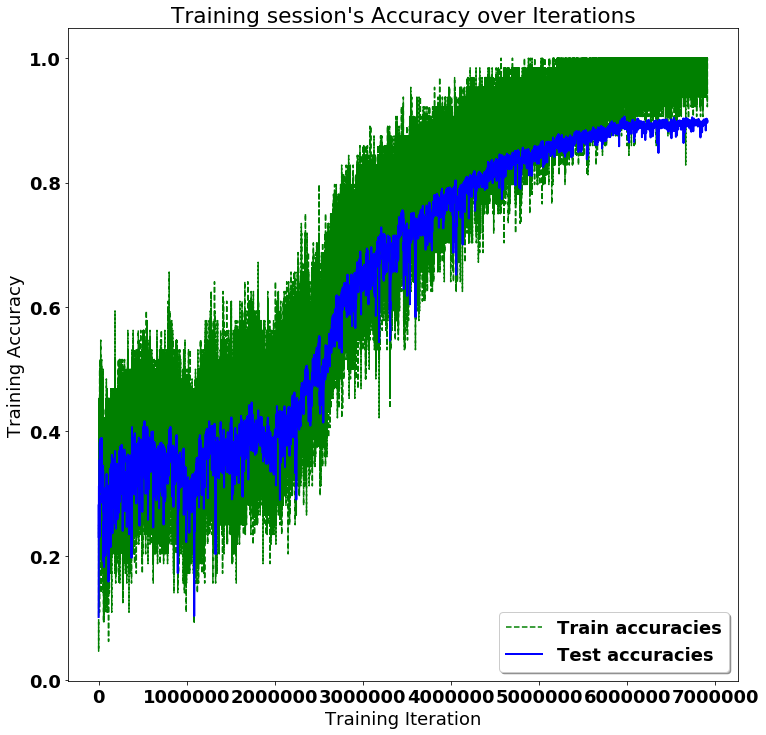

Testing Accuracy: 89.94155526161194%

Precision: 90.1718744997483%
Recall: 89.94155644417103%
f1_score: 89.93126440115316%

Confusion Matrix:
Created using test set of 32510 datapoints, normalised to % of each class in the test dataset


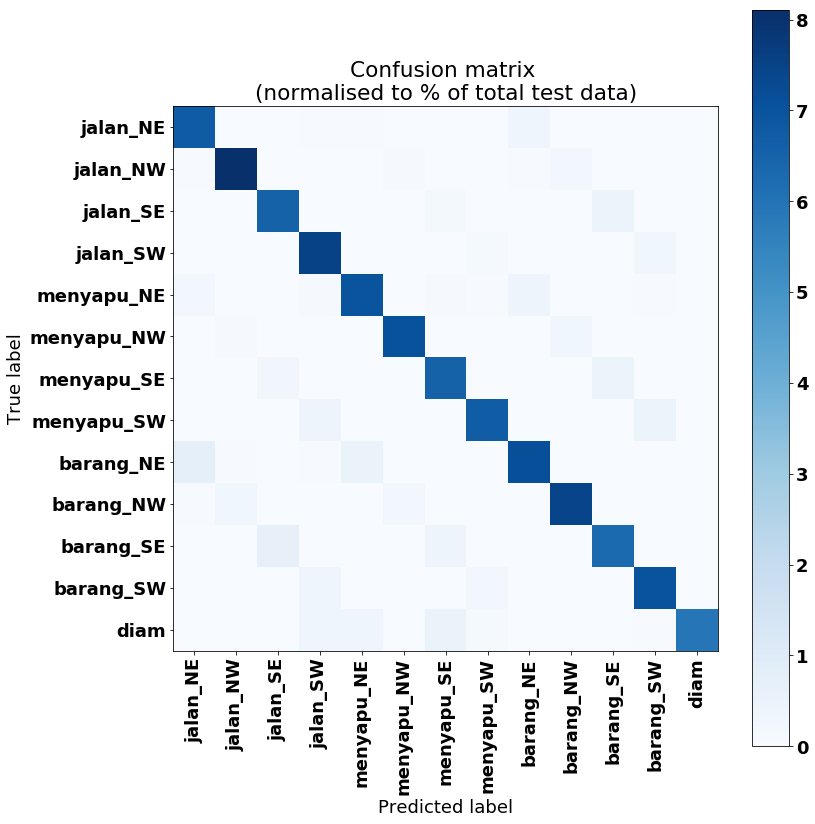

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.10169179, 0.20882805, 0.19040295, 0.25942788, 0.28252846, 0.22894494, 0.2824977, 0.3123962, 0.26035067, 0.31030452, 0.2798216, 0.29775453, 0.27591512, 0.2708705, 0.28037527, 0.28483543, 0.29184866, 0.24287911, 0.24807751, 0.23026761, 0.2581975, 0.2957859, 0.30762842, 0.34949246, 0.35456783, 0.3029222, 0.36013535, 0.38228238, 0.3718548, 0.36444172, 0.35173792, 0.3371578, 0.3496155, 0.35585973, 0.360689, 0.36641034, 0.37200862, 0.33534297, 0.35973546, 0.3488465, 0.3631498, 0.3591818, 0.36514917, 0.3578899, 0.3876961, 0.37345433, 0.36333436, 0.38880345, 0.34872347, 0.31885573, 0.33143649, 0.3490003, 0.31962472, 0.33826515, 0.32463858, 0.3242387, 0.33641955, 0.328422, 0.32343894, 0.3217164, 0.31285757, 0.31208858, 0.32636112, 0.34980005, 0.3140572, 0.35982776, 0.31617963, 0.38951093, 0.3876961, 0.370809, 0.38492772, 0.34638572, 0.33798832, 0.29295602, 0.3214088, 0.30532143, 0.30562904, 0.33558905, 0.31547216, 0.28535834, 0.30510613, 0.34238696, 0.3447247, 0.32414642, 0.31617963, 0.31405

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Writing 2630550 bytes to LSTM.md
'mv' is not recognized as an internal or external command,
operable program or batch file.


## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
